# Task 1: ANN Regression for robot arm control 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor    # multilayer perceptron for regression

In [3]:
def direct_kin_(joints, links, origin=[0, 0]):
    # Implement the forward kinematics for a two joints planar manipulator
    # It calculates the Cartesian coordinates of the endpoint of the manipulator based on the joint angles and link lengths
    # It's implemented externally so it can be used inside or outside the arm class
    
    # Initialize arrays to hold x and y coordinates
    X = np.zeros(3)
    Y = np.zeros(3)
    
    # Set the origin (i.e., starting position) of the manipulator
    X[0] = origin[0]
    Y[0] = origin[1]
    
    # Calculate the x and y coordinates of the first joint
    X[1] = X[0] + links[0] * np.cos(joints[0])
    Y[1] = Y[0] + links[0] * np.sin(joints[0])
    
    # Calculate the x and y coordinates of the endpoint (i.e., second joint) of the manipulator
    X[2] = X[1] + links[1] * np.cos(joints[0] + joints[1])
    Y[2] = Y[1] + links[1] * np.sin(joints[0] + joints[1])
    
    # Return the coordinates of all link endpoints
    return [X, Y]

def deg2rad(degrees):
    # Simple function for converting degrees to radians
    return degrees * np.pi / 180

In [4]:
class arm():
### the arm class contains all the methods for defining a two joints planar manipulator,
### and implement a neural network inverse kinematics solver for it

    def __init__(self, links = [10, 10], origin = [0, 0], init = [0, 0]):
    # class contructor, defining the basic attributes of the arm and initial configuration
        self.link1 = links[0]
        self.link2 = links[1]
        self.x0 = origin[0]
        self.y0 = origin[1]
        self.joint1 = init[0]
        self.joint2 = init[1]
        self.direct_kin()

    def direct_kin(self):
    # this forward kinematic function calculate the Cartesian coordinates for the current joint configuration    
        [self.X, self.Y] = direct_kin_([self.joint1, self.joint2], [self.link1, self.link2], [self.x0, self.y0])

    def plot_arm(self):
    # 2D plot of the current arm configuration
        plt.plot([-20,20],[0,0],'k')
        plt.plot(self.X, self.Y, linewidth=2.0)
        plt.plot(self.X, self.Y, 'ro', linewidth=2.0)
        sum_links = (self.link1 + self.link2) * 1.1
        plt.axis([-sum_links, sum_links, -1, sum_links])
        plt.axis('equal')
        plt.show()

    def create_data(self, ann, n_train, n_test, range1, range2):
    # prepare the training and test sets for the neural network solver
        self.inv_solver = ann
        n_data = n_train + n_test
        joint_space = np.hstack((np.random.uniform(range1[0], range1[1], size=(n_data, 1)), np.random.uniform(range2[0], range2[1], size=(n_data,1))))
        cartesian_space = np.zeros(np.shape(joint_space))
        for i in range(len(joint_space)):
            ax, ay = direct_kin_(joint_space[i], [self.link1, self.link2])
            cartesian_space[i] = [ax[2], ay[2]]
        self.cart_train = np.asarray(cartesian_space[:n_train,:])
        self.joint_train = np.asarray(joint_space[:n_train,:])
        self.cart_test = np.asarray(cartesian_space[n_train:,:])
        self.joint_test = np.asarray(joint_space[n_train:,:])
            
    def train_inv_kin(self):
    # train the kinematic solver
        self.inv_solver.fit(self.cart_train, self.joint_train)
        score = self.inv_solver.score(self.cart_train, self.joint_train)
        return(np.mean(score)) # return training accuracy

    def test_inv_kin(self):
    # test the kinematic solver
        score = self.inv_solver.score(self.cart_test, self.joint_test)
        return(np.mean(score)) # return testing accuracy

    def inv_kin(self, Cartesian):
    # query the trained inverse kinematic solver on a single Cartesian target
        joints = self.inv_solver.predict([Cartesian])
        [self.joint1, self.joint2] = joints[0]
        self.direct_kin()
        err = np.sqrt((Cartesian[0]-self.X[2])**2+(Cartesian[1]-self.Y[2])**2)
        return(err, [self.X[2], self.Y[2]])
    
    def set_joint_angles(self, j1, j2):
        # Update joint angles
        self.joint1 = j1
        self.joint2 = j2
        # Recalculate forward kinematics
        self.direct_kin()

I added the set_joint_angles function to enable me change the joint angles easily such that the system recalculate the forward kinematics anytime i intend to change the joint angles of the arms.

 The following functions were used in the code to peroform the following operations

 The direct_kin - calculates the Cartesian coordinates for the current joint configuration. 
 The plot_arm  - plots the current arm configuration. 
 The create_data - prepares the training and test sets for the neural network solver. 
 The train_inv_kin - trains the kinematic solver and returns the training accuracy. 
 The test_inv_kin - tests the kinematic solver and returns the testing accuracy. 
 The inv_kin - queries the trained inverse kinematic solver on a single Cartesian target. 
 The set_joint_angles - updates joint angles and recalculates forward kinematics.

# Your submission below

In [7]:
# This Cell basically creates an instance of the 'arm' class and trains and 
# tests an MLPRegressor using the create_data, train_inv_kin, and test_inv_kin methods of the arm class
# It employs the use of the default setting for MLPRegressor
# it prints out the test accuracy
#.
#.
#.

a = arm()

ann = MLPRegressor() 

n_train = 1000
n_test = 100

j1_range = (0, np.pi/2)
j2_range = (0, np.pi)

a.create_data(ann, n_train, n_test, j1_range, j2_range)
a.train_inv_kin()
a.test_inv_kin()


0.9484416568080265

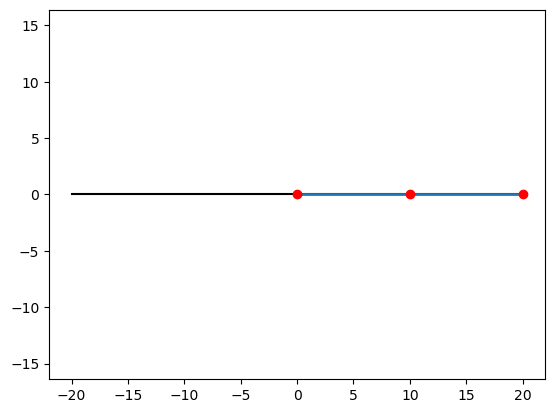

In [8]:
a.plot_arm()

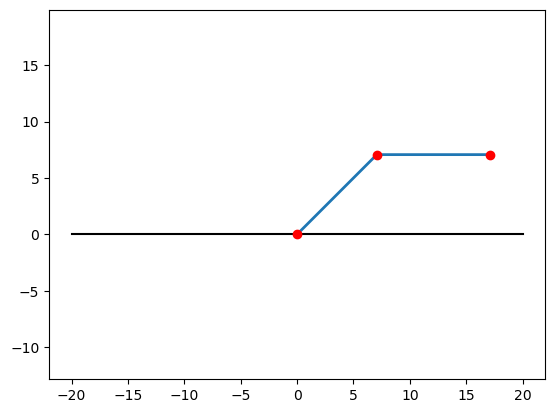

In [9]:
# In this cell I changed the Set joint angles to 45 and -45 degrees and just have a view of the plot, 
#just playing around with my set_joint_angles function
#.
#.
a.set_joint_angles(np.deg2rad(45), np.deg2rad(-45))
a.plot_arm()  # plot the arm

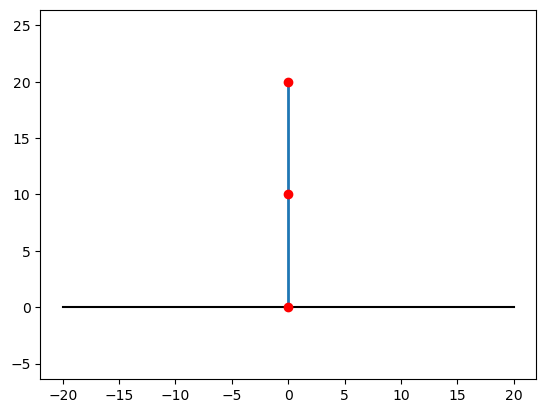

In [10]:
# More playing around with the set_joint_angles function
#
#
#
a.set_joint_angles(np.deg2rad(90), 0)

# Plot arm again
a.plot_arm()

In [11]:
# I Increased the number of neurons in the hidden layers to 50 and used the relu activation function
#
#

a = arm()

# Define the MLP regressor with 2 hidden layers of 50 neurons each and using the relu activation function
ann = MLPRegressor(hidden_layer_sizes=(50, 50), activation='relu')

n_train = 1000
n_test = 100

j1_range = (0, np.pi/2)
j2_range = (0, np.pi)

a.create_data(ann, n_train, n_test, j1_range, j2_range)
a.train_inv_kin()
a.test_inv_kin()


0.9615752279544543

The test accuracy improved a bit

In [12]:
# Using the same parameters as the last cell, i changed the activation to tanh function
#
#

a = arm()

# Define the MLP regressor with 2 hidden layers of 50 neurons each and using the relu activation function
ann = MLPRegressor(hidden_layer_sizes=(50, 50), activation='tanh')

n_train = 1000
n_test = 100

j1_range = (0, np.pi/2)
j2_range = (0, np.pi)

a.create_data(ann, n_train, n_test, j1_range, j2_range)
a.train_inv_kin()
a.test_inv_kin()


0.9752676321445319

An improvement

I could go on to change the parameters one by one but to save time i used nested for loops to loop through different combinations of the parameters and create, train and test the MLPRegressor.

I created another fuction *create_mlp* to create an MLPRegressor with customizable parameters, and then loops through all possible combinations of parameters to create, train, and test MLPRegressors using the create_data, train_inv_kin, test_inv_kin, and plot_arm methods of the arm class.

The following parameters were used:
number of layers = 1, 2, 3
Numbers of neurons per layer = 5, 10 , 20
Activation functions = Indentity, logistic, tanh, relu
learn rate = 0.001, 0.01, 0.1
optimization algorithms = adam, lbfgs
maximum number of iterations =  100, 200, 300

I used the same test and train quatity as before

I then created a table to result_list which i later saved into a csv file format later for proper viewing and analysis

In [14]:
import pandas as pd

# Define a function to create the MLPRegressor with the desired parameters
def create_mlp(n_layers, n_neurons, transfer_func, learn_rate, algorithm, max_iter):
    return MLPRegressor(hidden_layer_sizes=(n_neurons,) * n_layers,
                        activation=transfer_func,
                        learning_rate_init=learn_rate,
                        solver=algorithm,
                        max_iter=max_iter)

a = arm()

# Define the parameters to be modified
n_layers_list = [1, 2, 3]  # Test 1, 2 and 3 layers
n_neurons_list = [5, 10, 20]  # Test 5, 10 and 20 neurons per layer
transfer_func_list = ['identity', 'logistic', 'tanh', 'relu']  # Test different activation functions
learn_rate_list = [0.001, 0.01, 0.1]  # Test different learning rates
algorithm_list = ['adam', 'lbfgs']  # Test different optimization algorithms
max_iter_list = [100, 200, 300]  # Test different maximum number of iterations


# # Define an empty DataFrame to store the results
# results_list = pd.DataFrame(columns=['n_layers', 'n_neurons', 'transfer_func', 'learn_rate', 'algorithm', 'max_iter', 'test_accuracy'])
results_list = []

# Loop through all combinations of parameters and create, train and test the MLPRegressor
for n_layers in n_layers_list:
    for n_neurons in n_neurons_list:
        for transfer_func in transfer_func_list:
            for learn_rate in learn_rate_list:
                for algorithm in algorithm_list:
                    for max_iter in max_iter_list:
                        # Create and train the MLPRegressor
                        ann = create_mlp(n_layers, n_neurons, transfer_func, learn_rate, algorithm, max_iter)
                        n_train = 1000
                        n_test = 100
                        j1_range = (0, np.pi/2)
                        j2_range = (0, np.pi)
                        a.create_data(ann, n_train, n_test, j1_range, j2_range)
                        a.train_inv_kin()
                        
                        # Test the MLPRegressor and print the prediction accuracy
                        test_accuracy = a.test_inv_kin()
                        print(f'n_layers={n_layers}, n_neurons={n_neurons}, transfer_func={transfer_func}, learn_rate={learn_rate}, algorithm={algorithm}, max_iter={max_iter}: test accuracy={test_accuracy}')
#                         a.set_joint_angles(np.deg2rad(45), np.deg2rad(-45))
#                         # Plot the arm using the plot_arm function
#                         a.plot_arm()
                        
                        # Add results to list of dictionaries
                        results_list.append({'n_layers': n_layers, 
                                             'n_neurons': n_neurons, 
                                             'transfer_func': transfer_func, 
                                             'learn_rate': learn_rate, 
                                             'algorithm': algorithm, 
                                             'max_iter': max_iter, 
                                             'test_accuracy': test_accuracy})

# Create DataFrame from list of dictionaries
results_df = pd.DataFrame(results_list)

# Print results as table
print(results_df.to_string(index=False))



C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.13829649441013675
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.2723001228059871


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5944085202121907
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.7306618051611999
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.6674576046402757
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.7320640854540905
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.6586264324723988
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.6882695568301964
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.6852130747751511
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.01, algorithm=lbfgs, max_ite

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.32265415152551197
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.6116862414477495


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_it

n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.4156869027166718
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9327131271269844
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9345617076848994
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9649216062249334


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9171997413805748
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9180422829779531
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.91859535601844
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9321588802554961
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9521336494643158


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9738209058012797
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9386584771091082
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9345016338854671
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.93739400310127
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.8136135228748125
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9473781041777392


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9323419599574704
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.28269624280512795


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.6060380912279577


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_it

n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.8195361835286112
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.8406368440449552
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9188830614472225


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9279686951720402
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.6564451637545659
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9095828977744602
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9401122817107014


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9320283644031622
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9086436498699706
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9378367074624415
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9116664356833134
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.8787184318442499
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.8364873215132531
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.8864628104171297


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9118519507707681
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9165244651737736


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=-0.7634064690694253


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=-0.02197526834065444


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_it

n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=-0.10454291781292246
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.8806609079480086
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9059387869826034


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.8847360779594512
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.42870663862171576


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_it

n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.773289585106218
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.7613686130187772
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.8649457720676738
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.8139881393185894


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9381300417022025
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9174346042968384
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.7866133210765606
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.46785290476030333
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.7731671579821283
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9008860217410304


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9045843503749965
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=-0.3894608224575814


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5993513438485867


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.3638176406392674
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.692729202717029
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.6979054034052152
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.6953302645386161
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.699674448084973
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.6849496838189348
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.7150567136464653
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.01, algorithm=lbfgs, m

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5827243643144892


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.6053316534452061


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_it

n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.677413424334601
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9515493488022241
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9664490209064127


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9524095001875821
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9510242104025506
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9710316115795856
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9512966227028765
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.937868134609984
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9687423445908969


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.976417006059979
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9696018823810739
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9531456798812086
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9641583329421826
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9628913653739364
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9460237223596296


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9752528577818541
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.46231474431904673


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.7232472834794934


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_it

n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.8898003862433084
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.937457991627201
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9596965988696307


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9415924357802299
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9157129904695271
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9594973386767487
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9560207068089226
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9321641172406702
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9609498541364347


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.971548091521958
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.945027100784837
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9174395548644705
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9566936065859275


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9553873935059867
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9546459408645129


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9620008528593664
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.09207128813335352


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.3034008218657252
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.8514867700946129
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9035635630328231
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.961183119490767


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9517244428169435
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9465315965148353
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9299363287314499
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9258610633038209


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.8879322067111398
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.967205290703981
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.937889242827593


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9339418889497595
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.8883239580844002
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9449998927004764
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9471857552913266


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9254342518864473
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9530374843798972


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=-0.0742708594531239
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.6395012310552268
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.6626606313445522
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.7203415224839057
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.6830132548776018
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.6943151646918182
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.6326138576576491
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.01, algorithm=ada

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.7362826075927995


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_it

n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.8821735526866239
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9590750969820057
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9725492070511734


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9788315400759255
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9390041352541142
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9530475411256105
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9661883542930232
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9718007051204041
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9756584657608256


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.96318692344771
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.97457843193916
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9617967464622985
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9676604917639466
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9585330658505489


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9672660765452766
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9817364637188777


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.8187732746170475


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.9016301673748917
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9179217634737684
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9818974009756994


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9793724246701911


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9735103199008179
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9515124343080876
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9657032431748949
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9608082254261299


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9688932401942518
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.975914981116788


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9785984093344171
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9418611056998392
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.980792048628982
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9774609392357437
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9624191617253706


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.991854606003551


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9829519391270793
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.44583747727950823


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.8745596377822373
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9188384220007881
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9217302998332082
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.968575153729273


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9852078485957008
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9272641846999682
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9205889585793023
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9412190826102063


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9421458878709421
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9682149660191022


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9708327353635468
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9549098779960684
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9412307762584001
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9163118439797161
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9098436903736916
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9551515077379056


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9884253954682982
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=-0.6293010188216679


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=-2.319406832180211


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.6049785501568973
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.6962265953696107
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.6808882818970344
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.6708273075992333
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.7444415208702511
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.6912931408985088
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.7149239693220815
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.01, algorithm=lbfgs, max_ite

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.20027345554826648


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.44418008757174293


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_it

n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.40104610382203393
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9373878023699899
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.8769571710369357


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9167358408062968
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.920235970440928


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9493829025131364
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9647939686372069
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.8228068325831261
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9407464971092885


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.915532393116277
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9223852463320321
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9469969446854407
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9344292005632322
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9058140544534523


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9378340714345301


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9532867728227041


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.17184523826998377


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.8481675150232839


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_it

n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.6960005517554324
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9266997858151758
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9451271072567855


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9264947422415908
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.8921676993535949
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.952005368948956
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.934034762958573


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9189543065609201
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9574375195507863


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9573737547508951
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9066123546063035
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.8859377265697675
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9498094204435082
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9349537187001573
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9232548084336518


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9471186773255491
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=-0.2365596215821021


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=-0.16038940527840245


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_it

n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.4134908661036869
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.8306839901280798
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9342240106656634
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.3420027624796077


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.7147000249338348
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9441588302547222
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9333512693164381
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.7376153477873268
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.942141257161208


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9565756886382639


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.480381109244197
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.7858451604864349
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.4841444666405319
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.48551204885487687


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.94398770796007


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.7714644414300609
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.2828980305710648
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.6954312416135415
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.6707705999374017
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.6873568253313809
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.6651754014966589
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.6428601283632909
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.01, algorithm=adam, max

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.41793858819117896


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.4712993788680067


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5362871195023693
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9383360105719265


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9579026818634762


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9810418007894083
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9317075160722068


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9591712708757696
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9675269341178179
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9571454721203654


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9655003733849364


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9796260223587222
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9621171269419616
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9164318894935785
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9690172189306965


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9176939840401555
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9390144385967079


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9823578090330108


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.7366236673261473


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.8860792743921783


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9254544505723858
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9547873472970825


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9656580877337967


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9727657192648578


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.960087365678054
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9780324901065478
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9673625521575941
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9691846877980157


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9655443119568912


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9855950041366526
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9821203267106089
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9663348157352172
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9304430771857959


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9629698284774939


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9831256922935552


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9748931713128577


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.8282080653293131


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.9180671324519314


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.8783771932621756
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.945150968092747


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9647539028006091


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9697848755807458


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9597100883294671
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9414735249606278
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9634866717861637
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9553822068912075


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9728413162806404


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9628920664210462
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9624029822433287
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9399198557867792
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9049166692483752
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.947393599050687


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9496203020807719


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9564078688485763


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.6678852953236766
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.6992955691239829
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.6868700879288006
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.6838290270635345
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.6852663484085493
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.7429355719368009
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.6521889165669168
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.01, algorithm=adam

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.47274707896192597


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.6903487086697604


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.8945305035349275
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9564239281924846


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9850829343931563


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9745909454277633


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9774706275376246
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9486547688617024
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9710373411806297
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9629173485644953


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9794893070493564


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.988903044876029
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9748937498969734
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9835718066248007
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9759801426031045


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9514724628815265


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9739387569290893


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.98001352351176


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.8467679972692219
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.9588976622457934
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9378158212541212


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9610530740722386


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.980980703308887


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9885481128590339
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.974555275754545
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9861372952295007
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9759596127304712


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9679180933339342


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9890255678281757


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9900784899356888
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9561764447831509
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9395169394396026
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9678366587879181


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9748081015803298


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9810423264976862


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9905930943016614


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.9294343515888266
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.9566935608705712
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9647120343319514
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9527174814715356


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9675618476757135


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9893760676009741
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9762508270317283
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9718626303955566
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9682260779327745
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9701557368637759


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9682346789233043


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9821935717376522
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.8909544901419485
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9512024457459645
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9109563467296169


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9353280472151216


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9883957790513315


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9563896572302815


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.48305405977529925
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.6894604066833536
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.6810399293766916
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.6608966814345143
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.7083637047004897
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.688783430057971
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.6920724091331667
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_it

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.018316683726280814


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.2561788319454394


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.3978835006075816
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.6453214906275324


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.912742304473947


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9565335241240016
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.6093833643392856


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9527484173746902
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9470780631651818
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.5519785520816525


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.8422875691060214


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.6777393003863565
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.4584029349512888
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9455452691409016
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9190447774149217


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.6024581794133181
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.618472780390894


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9674739788557127
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=-0.2145774744407023


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.6911939724374813


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.8880893782242287
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9280438510112519


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9671116394243713


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9802892784842318
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.925410708281276
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9641811899497428
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9549202264776685


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.7686204085475643
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9714733729175699


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9729992170674775
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9396270125836292
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9198013216605275
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.95422763960969


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.8187000068481252
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9183584686275492


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9615240784950061
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.6369713822809544
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.7812657224708869


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.702723825953753
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9324078428734703


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.6802105045157965


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.7818101595471131
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9154707298923539


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.8907073468909571
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9759003234419301


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.8571859122087007
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.939676957554999


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9564334896132691
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.8443901662278773
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.4643633905504234
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9079802681248352


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.780771332122777
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.8820155430849945


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9494685770850199
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.7096873283646794
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.6799731360111716
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.6864401051919946
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.7081305094575565
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.6830892735166877
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.7124715030630722
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.01, algorithm=adam, max

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.2839309968310767


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.2921270751981275


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.4995554113278715
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.7778706247860607


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9288254533406145


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9671804777958708


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.7821980115501077
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9788692953971105
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9813951769412188
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9412025588749444


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.973753792801183


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9676065618467153
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9594651774838063
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9701873501847729
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9760622387172042
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.7960213462027652


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.7882170070185524


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.987066656137046


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.87057248326658
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.9381102164054651
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9560990640742209
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9559550346160761


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9538564455177067


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9797962180885141


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9771476792130438
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9856308137676002
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9590667651673688
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9515559327673533


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9874153647858807


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.984745340763832
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9448547701405331
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.8846737746753189
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9609126122943485


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9255428311230192


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9723597805901218


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9913141931219389


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.7578754341162146


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.9299539985112351
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9234589373351937
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9693123198166795


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9728617095093233


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9762641352767192


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9495500687381481
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9672543252403041
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9832313665093917
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9657839477803517


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9824949181784179


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9859521027966264
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9513138006644344
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9366827450142254
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9645733077040832


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9685535436629593


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9501730680954875


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9860848468739051


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.7449989976556408
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.6425722508675802
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.7326891343884961
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.7229924087996318
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.7224332254895093
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.7083418499879139
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.6847187860123456
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.01, algorithm=adam

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.48900269672500035


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.4816567295486878


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.48837575024077157


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.8555287586956835


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9751480217466292


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9822851999777289


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.971012268516001
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9757767874019813
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9734225871337294


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9091226704159707


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9802977200687482


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9841284144628129
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9769718123067717
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9077395758729372
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.975016391456089


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9623284166483834


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.970582484894901


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9884931051855108


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.9456786604016288
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.9706105356206787
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9622890784512758


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9735201119748705


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9739491399211057


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9949046732678973
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9807224595278581
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.979947774477499
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9620590443568402


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9694974764014774


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9775115184526513


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9847135017744532
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9566053132750325
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.8324391686666068
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9389311122172701


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9753499493852866


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.991482418384954


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9895120013990951


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.9735479335614335
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.9736815817171424
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9532405475943158


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9541524460508004


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9832921642842973


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9712432700368033
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9853606310099705
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9710622990817696
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9872873618870401


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9838684703741396


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9781973017683625


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9767126863931559
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9607786596469986
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.5070869410567822
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9508200676638849


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9452675800045611


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9864520299839932
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9898646096712422
 n_layers  n_neurons transfer_func  learn_rate algorithm  max_iter  test_accuracy
        1          5      identity       0.001      adam       100       0.138296
        1          5      identity       0.001      adam       200       0.272300
        1          5      identity       0.001      adam       300       0.594409
        1          5      identity       0.001     lbfgs       100       0.730662
        1          5      identity       0.001     lbfgs       200       0.667458
        1          5      identity       0.001     lbfgs       300       0.732064
        1          5      identity       0.010      adam       100       0.658626
        1          5      identity       0.010      adam       200       0.688270
        1 

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [15]:
results_df.to_csv('ass1results1.csv', index=False)

After sorting out the data, it was found that the highest accuracy achieved was 0.994904673 using the following parameters:

Number of layers = 3
Numbers of neurons per layer = 20
Activation function = tanh
Learning rate = 0.001
Optimization algorithm = lbfgs
Maximum number of iterations = 300

It was also observed that out of the best 20 results, lbfgs was the best optimization algorithm with 18 out of the 20 best results. The tanh activation function gave 11 of the best 20 results, while using 20 neurons per layer gave 17 of the best 20 results. A learning rate of 0.1 was found to be optimal for 11 of the best 20 results, and having 3 layers was optimal for 10 of the best 20 results.

These observations provide insights into the optimal parameters for achieving high accuracy in this model. It is important to note that these results may not be generalizable to other models or datasets, and further testing may be necessary to confirm the effectiveness of these parameters.

In [20]:
# Sort the DataFrame by test_accuracy column
sorted_results_df = results_df.sort_values('test_accuracy')

# Print the last 20 values of the testing accuracy
print(sorted_results_df.tail(20))

     n_layers  n_neurons transfer_func  learn_rate algorithm  max_iter  \
403         2         20          tanh       0.010      adam       200   
646         3         20          relu       0.100     lbfgs       200   
539         3         10      logistic       0.100     lbfgs       300   
638         3         20          relu       0.010      adam       300   
550         3         10          tanh       0.010     lbfgs       200   
430         2         20          relu       0.100     lbfgs       200   
215         1         20          relu       0.100     lbfgs       300   
611         3         20      logistic       0.100     lbfgs       300   
401         2         20          tanh       0.001     lbfgs       300   
389         2         20      logistic       0.010     lbfgs       300   
406         2         20          tanh       0.010     lbfgs       200   
419         2         20          relu       0.001     lbfgs       300   
629         3         20          tanh

For the next test, the same parameters as in the previous test were used, but with modifications to both the train and test data quantity as well as the joint ranges. The train data was increased to 5000 and the test data to 200. Additionally, the joint ranges were adjusted to j1_range = (0, np.pi) and j2_range = (-np.pi/2, np.pi/2). These changes were made in an effort to improve the accuracy of the model.

It will be interesting to see how these modifications affect the accuracy of the model in comparison to the previous test. It is important to note that while increasing the amount of data can generally improve accuracy, it is also important to ensure that the model is not overfitting to the data. Therefore, the joint ranges must be chosen carefully to provide enough variability for the model to learn from while also preventing overfitting.

In [23]:
import pandas as pd

# Define a function to create the MLPRegressor with the desired parameters
def create_mlp(n_layers, n_neurons, transfer_func, learn_rate, algorithm, max_iter):
    return MLPRegressor(hidden_layer_sizes=(n_neurons,) * n_layers,
                        activation=transfer_func,
                        learning_rate_init=learn_rate,
                        solver=algorithm,
                        max_iter=max_iter)

a = arm()

# Define the parameters to be modified
n_layers_list = [1, 2, 3]  # Test 1, 2 and 3 layers
n_neurons_list = [5, 10, 20]  # Test 5, 10 and 20 neurons per layer
transfer_func_list = ['identity', 'logistic', 'tanh', 'relu']  # Test different activation functions
learn_rate_list = [0.001, 0.01, 0.1]  # Test different learning rates
algorithm_list = ['adam', 'lbfgs']  # Test different optimization algorithms
max_iter_list = [100, 200, 300]  # Test different maximum number of iterations


# # Define an empty DataFrame to store the results
# results_list = pd.DataFrame(columns=['n_layers', 'n_neurons', 'transfer_func', 'learn_rate', 'algorithm', 'max_iter', 'test_accuracy'])
results_list2 = []

# Loop through all combinations of parameters and create, train and test the MLPRegressor
for n_layers in n_layers_list:
    for n_neurons in n_neurons_list:
        for transfer_func in transfer_func_list:
            for learn_rate in learn_rate_list:
                for algorithm in algorithm_list:
                    for max_iter in max_iter_list:
                        # Create and train the MLPRegressor
                        ann = create_mlp(n_layers, n_neurons, transfer_func, learn_rate, algorithm, max_iter)
                        n_train = 5000
                        n_test = 200
#                         j1_range = (0, np.pi/2)
#                         j2_range = (0, np.pi)
                        j1_range = (0, np.pi)  # set range of j1 to be between 0 and pi radians 
                        j2_range = (-np.pi/2, np.pi/2)  # set range of j2 to be between -pi/2 and pi/2 radians 
                        a.create_data(ann, n_train, n_test, j1_range, j2_range)
                        a.train_inv_kin()
                        
                        # Test the MLPRegressor and print the prediction accuracy
                        test_accuracy = a.test_inv_kin()
                        print(f'n_layers={n_layers}, n_neurons={n_neurons}, transfer_func={transfer_func}, learn_rate={learn_rate}, algorithm={algorithm}, max_iter={max_iter}: test accuracy={test_accuracy}')
#                         a.set_joint_angles(np.deg2rad(45), np.deg2rad(-45))
#                         # Plot the arm using the plot_arm function
#                         a.plot_arm()
                        
                        # Add results to list of dictionaries
                        results_list2.append({'n_layers': n_layers, 
                                             'n_neurons': n_neurons, 
                                             'transfer_func': transfer_func, 
                                             'learn_rate': learn_rate, 
                                             'algorithm': algorithm, 
                                             'max_iter': max_iter, 
                                             'test_accuracy': test_accuracy})

# Create DataFrame from list of dictionaries
results_df2 = pd.DataFrame(results_list2)

# Print results as table
print(results_df2.to_string(index=False))




C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.2153330993593815
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.4344509545742989
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.47375431301980886
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.46037242035346904
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.4367443535191354
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.47962737658094856
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.4469879056523341
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.01, algorithm=adam, max

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.49776484827485906
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5231566167892217
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.50935216209966
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5350343885554631


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5116107789528312


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.4928621344066135
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.476933381165371
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.5299441721991129
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.5217261112069078
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.5861723770080869


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5284154556533748


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.49488481166972004
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.4906716345692322
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.4485277241272263
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.4672488189502736
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5413675049369024


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.6015455189476315


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.5470373974501002


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5031176718684326


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.4989324188193482
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.516543644165937
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.48083411375854684


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5193242134749454


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.5062646795885014
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.5228859793426825
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.5107064108184205
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.553379223063551
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.4661171647571037


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.4974550739782175


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.4936230611913988
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.4707307865348547
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.4772977549409303
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.4617556021138889


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5427637002100336


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5102754883024927


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.502523647094278


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.3888874805867245


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.4614406064042285


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.562667228289387
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.49766058504456323


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5602208153368899


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.5504173966058361
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.5155390769775523


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.4877315791605989
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.553808509587612
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.5174471694367212


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5391633183686303


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.5167488630891625
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.5473331373015247
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.44242236324940615
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.5373899450769707
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5637925568693802


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5615012565124449


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.546343767409043
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.433281952073184
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.4397559453364477
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.45802688365406086
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.4522513440631959
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.43215214721996426
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.45663482729682264
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.01, algorithm=adam, ma

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5676026029242142
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5542312298561374
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.520440067553384


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5365917957074553


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5298087480579766


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.582172421384525


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.5324490636632495
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.4907266433941803
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.5211169766638639


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.5260945926147977


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5609600174821614


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.6153366953651138
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.47895910818231224
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.4881540033701356
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.5620217083852361


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5591265427962044


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5275015788895674


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.5327467706903187


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5378607713749026


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5181756892116416


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5291786444462891


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.4556247353894398


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5561987635934321


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.52578450869194


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.5329433655161516
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.5612144629071647
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.5394058431581374
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.5168680680623144


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5200206308515631


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.5526754740134163
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.4660383105946187
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.47760848322813426
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.5517986340389522


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5392132355027804


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5598925773416299


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.6053898488422174


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5399899411215947


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5219547357905097


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5251433568968557


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5595988847597115


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5778416864019427


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.6118023868426323


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.55459139080558
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.557745091882337
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.5311038073088008


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.5604146180414931


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5524179136209622


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.5229337760437541
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.5725241155325846
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.5417324734955
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.5438652231965501


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5292217711776965


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5561599061965405


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.6081977265360796
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.4821236192378733
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.4607757033357905
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.4881872412816473
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.47288366072857135
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.45899267769253327
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.4109964280237738
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.01, algorithm=adam, 

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5806057638751271


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5540810571052956
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.4948575413545911


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5458358154753675


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5893392268617811


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.5581788234130669


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.6159160631049894
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.5799096245648825
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.5983505670954221


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.5663133375785483


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.7038779680619681


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.567719354094768
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.5255311328054777
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.5736021119246877
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.49860808002528106


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5322244185896554


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5755791294109864


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.6374071864846989


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5250187998004172


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5606171932351602
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5248913235677002


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5193096848507


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5576057682229141


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.6079862354302188


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.5765247128405911
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.6052025114315622
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.6293885397281417


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.5314332070610559


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5873189963617798


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.6177023636769454
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.4918695089790671
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.49628347598457234
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.5350051119322534


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.48485674830830183


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5846733952930956


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.586501195431782


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5610417864281623


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5580874933423563
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5501611902216159


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.560797027089553


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.583560795486419


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.5515878368813476


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.5438648172388874
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.605729065422959
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.6067919409585621


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.5671931950107336


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5389409222141299


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.5952765313112995
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.6112257565505522
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.5436320633480667
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.5297115417287672


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5589418013368352


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5378391014434771


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.5229521790990088
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.43125612732791935
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.510139210959514
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.4904655909150264
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.42768605162544027
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.44752803729191337
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.48194715071724525
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_it

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.559608591549587
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.49409069623922747


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.48227058613577073


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.49702805344365


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.548481139134708


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.5602199251592012
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.469800496573827
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.5433498005378672
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.5393147192690864


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.6351087657641366


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.518609335074969


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.6027197048570767
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.5666899945469774
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.4821032043405751
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.5033292032811688


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5415592252854111


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5353991209350326


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.5696415660676144


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.49147241678390224


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5111822444638869
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5065248051685363


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5893017481629997


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.6023317546143139


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.5514368105838461


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.5951825099332284
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.6219660614406386
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.5504265335044275


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.5044861929017025


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5516737597223595


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.6361515797633462
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.5101161381821924
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.4885587476130116
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.5154554560565634


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.544706763422853


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5526046925164595


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.5610689435227327


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5777037248709309


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.4993542406880194


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5085000318462508


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.46691121708543315


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.49722273806299894


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.5485188160427961


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.5636220243061311
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.5562212110941493
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.5643216288215818


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.486668095555897


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5132388794082708


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.5498772177510167
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.5009547537330921
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.5585600330324545
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.5113321335479929


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5667236205056608


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5352312887914796


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.5427291043553948
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.41569496698104635
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.47796916837118203
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.44375031283253735
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.45261565046682295
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.4654862042999948
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.44353999319267123
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.01, algorithm=adam

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5052390672421612
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5309651706398786
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5113402227194916


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5168763281258849


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5038239535132946


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.5675347480987709


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.53776901292405
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.637331930222569
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.5543410038625015


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.5695730138622372


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5084012563808828


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.5663019983351869
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.5606238904955219
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.5705258785873407
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.5603639704419991


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5498248625358393


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.550603217622951


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.5764745508361884


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5190021375091609


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5595046330158928


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5411458715802702


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5485801888875891


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.6000819735503542


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.6095005033314147
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.5853078619616541
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.6186686502462606
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.6173212345475725


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.5443698149799391


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5391540621659581


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.5573841220644695
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.49773021868099265
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.4822765332408634
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.53782228963275


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.552468409319741


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5827795184834332


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.6240849649780282
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5380592866421188


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5048728491470346
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.6077804690268486


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5253620277607917


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5250611807438114


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.5636377108742981
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.5049881230080788
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.6212648416271584
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.5569807969069993


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.5285396103462945


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.6167623185468645


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.5660084700368118
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.5641232526941683
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.569195638406021
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.5666143724111912


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5642311183871225


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.612800650798333


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.593363470546919
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.4572589065543728
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.46223539684545806
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.45259721244080275
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.4447770114949753
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.43107185385417957
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.4650627818616584
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.01, algorithm=adam, 

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.537267061113246


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.505998297679103
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5465566291430513


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5445035930931021


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5339430402511467


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.5907955592188674


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.6014462126345299
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.596848030050733
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.5731201491928721


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.5579855991491318


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.558163607248574


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.6104985968231826
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.5796595589526914
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.5902294749722375
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.5662883239723757


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.4976167597187814


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5283673292095061


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.5362243022928147


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.654817634130288


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5609601810731895
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5252792726220381


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.6239231722384637


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5483283662632547


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.5849294444375661
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.6273773617861367
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.5776223524161327
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.560333687536686


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.6025065004545866


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5678500401126736


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.6495867489690829
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.5485604268930773
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.5251140997611992
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.4692886106424797


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5550438677954703


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5817459192187984


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.5602709758577815


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5678236201100593
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5708520481387115
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.6130896697829992


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5417710714209599


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.6000398758784015


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.5818989173522715
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.6147552481198241
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.6051947403165745
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.6269206961339627


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.5553393961548243


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5695942068111582


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.631460416291252
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.5127264681514929
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=-2.9275137367501536e-05
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.4717787831268726


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5491876330141712


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5871408162215856


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.5601068486291727
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.4277310871519235
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.4444067863913614
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5030148202996885
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.4320635260070657
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.4522915531560418
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.440145128524951
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_iter=1

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.45973305996114666
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.47281354068629206
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.48342814975646353


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5019023799353859


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5635321860918004


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.5440096486118554


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.5674877323879928
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.5175713157415879
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.5242780746719506


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.5112419276283939


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5308287344534304


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.551339047468109
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.5887304864738403
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.5771597662688219
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.5199692871636573


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5111952791533458


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5226342487253204


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.5254779233572797


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.492767153102571
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.4856866840837069
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5114660537161262


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.4956168001782582


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.588622230268704


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.5446519187460215
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.48234872427846315
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.4917587394444317
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.5641242641544426


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.5280367652156037


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5217081483641599


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.5619466777987442
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.47062562025734456
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.4676441167862245
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.4566517372159186


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.48230749333671136


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5342256952029814


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.5718173186951138


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5316270367909457


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5405015129039643


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.4915881260811369


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5391374244820618


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5416184303175484


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.5279535071404198


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.5237776990782244
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.539801846001424
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.532883601997754


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.4950199798362749


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.553341076760079


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.5725681531018858
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.43662584233848184
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.5261301035044823
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.48975293170567236


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5004206897694776


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5282310232446314


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.5641428680892661
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.4375673320687153
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.4842832060919813
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.4532799821474315
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5107335400192132
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.4912542541369568
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.49110054090167604
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.01, algorithm=adam, ma

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.4556003735505467
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5320817658615415
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5434440526976487


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5350821002085899


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5400076454017855


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.6059784528949105


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.532326712933971
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.5093072164998758
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.5798825391432095


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.4960944858103346


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5057486711654008


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.5409584297469154


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.5411209063786548
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.5878481230496417
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.5298288569566045


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5286733004514873


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.582802481403916


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.5522658988396557


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5879868815202574


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5565979040922131
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5033437777018631


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5579772988639127


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5683110012467105


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.595574295351623


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.5724746649354236
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.542939297129045
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.5286105956492368


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.5572566039380653


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.6288415782700159


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.588529002344837
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.5238494678488452
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.4720189796069972
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.47303372408981986


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5155808717910433


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5242769861300987


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.5691665713711613


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5702420948875696


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.6521774736365071
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5332926996593346


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5128238856386355


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.556432061585836


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.5515764545226128


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.5398503555279315
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.5731423563327043
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.5811293369367632


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.548696116724709


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5932646006767877


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.598524733882912
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.41134762022662186
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.500260769028736
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.45712497859927


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5221451068360771


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5455929181737488


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.530734128917449
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.42928313970513593
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.45405453231536164
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.44330040867668496
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.47207355985077853
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.4736040097546719
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.4505030977079191
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.01, algorithm=adam,

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5112649715819056
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5283133610397259
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5009551193241991


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5250856215061764


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5370183357552912


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.543451796301059
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.5071531875714954
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.5921952030963504
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.6163858570686884


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.53431043545264


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5099558137798788


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.6055158050220213
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.5410375467567162
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.5738771695997651
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.5574060371151103


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5011000311428168


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5862729725354727


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.5129569061666106


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5594089039675312
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.6025721572452887
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5503466963838186


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5731929040894851


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.606576468101957


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.5547566918738862
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.5776495197986754
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.5437206485742285
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.609231395436812


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.5099262356070609


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5696943712486446


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.5672311089228601
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.47452940026611296
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.5165933416852793
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.44308451672513616


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5561858945354865


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5450829177273608


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.5613015168554129


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5320129123920023
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.6713792862892772
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.5811720934422578


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5979757992793726


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5210306798466829


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.5787806873988024


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.5522465095533209
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.5702600368712809
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.6088457508893158


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.6117155412067976


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.5339334857527529


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.6280598998628045
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.5629537913970859
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.5751075801516485
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.5268556245726246


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.5528835537550877


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.577898669037779
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.5657544723857357
 n_layers  n_neurons transfer_func  learn_rate algorithm  max_iter  test_accuracy
        1          5      identity       0.001      adam       100       0.215333
        1          5      identity       0.001      adam       200       0.434451
        1          5      identity       0.001      adam       300       0.473754
        1          5      identity       0.001     lbfgs       100       0.460372
        1          5      identity       0.001     lbfgs       200       0.436744
        1          5      identity       0.001     lbfgs       300       0.479627
        1          5      identity       0.010      adam       100       0.446988
        1          5      identity       0.010      adam       200       0.449377
        1  

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [26]:
results_df2.to_csv('ass1results2.csv', index=False)
# Sort the DataFrame by test_accuracy column
sorted_results_df2 = results_df2.sort_values('test_accuracy')

# Print the last 20 values of the testing accuracy
print(sorted_results_df2.tail(20))

     n_layers  n_neurons transfer_func  learn_rate algorithm  max_iter  \
331         2         10          tanh       0.010      adam       200   
349         2         10          relu       0.010      adam       200   
259         2          5          tanh       0.010      adam       200   
399         2         20          tanh       0.001     lbfgs       100   
341         2         10          tanh       0.100     lbfgs       300   
422         2         20          relu       0.010      adam       300   
402         2         20          tanh       0.010      adam       100   
641         3         20          relu       0.010     lbfgs       300   
550         3         10          tanh       0.010     lbfgs       200   
188         1         20          tanh       0.010      adam       300   
425         2         20          relu       0.010     lbfgs       300   
243         2          5      logistic       0.010     lbfgs       100   
263         2          5          tanh

Based on the results of this test, the obtained highest accuracy of 0.703878 is not a desirable value. It is suspected that the main cause of this low accuracy is due to the joint range change. This is because while increasing the number of training data should ideally increase the accuracy, increasing the joint range may reduce the accuracy as the neural network has to generalize its predictions to new input values outside of the training set. A wider range may cause the model to encounter input values that it has not seen during training, which could lead to decreased accuracy. On the other hand, a narrower range may lead to more overfitting if the model is too complex relative to the amount of data. Therefore, it is crucial to choose appropriate joint ranges that provide enough variability for the model to learn from while preventing overfitting, in order to achieve higher accuracy in future tests.

In [28]:
import pandas as pd

# Define a function to create the MLPRegressor with the desired parameters
def create_mlp(n_layers, n_neurons, transfer_func, learn_rate, algorithm, max_iter):
    return MLPRegressor(hidden_layer_sizes=(n_neurons,) * n_layers,
                        activation=transfer_func,
                        learning_rate_init=learn_rate,
                        solver=algorithm,
                        max_iter=max_iter)

a = arm()

# Define the parameters to be modified
n_layers_list = [1, 2, 3]  # Test 1, 2 and 3 layers
n_neurons_list = [5, 10, 20]  # Test 5, 10 and 20 neurons per layer
transfer_func_list = ['identity', 'logistic', 'tanh', 'relu']  # Test different activation functions
learn_rate_list = [0.001, 0.01, 0.1]  # Test different learning rates
algorithm_list = ['adam', 'lbfgs']  # Test different optimization algorithms
max_iter_list = [100, 200, 300]  # Test different maximum number of iterations


# # Define an empty DataFrame to store the results
# results_list = pd.DataFrame(columns=['n_layers', 'n_neurons', 'transfer_func', 'learn_rate', 'algorithm', 'max_iter', 'test_accuracy'])
results_list3 = []

# Loop through all combinations of parameters and create, train and test the MLPRegressor
for n_layers in n_layers_list:
    for n_neurons in n_neurons_list:
        for transfer_func in transfer_func_list:
            for learn_rate in learn_rate_list:
                for algorithm in algorithm_list:
                    for max_iter in max_iter_list:
                        # Create and train the MLPRegressor
                        ann = create_mlp(n_layers, n_neurons, transfer_func, learn_rate, algorithm, max_iter)
                        n_train = 5000
                        n_test = 200
#                         j1_range = (0, np.pi/2)
#                         j2_range = (0, np.pi)
                        j1_range = (np.pi/4, np.pi/2)
                        j2_range = (np.pi/4, np.pi)
                        a.create_data(ann, n_train, n_test, j1_range, j2_range)
                        a.train_inv_kin()
                        
                        # Test the MLPRegressor and print the prediction accuracy
                        test_accuracy = a.test_inv_kin()
                        print(f'n_layers={n_layers}, n_neurons={n_neurons}, transfer_func={transfer_func}, learn_rate={learn_rate}, algorithm={algorithm}, max_iter={max_iter}: test accuracy={test_accuracy}')
#                         a.set_joint_angles(np.deg2rad(45), np.deg2rad(-45))
#                         # Plot the arm using the plot_arm function
#                         a.plot_arm()
                        
                        # Add results to list of dictionaries
                        results_list3.append({'n_layers': n_layers, 
                                             'n_neurons': n_neurons, 
                                             'transfer_func': transfer_func, 
                                             'learn_rate': learn_rate, 
                                             'algorithm': algorithm, 
                                             'max_iter': max_iter, 
                                             'test_accuracy': test_accuracy})

# Create DataFrame from list of dictionaries
results_df3 = pd.DataFrame(results_list3)

# Print results as table
print(results_df3.to_string(index=False))




C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.6250158597725517
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.7353708050138211
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.731569794516028
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.6884722438130538
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.728426519497801
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.7271427882543315
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.7054839634756955
n_layers=1, n_neurons=5, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_iter

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.680878797120511
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.6590465927715878
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.695467566105059
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.7088696824264806


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9315190540079371


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9074929303238392
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9138458754220996
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9390725302084769
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9424277878788727
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.675362828805693


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9003654028938153


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9700341506636714
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9661756426772958
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9725737342887759
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9797744627909777
n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9056988703322919


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9281314167702559


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9560765827815567


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.7555616445991746
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.37307659433531687
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.7382451426968935
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.8081476266016339


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9475477830486265


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.954684069626853
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9441127088049022
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9561132794846747
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9246985127281995
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.8510556109019007


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.7017695204980963


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9545454637534294
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9542784329770224
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9493415022310934
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9389542796363226
n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.4922437353444974


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.7711988429914053


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9270093919624429
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.8014304929681622


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.29622594366157706
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.6660438184177904
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9149268878039865


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.7188894098014356
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.4742110905154671
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.7892043321406568
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.6937816411743023
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.8529702687982209
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.4928037745655072


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.8967184249236162


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9032268757050108
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=-0.014880148704515483
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.6812176815877006
n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.6921024089652543


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.8599500212291827


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.909057453152343


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.846486361233198
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.6822907963887432
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.7034795951296144
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.7167066962365832
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.7391629093012745
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.6632057862186029
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.7295601247261959
n_layers=1, n_neurons=10, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.8088180132521938
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.8154064600874866
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.7200687386039621


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9446025312285611


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9565591007770817


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9776288081439913
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.978849063384341
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9685354416447511
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9372786323782212


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9475309052344294


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9769497102877003


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9611182490321699
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9842009444063868
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.975208493166634
n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9808887302452602


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9602926005872386


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9596975229550533


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9759567793802082


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.8280577236130425
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.9148399247889201
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.931204848203405


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.8024611686754477


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9668329063633417


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.972848012679439
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9513535446274934
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9709691781990912
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9567234937707694


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9150386567711122


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9651735933653374


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9777966480025948
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9774191965424115
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9733400580726171
n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9595865247943478


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.8192114434452267


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9833369664880814


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9789801074568418
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.7766560539214353
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.884588556135061
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.6814929963464429


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9342787115824638


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9524225605918717


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9098418425540999
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9310590370433709
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9495197096899307
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9389228792543063


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9211253381091871


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.8699951316512016


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9530634032042308
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9463134441982635
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9238080204089639
n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.7635444430187661


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9160450932998531


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9687016617139943


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9586235323813888
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.69660173018285
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.7197401402176857
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.7113080043802065
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.6981390128472564
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.719034739211573
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.7402600742065745
n_layers=1, n_neurons=20, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_i

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.8986175172328121
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.7413224996671195
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9147798302919978


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9659886881864702


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9747919436847354


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9824835857601064
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9568215545691978
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9695593208769537
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9665638804797061


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9741444591449546


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9839529254962345


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9906581652611764
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9698278859693776
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9849273096115658
n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9893000392917115


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9681768596118339


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.987246330422774


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.978984958334939
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.9464877423529647
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.9322389264955548
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9360386947269346


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9765184309491539


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9875421556858142


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9947501286927514
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9696788905996081
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9891352103956292
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9776296110896157


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9847370321309408


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9843325118067062


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9859326398799857
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9463425753416189
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9784193479308485
n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.8765643136799561


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9753142611998843


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.983547282321827


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9883423960400295
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.9489886833809711
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.9359714899280496
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9266640783779541


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.8977210274942121


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9651292927120296


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9702402482616767
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9573206677507617
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9461628895022349
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.967690695728223


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.7174141148211715


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9670046428066732


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9394430258130461
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9725644818064805
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9621473496583931
n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9777241687738877


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9451782124900542


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9614441337031143


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=1, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9706997590641899


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5054643067708938
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.7318926825759156
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.6955744539138017
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.7021310474802124
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.7376690680470768
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.6871312012198276
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.7350044795858863
n_layers=2, n_neurons=5, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_it

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.23497336173402567


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5632934527255689
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.6870431101575057


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.8902985978534634


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.8982884609674888


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9155235696125333
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9402851791097626
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9444217370594197
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9300150467640844


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.8635584833006815


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9400693202039005


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9546802954973517
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9774936515270874
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9208746702992907
n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9648810627755716


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.7509039266193385


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9579381248976127


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9806132449439114


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.4839188276325895
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.4861291441479084
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.6630031334146332


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.855135243968276


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9170850154390113


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.7556437668906784
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9643079358067352
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9563086485360754
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9532200292085913


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.4933125058176132


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9704683371717848


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9616901764104129
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.4779581671399975
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.4924010340728887
n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9571440302045645


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.6219708367287959


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.84837167498149


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9579099121386343


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.7350081512161866
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.762196821834662
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.6840841603149097


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5804398881152188


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5276282837783577


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9438452577713335
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9403032196199743
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9312055617447765
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.4985580932383175


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.509994211245135


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9668517837799877


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.49857613110998505
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.46567387385363096
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9256929826734872
n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.47690355167188314


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.8875189620511696


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.8524562418132073


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.8906503468780735
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.7318309741465325
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.6905295465793744
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.699395208119717
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.7589079663400036
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.754167652085121
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.69969789680373
n_layers=2, n_neurons=10, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_ite

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.6548156581406471
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.8848081101556757
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9446911502883681


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9230460714715769


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9654336773585724


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9738555647087507
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9577375635458998
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9422330786030122
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9591610859550986


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9062471682224807


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9628642587475207


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9793316740087146
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9801691707037291
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.4927729864453714
n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9771975890856812


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.8210500933199064


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9484350040978624


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9799448092029432
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.916173059805512
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.9647611089809968
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9387700556801273


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9583706972833055


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9840319521722574


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9820768986906402
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9871974626348665
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9833264037247554
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9834270882269032


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9476550466024976


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9773782136077833


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9859142954171406
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9610280097254191
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9854818185172822
n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.961530566295624


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9448387124478281


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9818110368190913


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9846301823468488
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.9033114919501841
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.912581853593804
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.8746475755095977


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9574962981791448


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9720663448656357


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9547243671466885
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9266397938608282
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9260389114030007
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9762387514908631


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.8122912823432011


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.953651838017419


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9247939840797832
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9415557457930239
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9524513698704374
n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9344462145794273


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.939973462272846


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9445757340382867


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9360052762249008
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.6785550201284466
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.706958717990634
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.7343775686288374
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.7070128916955924
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.7452470355963167
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.757922129165999
n_layers=2, n_neurons=20, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.9277853101782093
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.9351107490240733
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9564859565303445


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9361540368843297


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9624923179980525


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9895252679270077
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9804494625535849
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9743089773744021
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.972543675280729


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9141636637092206


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9877170633592245


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9840645346760448
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9881761688374585
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9880335627210075
n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9910879957114154


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.957945093038927


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9723148316604654


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9845276735076698
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.9669918298044315
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.9691331842601685
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9758454759587879


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.961154499647733


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9825088109504259


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9860440836087512
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9840225198785281
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9869733641624537
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.991209764185725


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9797272066039227


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.993090448711601


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9790803753609069
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.984158114997129
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9714612044641133
n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9873113191111962


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9847898028894593


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9869621785683345


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9889914228218732
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.9495399648712038
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.9781491325632179
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9423156973023867


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.8908364248642906


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9878766128805391


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9867241975521499
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9635122398892577
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9818094689670614
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9670097770663413


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9410586245515421


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9827264349208422


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9682202794742025
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9687338197609754
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9650373272761548
n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.49196132111631513


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.8963866686561964


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9712712569517906


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=2, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9804840152833748
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.7448735910933058
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.7511647127015812
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.7036915966079357
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.7313589546939647
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.7013205697727671
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.7277575082979649
n_layers=3, n_neurons=5, transfer_func=identity, learn_rate=0.01, algorithm=adam, max_iter=

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5430344320992555
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.4948009614297344


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5418680408495925


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.49909111687631574


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.6374985098405723
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.8792059619988054
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.5025219347034954
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9682533838936666


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.495322884205734


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.769047559119406


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.8137665497650365
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9754284357413077
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9389516894859057
n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9662547384223652


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.4988251381704713


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.5670692284669214


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.5012186149840354
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.48167782201698894
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.8904248532487744
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.4867361744768298


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.4962464295197017


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.5070394234876379


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9668145267909518
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9734018679569454
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.49513908453106065
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9854819920903296


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.4754299762952133


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9342207414250372


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.956398554542067
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9300323548533762
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9611653346269143
n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9524642284534034


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.8662745713361724


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9349516132478619


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.7311211029584257
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.724322877153575
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.7235386852283179
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.8726288908657701


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.4892300940672566


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9573942673975431
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9021798177091405
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.7669955053403422
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9260331274316762
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9185575847804304


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.7524031628278285


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9672688261993616


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9211676475944196
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.4858079819936193
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=-0.0006524749517688999
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9596555545311363


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.4954092651820685


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.49282686292338296
n_layers=3, n_neurons=5, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.7236114185812331
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.7682770124040427
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.7494195963045484
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.7164880542714416
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.7182566533330486
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.7299513997820548
n_layers=3, n_neurons=10, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_ite

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.49981781473477627
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.5511503511448188
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9228272928686816


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.5125635055438662


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.6088862964270086


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9849739196982691
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9839022497503918
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9660056444661949
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9668576413724905


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.49251095516679994


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.8492642471913919


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9837553103096515
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9894881449408364
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9649820036318666
n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9772947307982411


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.4931321865752128


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9536890497809796


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9676797305879765
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.9030455298546033
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.9364942938295406
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9596840500365966


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9376542399664214


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9842269535488781


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9693209263508379
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9814236427034808
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9865704742380679
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9751473358836991


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9661610548176129


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9799712738461416


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9790502362886151
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9675748423550584
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9782010153839653
n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9738833825632875


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9586035563318069


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9816737214020673


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.970384142629604
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.9086744863886609
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.92724361939876
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9358813910495096


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.8857315342175099


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9821349275503135


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9733428705080552
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9779186465066134
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9719554616274684
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.962198120124367


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.945526012116732


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9727648514988115


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9353836272223197
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9746303075754055
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.4371200294194614
n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9179700052711596


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.7998577622277043


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.97330086449847


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=10, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9436416595346636
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.7013772081436953
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.7001600977622251
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.7399040329658485
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.7137631159612752
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.7424887891547378
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.7130830225506524
n_layers=3, n_neurons=20, transfer_func=identity, learn_rate=0.01, algorithm=adam, ma

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.5909737719289664
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.9554045985077204
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9590131138322884


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.7659255428826643


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9344567341735286


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.980272781764444
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9858395554594853
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.9619864966957787
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.978624454156568


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.6818105694501788


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9750204746463329


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9841797634039641
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.46336005812543624
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.984272392201895
n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9565628363278211


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9235949751640995


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.949001334432559


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=logistic, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9904416773338527
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.9733191319776294
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.9509823725766194
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.9756697428859451


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.971570299605093


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9883315811095308


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9862212860116526
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9855592277725267
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.982307734599809
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9933858988957875


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.9770620102825022


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9862000782525764


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9961809890769219
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9401016633759491
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9407212146478918
n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9302136129101051


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9846759802669098


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9945620148640111


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=tanh, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9933890054498593
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=100: test accuracy=0.9711570908034235
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=200: test accuracy=0.983276938010027
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=adam, max_iter=300: test accuracy=0.973723790285216


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=100: test accuracy=0.9911795018487979


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=200: test accuracy=0.9926531140487161


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.001, algorithm=lbfgs, max_iter=300: test accuracy=0.9819698218970099
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=100: test accuracy=0.9897695816695138
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=200: test accuracy=0.988016889953784
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=adam, max_iter=300: test accuracy=0.9785611687540656


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=100: test accuracy=0.917679031964872


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=200: test accuracy=0.9911800973581257


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.01, algorithm=lbfgs, max_iter=300: test accuracy=0.9893180071668906
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=100: test accuracy=0.9595802503328854
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=200: test accuracy=0.9824460424580723
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=adam, max_iter=300: test accuracy=0.9691659768918619


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=100: test accuracy=0.9680476077491396


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=200: test accuracy=0.9721741386050938
n_layers=3, n_neurons=20, transfer_func=relu, learn_rate=0.1, algorithm=lbfgs, max_iter=300: test accuracy=0.9855711924398014
 n_layers  n_neurons transfer_func  learn_rate algorithm  max_iter  test_accuracy
        1          5      identity       0.001      adam       100       0.625016
        1          5      identity       0.001      adam       200       0.735371
        1          5      identity       0.001      adam       300       0.731570
        1          5      identity       0.001     lbfgs       100       0.688472
        1          5      identity       0.001     lbfgs       200       0.728427
        1          5      identity       0.001     lbfgs       300       0.727143
        1          5      identity       0.010      adam       100       0.705484
        1          5      identity       0.010      adam       200       0.712285
        1 

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [29]:
results_df3.to_csv('ass1results3.csv', index=False)
# Sort the DataFrame by test_accuracy column
sorted_results_df3 = results_df3.sort_values('test_accuracy')

# Print the last 20 values of the testing accuracy
print(sorted_results_df3.tail(20))

     n_layers  n_neurons transfer_func  learn_rate algorithm  max_iter  \
413         2         20          tanh       0.100     lbfgs       300   
187         1         20          tanh       0.010      adam       200   
176         1         20      logistic       0.100      adam       300   
641         3         20          relu       0.010     lbfgs       300   
534         3         10      logistic       0.100      adam       100   
383         2         20      logistic       0.001     lbfgs       300   
636         3         20          relu       0.010      adam       100   
611         3         20      logistic       0.100     lbfgs       300   
173         1         20      logistic       0.010     lbfgs       300   
392         2         20      logistic       0.100      adam       300   
633         3         20          relu       0.001     lbfgs       100   
640         3         20          relu       0.010     lbfgs       200   
404         2         20          tanh

For this test, I modified the joint ranges to justify my suspicion. Specifically, I narrowed down the joint ranges to j1_range = (np.pi/4, np.pi/2) and j2_range = (np.pi/4, np.pi), while keeping the number of train and test data the same. As a result, I obtained the highest accuracy of 0.996181.


target:  [-5.51005337 14.77769664]
solution:  [-5.32440776294247, 14.88306144133116]
error:  0.21346201411726226


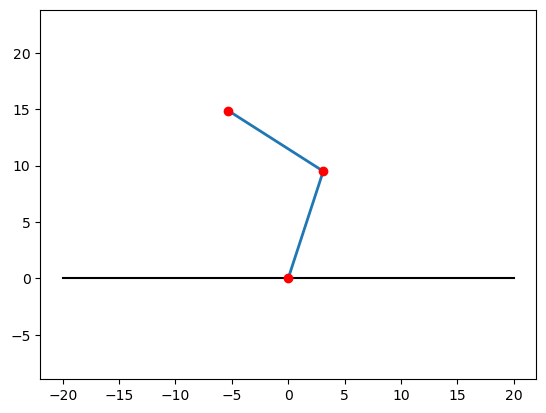


target:  [-7.23095599 11.24761332]
solution:  [-7.165564584271079, 11.375323705506393]
error:  0.14347814692620992


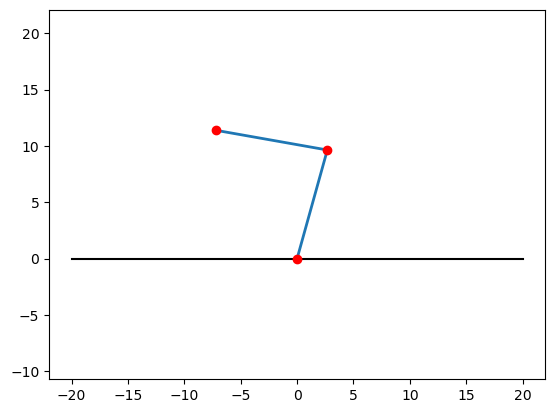


target:  [-8.96578992 10.41469245]
solution:  [-9.139418834088977, 10.238915851920616]
error:  0.24707167430882274


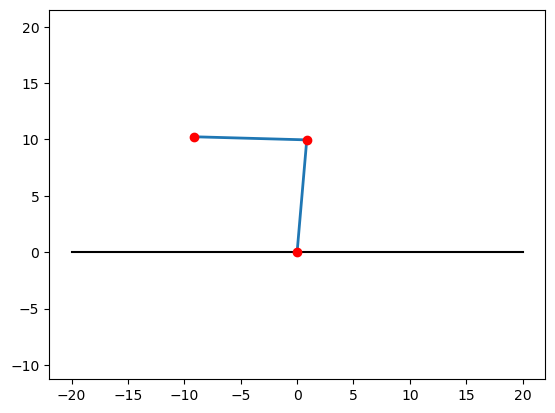


target:  [-3.05900033 17.04347112]
solution:  [-3.1994578089747545, 17.170487356367524]
error:  0.1893711400198628


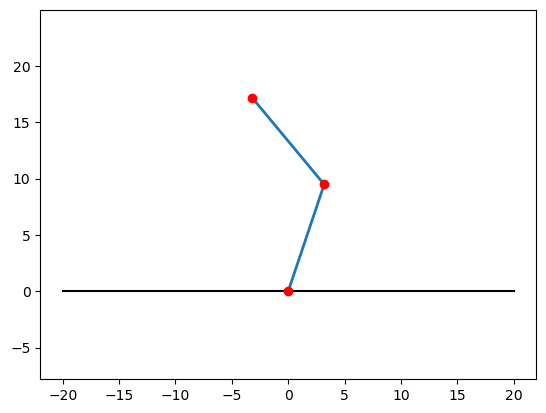


target:  [ 5.14881213 17.62278739]
solution:  [5.375151046711157, 17.497424310841197]
error:  0.25873771388131306


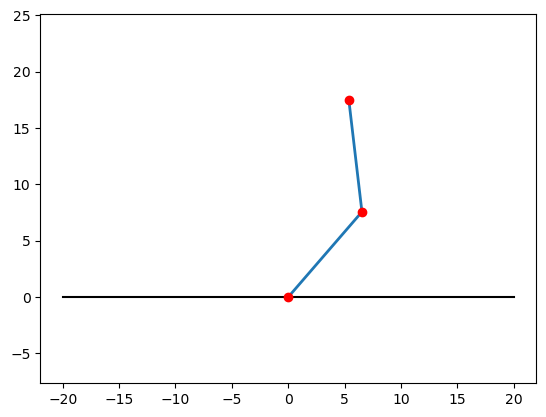


target:  [-3.33989872 11.17880543]
solution:  [-3.2946656643644454, 11.030863250302719]
error:  0.15470267208902366


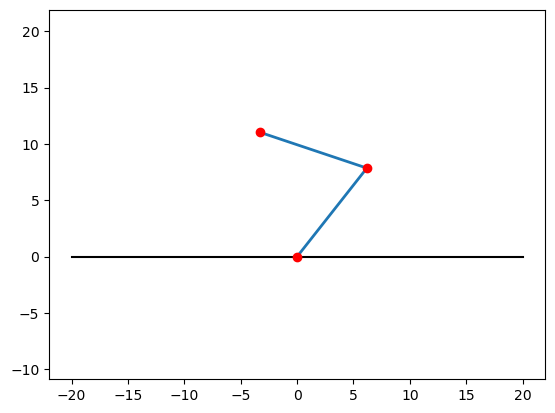


target:  [-3.33404378 15.99408071]
solution:  [-3.3723621377751063, 16.223964516932917]
error:  0.23305549312571786


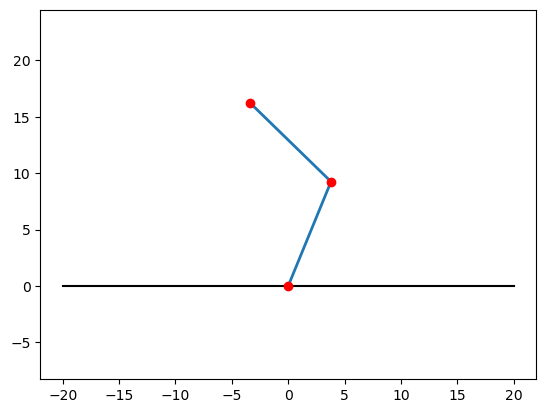


target:  [-2.14734143  1.20685965]
solution:  [-2.1749767799817477, 1.376563456548018]
error:  0.17193921373549392


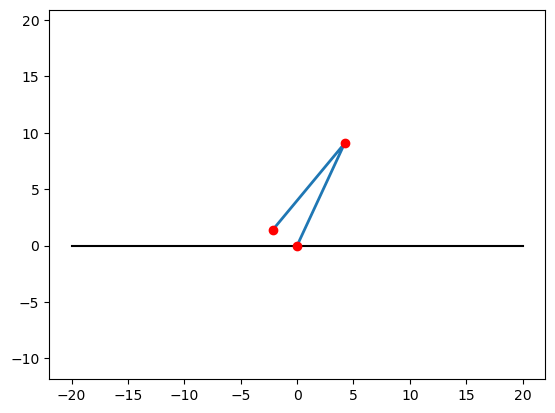


target:  [-7.21293766 16.85905922]
solution:  [-7.819003506911728, 16.306247545409867]
error:  0.8203149088351346


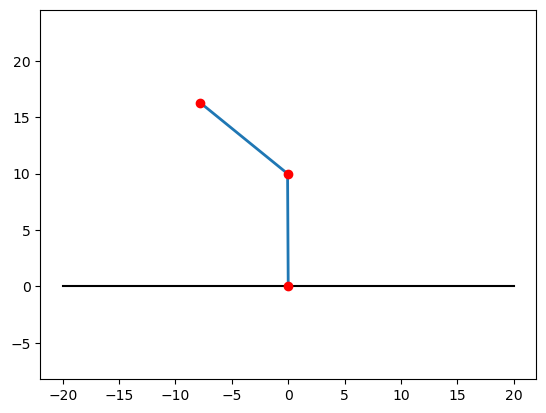


target:  [-6.49279111  5.57405281]
solution:  [-6.414246024043594, 5.774452272140294]
error:  0.21524235935153715


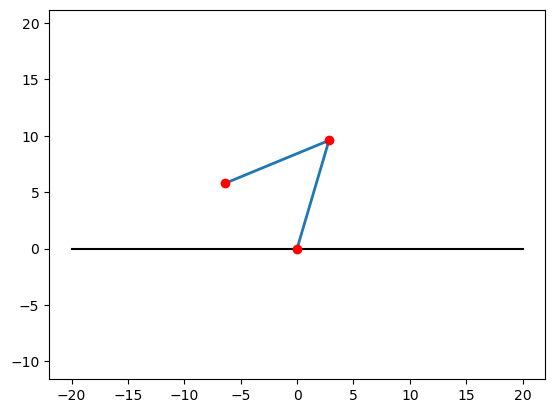


target:  [-3.46182586 13.50243524]
solution:  [-3.0429739574982557, 13.497748836514193]
error:  0.41887812192626533


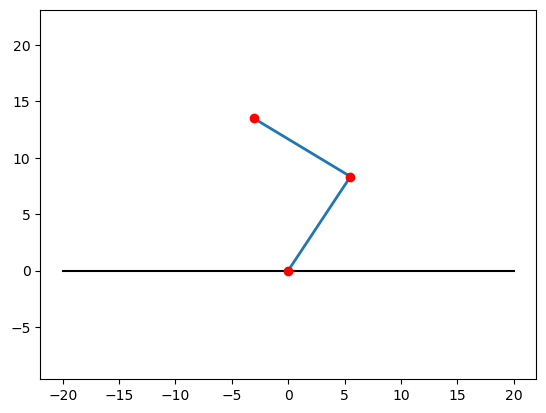


target:  [-7.69647724  5.26556743]
solution:  [-7.833540166831469, 4.998440243222242]
error:  0.30023853792623273


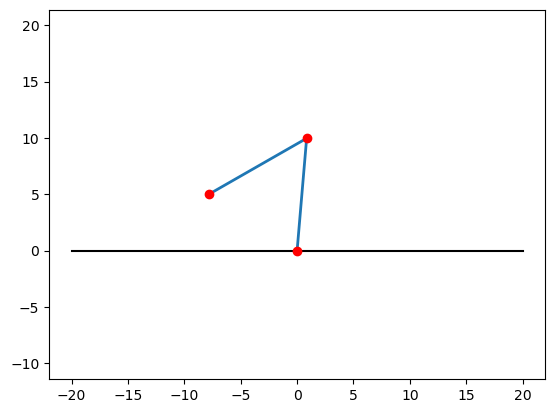


target:  [-4.2739868   9.15934603]
solution:  [-4.411739934127267, 9.183642627947302]
error:  0.13987941871916604


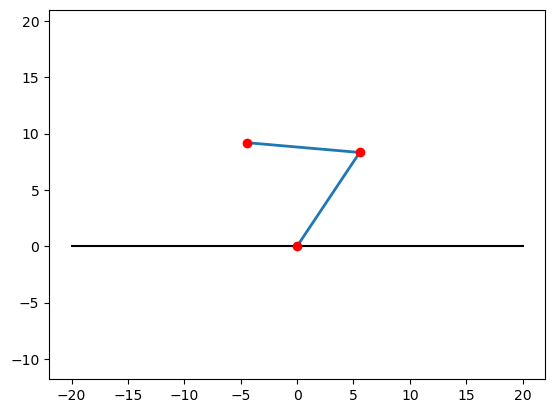


target:  [-3.06070459 11.40054064]
solution:  [-3.0166153691444633, 11.222359303928771]
error:  0.1835550244291442


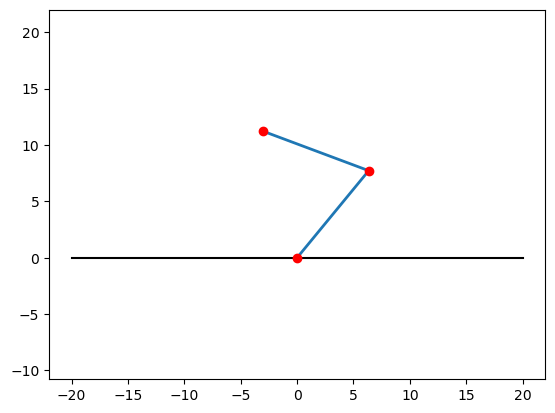


target:  [-0.04200452  0.02274446]
solution:  [-0.04553723813862387, 0.024202684409683428]
error:  0.0038218515933729717


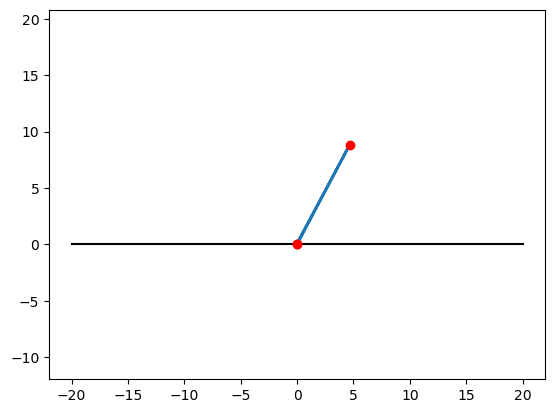


target:  [-4.25361685  1.60505251]
solution:  [-4.197180833039069, 1.7740774371579437]
error:  0.1781977814499031


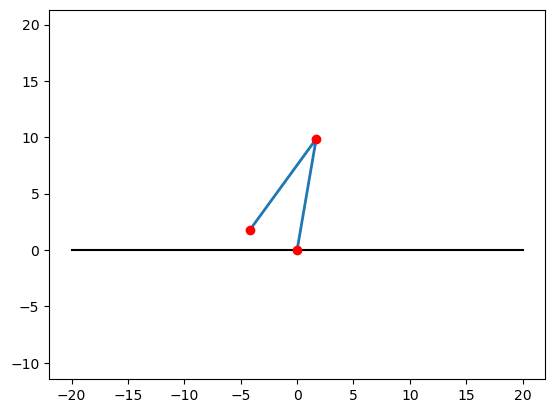


target:  [-4.86755361  1.33773162]
solution:  [-4.850282893776943, 1.0746636909194667]
error:  0.26363424226895954


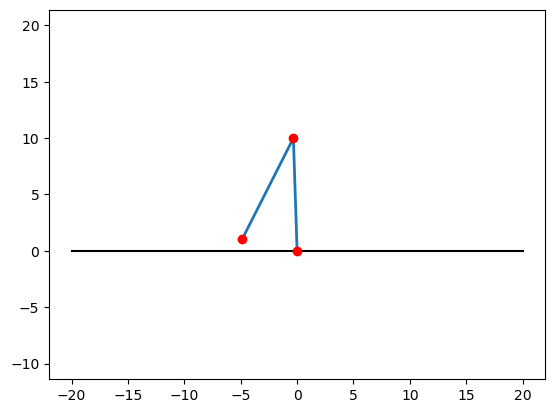


target:  [-8.8071784  14.28135119]
solution:  [-9.358348644064778, 13.829300938373002]
error:  0.7128380380516354


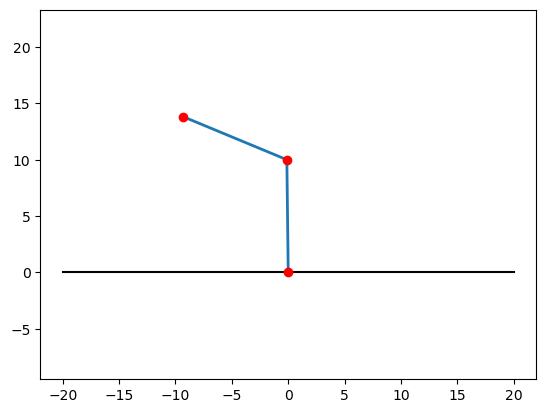


target:  [-2.4812426  14.49529786]
solution:  [-2.3211262856741213, 14.598211349051857]
error:  0.19033764293766164


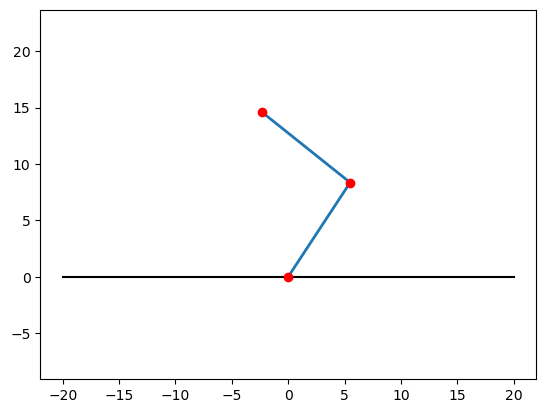


target:  [-6.66853819 14.46104819]
solution:  [-6.647278829650332, 14.495630267639026]
error:  0.04059409385430068


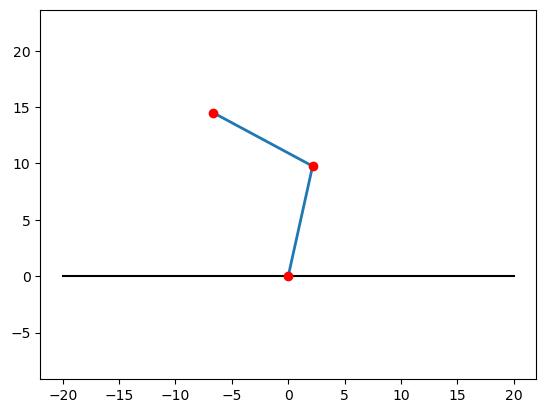


target:  [-8.57285251  5.02010294]
solution:  [-8.75747171699015, 4.261009492048324]
error:  0.7812215528197376


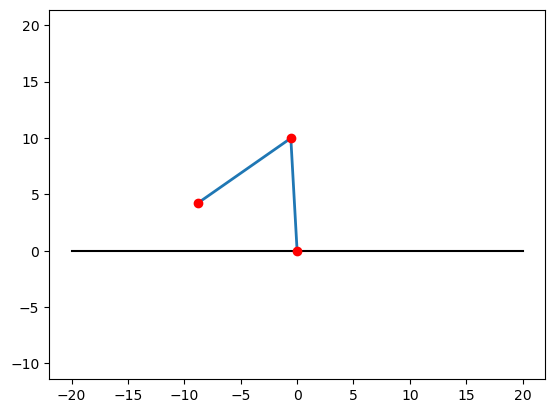


target:  [-4.77862852  9.08443977]
solution:  [-4.888675355859682, 9.20515030935423]
error:  0.1633442412753902


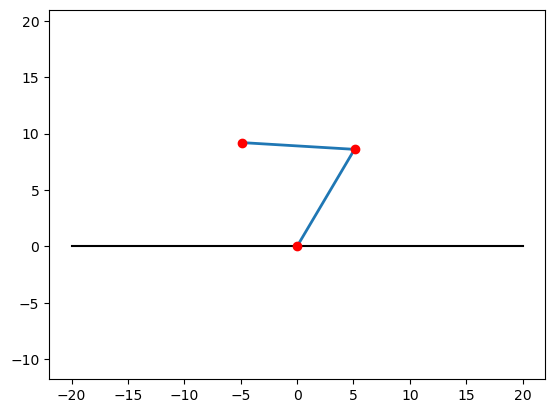


target:  [-5.87646488  7.31129006]
solution:  [-5.830921531610557, 7.608654768839856]
error:  0.3008321240847495


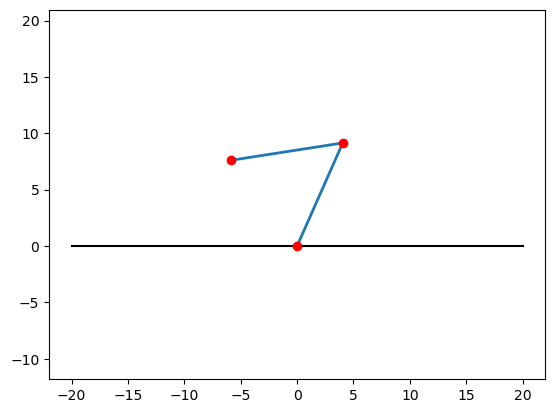


target:  [-3.1229626  11.09567646]
solution:  [-3.1420751182939037, 10.92366177181546]
error:  0.17307322500016645


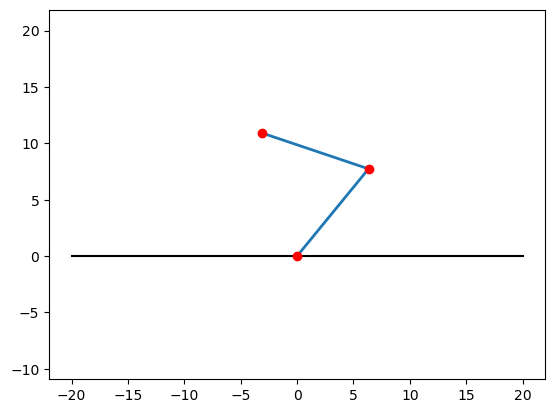


target:  [ 1.05373441 17.81911825]
solution:  [1.218432325956027, 17.86374534748642]
error:  0.17063698844270014


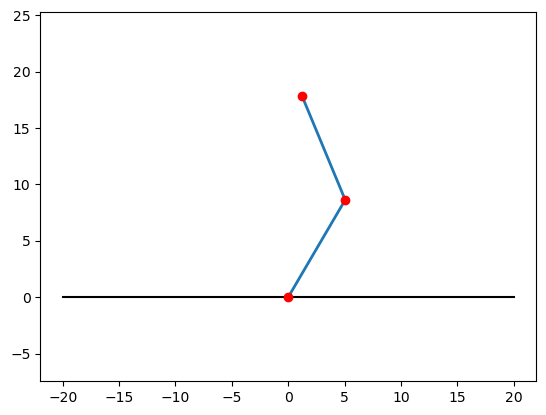


target:  [-5.96073048  3.59603794]
solution:  [-5.972387954460522, 3.5741516671691516]
error:  0.024797292836162298


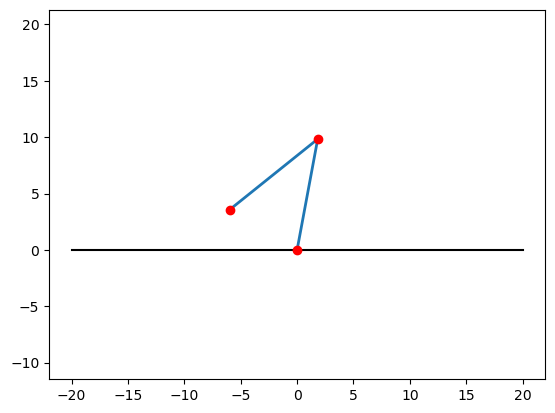


target:  [-2.40275409  0.71389487]
solution:  [-2.6043298481953743, 0.7973945799153466]
error:  0.21818567406439474


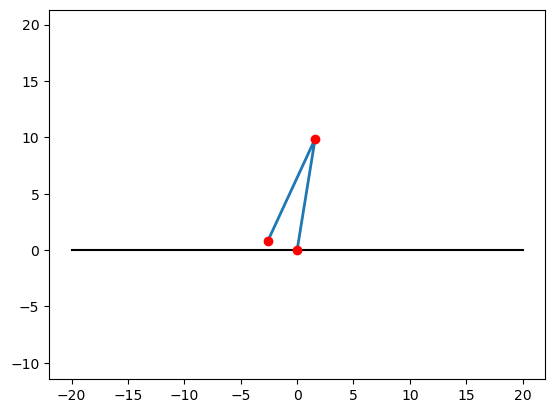


target:  [-3.91776488 10.13186733]
solution:  [-3.9483289616597954, 10.034509679139518]
error:  0.10204251784863165


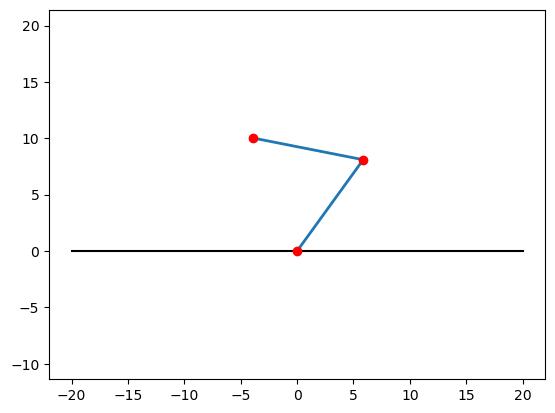


target:  [-0.00316967  0.00219622]
solution:  [-0.016595046800988555, 0.008953652322674088]
error:  0.015030091065327888


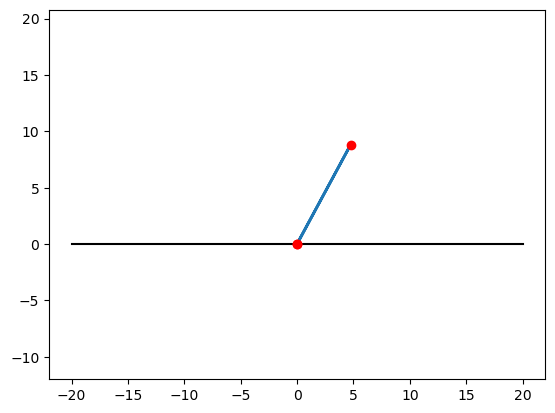


target:  [ 6.25863663 17.24056745]
solution:  [6.579511910628267, 17.025875593615883]
error:  0.38607452348899685


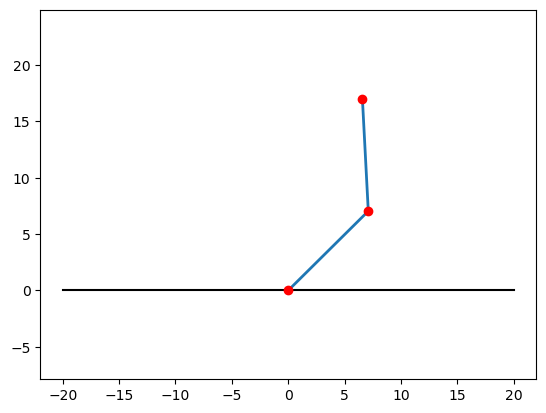


target:  [-9.00091122 11.40462094]
solution:  [-9.107511104680123, 11.18441695277705]
error:  0.24464940220194417


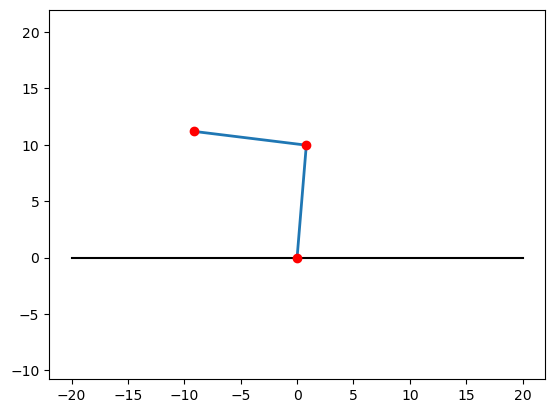


target:  [-3.21835496  6.31067453]
solution:  [-3.4333331945350603, 6.156030803604462]
error:  0.2648213054658211


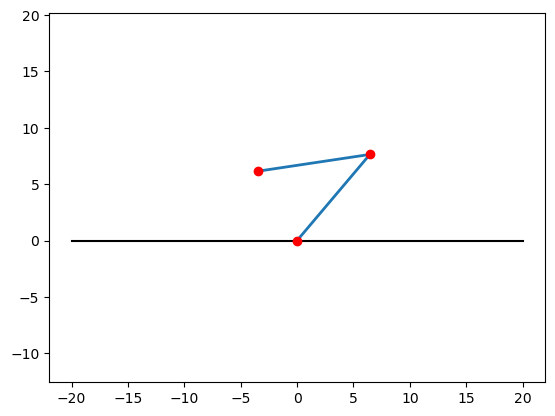


target:  [-2.74244325 11.94529937]
solution:  [-2.59747520150259, 11.717632438475446]
error:  0.2699036241085927


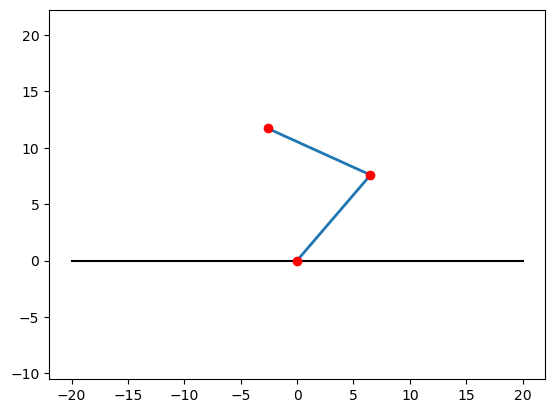


target:  [-5.62768035  2.40344283]
solution:  [-5.634749251213906, 2.4812734772807383]
error:  0.07815100554758306


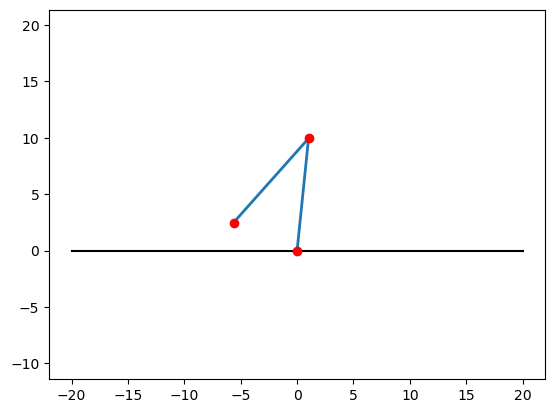


target:  [-6.20411258 11.9624552 ]
solution:  [-5.877966637584747, 12.081883630912843]
error:  0.34732452308633915


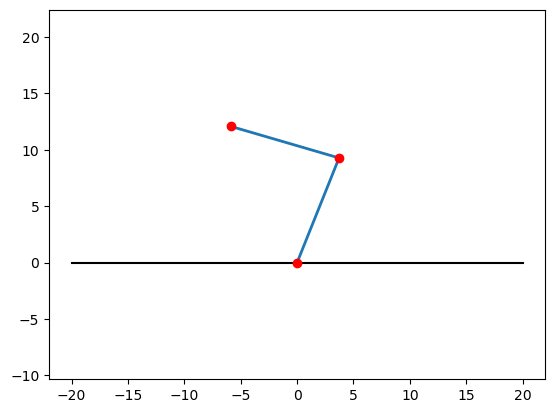


target:  [ 6.15862394 17.18971662]
solution:  [6.437764365222721, 17.031934347476273]
error:  0.32064718969259176


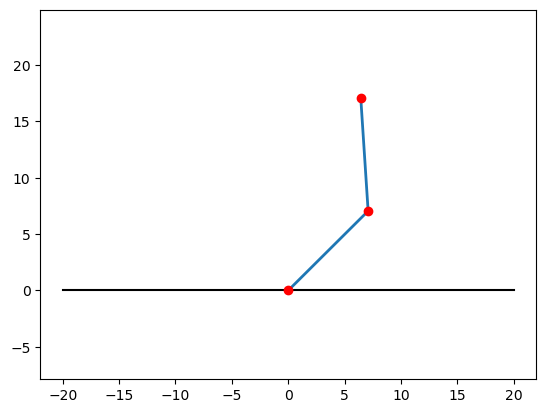


target:  [-2.71011326  0.67817952]
solution:  [-2.879469695438541, 0.7159906919464909]
error:  0.17352604193737706


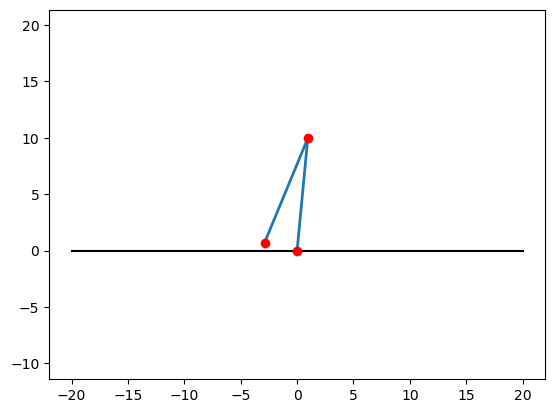


target:  [-8.28776034 12.70060602]
solution:  [-8.095725627664034, 12.592751459919317]
error:  0.22024971776339608


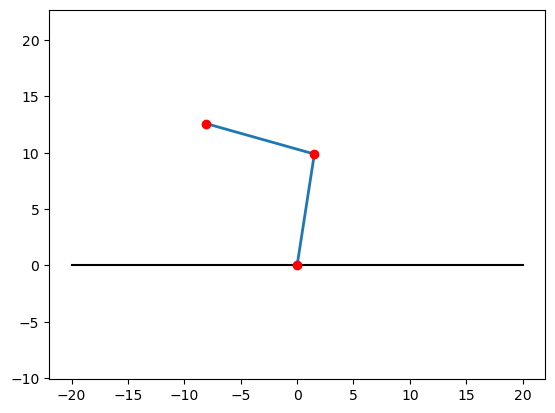


target:  [-4.15487588  3.2357776 ]
solution:  [-4.1521138487673825, 3.3785850184340553]
error:  0.14283412622435893


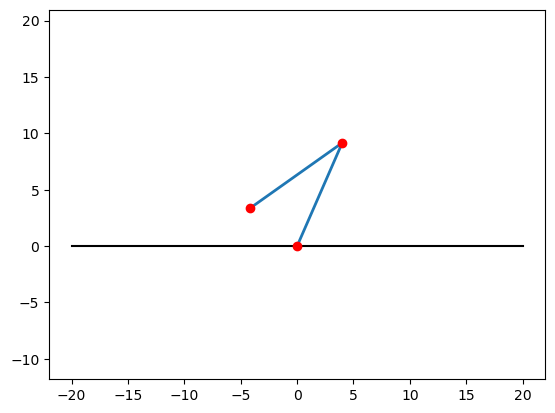


target:  [-4.52932611  2.43612386]
solution:  [-4.419067007978947, 2.637212669148381]
error:  0.22933333181159193


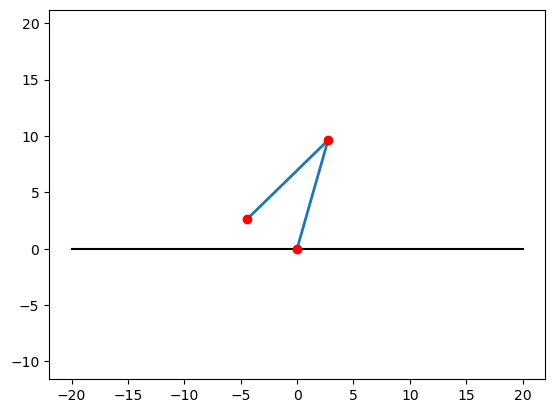


target:  [-6.44916626 11.00091144]
solution:  [-6.357942801902546, 11.178335805587887]
error:  0.1995021924055707


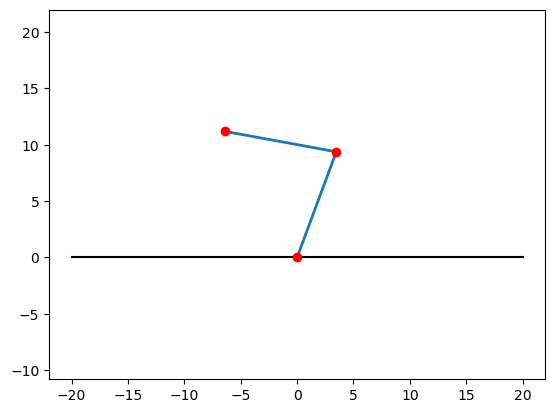


target:  [-6.65245957  8.88937859]
solution:  [-6.719363608088043, 9.137567902374947]
error:  0.2570487952817697


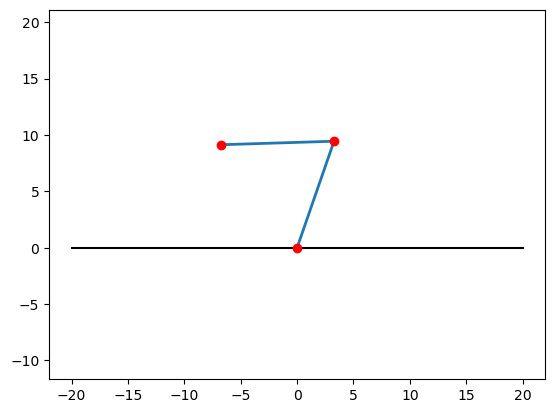


target:  [-3.82247811  8.4946137 ]
solution:  [-4.045128767780016, 8.436148056911952]
error:  0.23019892643442535


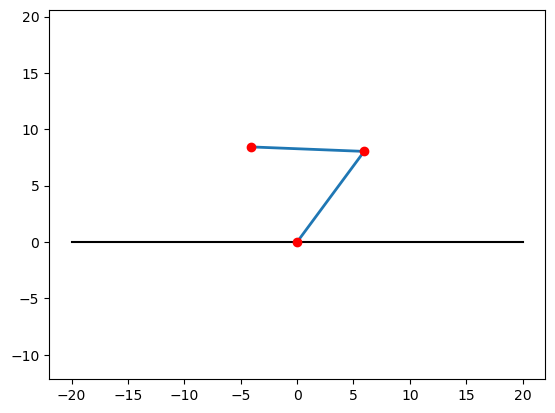


target:  [-5.03956197  6.73577387]
solution:  [-4.989322234316243, 6.977118766678424]
error:  0.24651854262719042


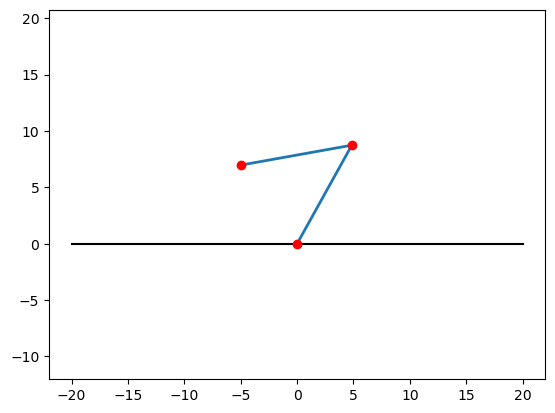


target:  [-2.44460867 12.36677254]
solution:  [-2.2033737529713413, 12.076979167096116]
error:  0.3770603177660496


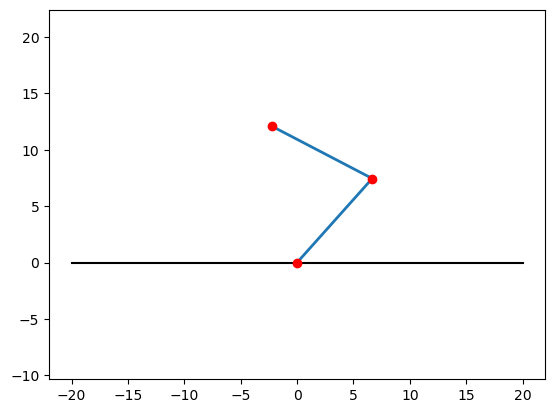


target:  [-7.67112334 10.62599215]
solution:  [-7.726717857335763, 10.72661911459432]
error:  0.11496319598835346


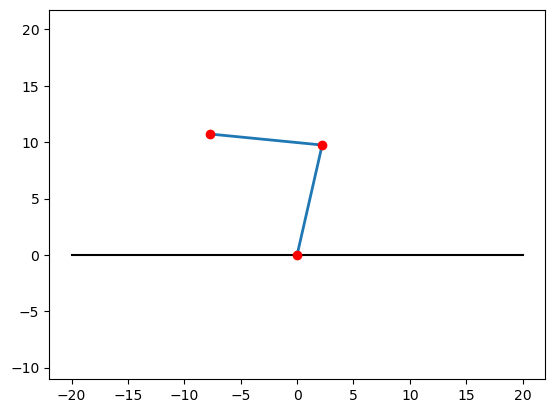


target:  [-4.2050196   4.42306833]
solution:  [-4.189490327662878, 4.557998557997874]
error:  0.13582092911115248


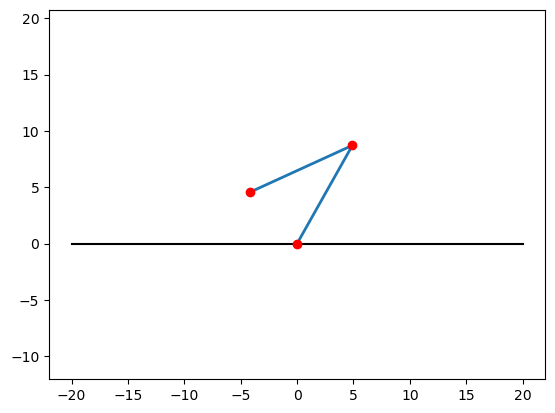


target:  [-2.92676976  2.06823268]
solution:  [-2.834916550321914, 2.2206160276609292]
error:  0.17792609973645815


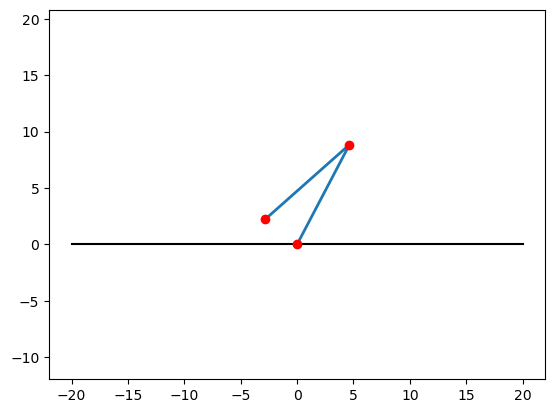


target:  [-4.59096456 12.83594443]
solution:  [-3.8964230074029587, 12.745977774232202]
error:  0.700344178754665


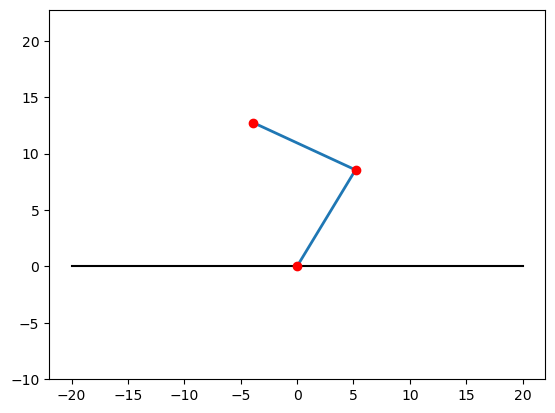


target:  [-0.34111216  0.23676162]
solution:  [-0.29135256374893537, 0.1522585510006138]
error:  0.09806521168922182


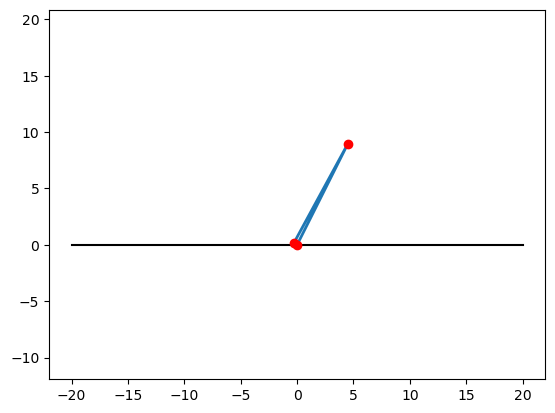


target:  [-2.50047217  0.70264086]
solution:  [-2.6919332181507825, 0.77459171378454]
error:  0.20453425189358215


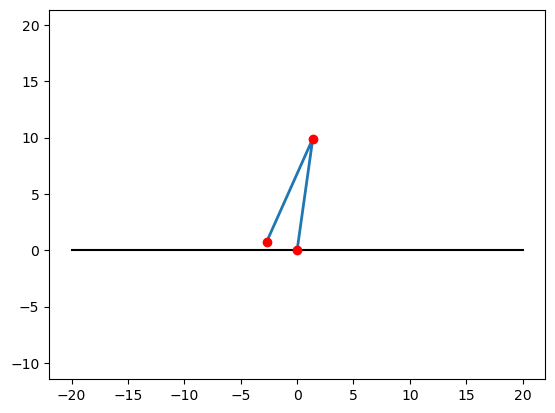


target:  [-5.38768939  5.99285096]
solution:  [-5.131366587937272, 6.318805078851852]
error:  0.4146654869727465


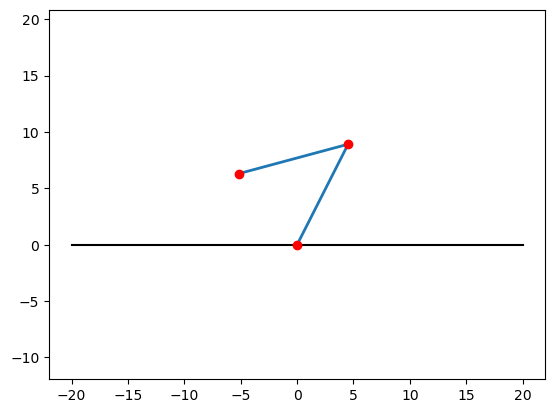


target:  [ 0.33131991 17.15702731]
solution:  [0.39263681143997964, 17.293344727179658]
error:  0.1494730727008649


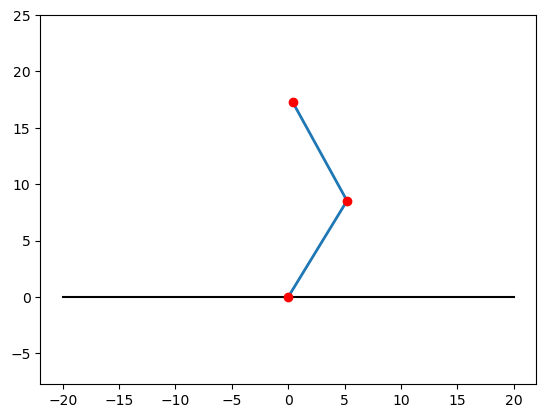


target:  [-3.64677969 14.34149962]
solution:  [-3.39657695716849, 14.496655784394859]
error:  0.2944059144424896


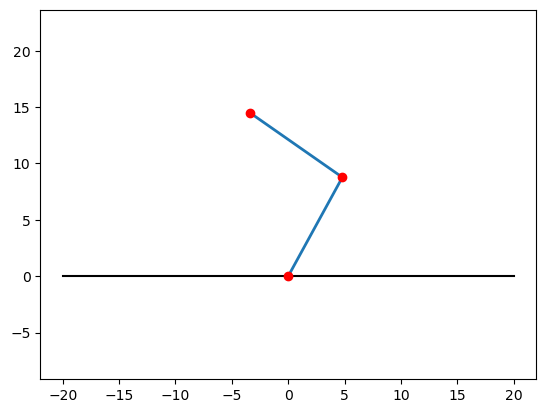


target:  [-1.03047955  1.07424503]
solution:  [-1.0724945858318664, 0.9557556472882176]
error:  0.12571792633516038


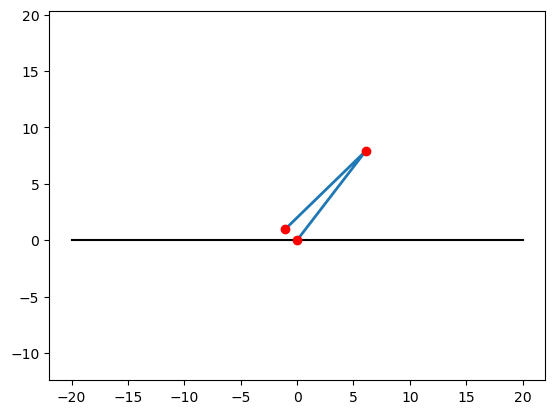


target:  [-3.96746159  9.8788808 ]
solution:  [-4.038917155185177, 9.80559379198873]
error:  0.10235664852298508


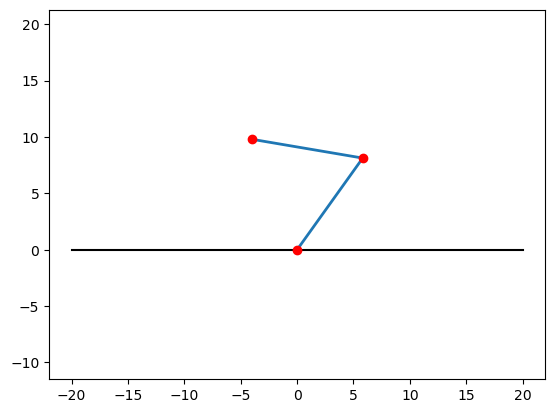


target:  [-2.92284017 17.28340398]
solution:  [-3.0706964870351783, 17.37113019564201]
error:  0.17192260280916596


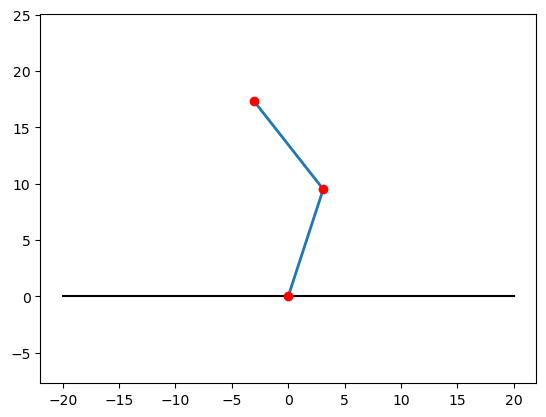


target:  [-7.32637337  7.85830246]
solution:  [-7.290007433318076, 8.097099442568823]
error:  0.24155015883619987


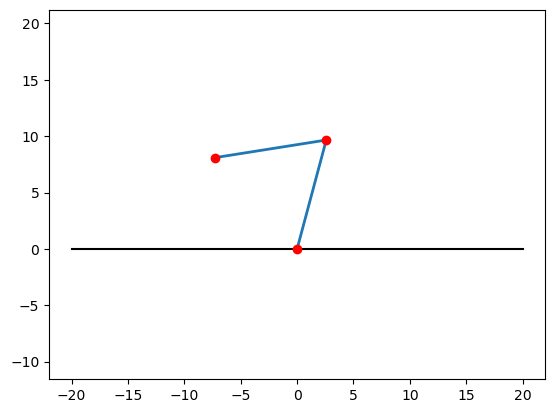


target:  [-2.13960245 13.40801935]
solution:  [-1.8711707901243635, 13.231452273266253]
error:  0.3212965722244394


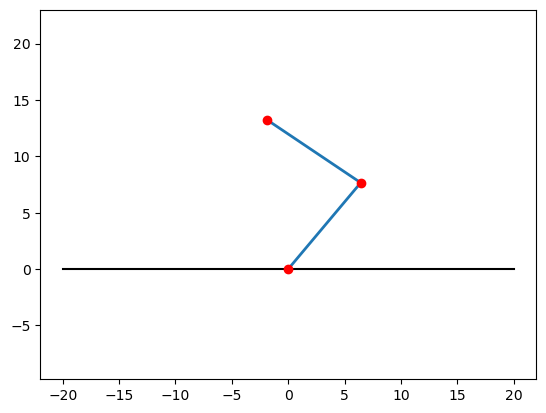


target:  [-0.54506901 17.87851781]
solution:  [-0.4845230118556634, 17.833208352523716]
error:  0.07562251527910353


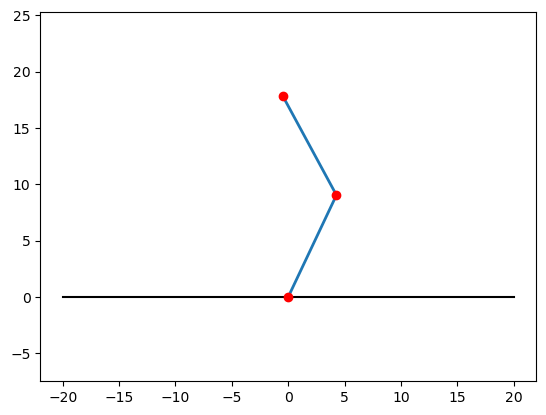


target:  [-3.39529002 17.90171201]
solution:  [-3.6477275127720885, 17.820424405350582]
error:  0.265202495141425


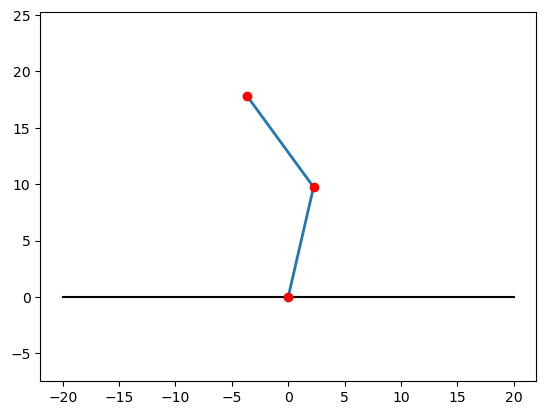


target:  [ 3.04613996 18.15998024]
solution:  [3.423248063957788, 17.970482087841496]
error:  0.4220427377708528


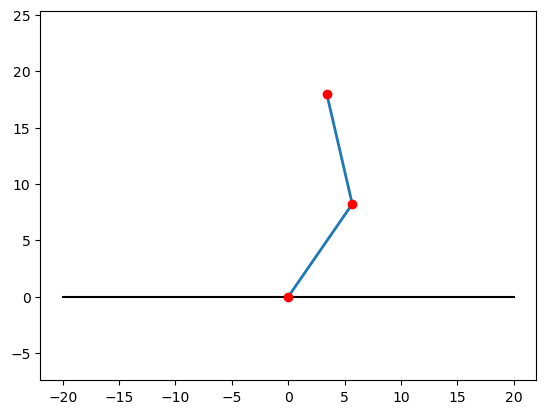


target:  [-7.79504831  6.11472332]
solution:  [-7.780839275775248, 6.0975625503198145]
error:  0.02227978041891582


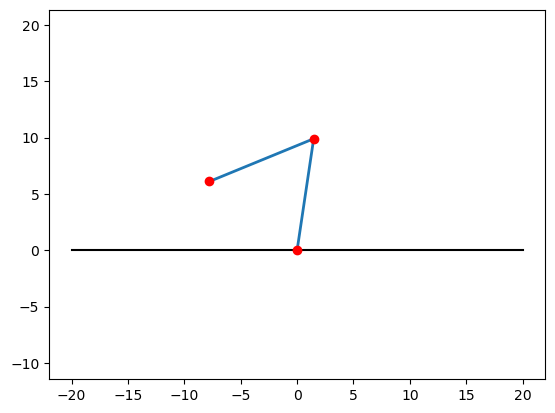


target:  [-1.99588415  0.91511354]
solution:  [-2.2055988777222995, 1.0267585149756542]
error:  0.23758129037821807


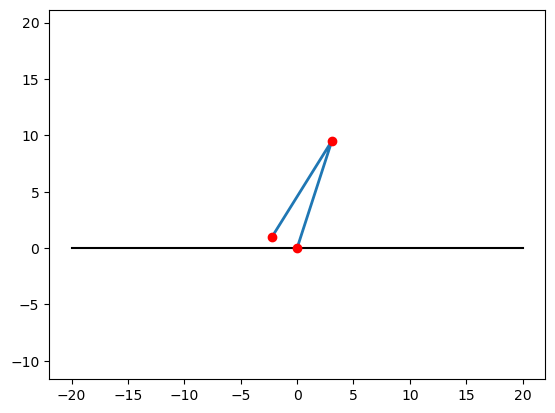


target:  [-5.7445232   6.04224564]
solution:  [-5.45179272736044, 6.398821752608438]
error:  0.46134331349469065


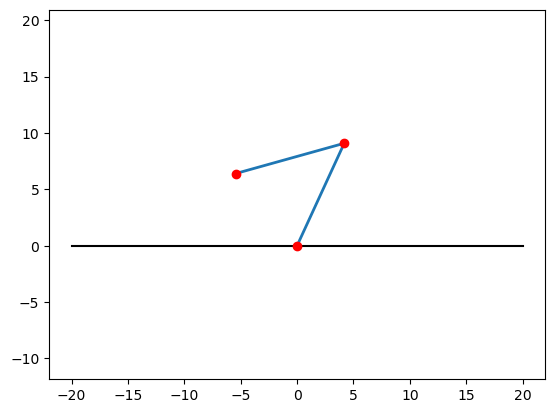


target:  [ 2.91942806 17.12661671]
solution:  [3.0787652653248796, 17.198473941537202]
error:  0.174790750705961


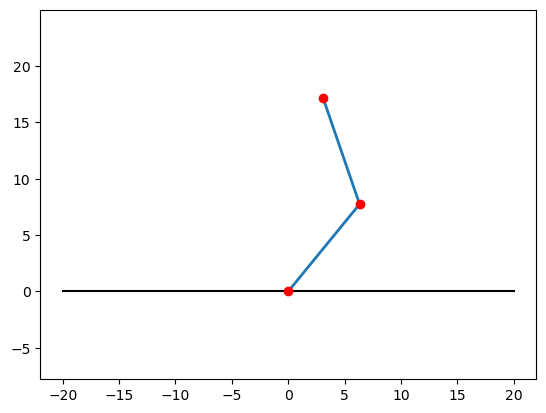


target:  [-8.3867435   7.08995506]
solution:  [-8.155177555837415, 7.202448368561297]
error:  0.2574442267911267


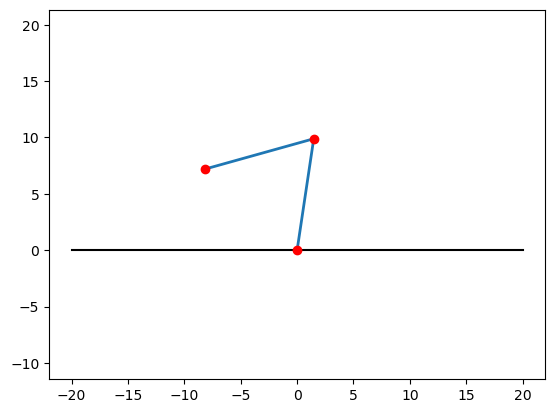


target:  [-8.85947024  8.19359291]
solution:  [-8.859216195688788, 8.128307537308238]
error:  0.06528586369180024


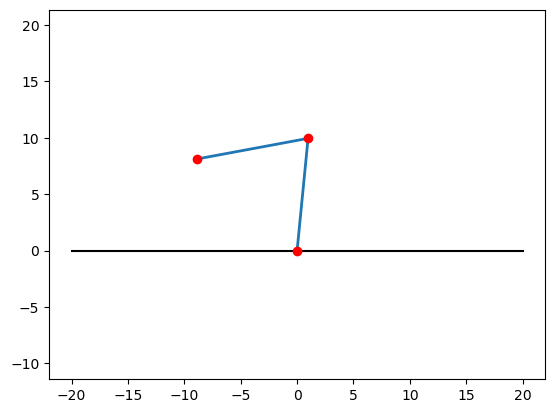


target:  [-9.55440465 10.80036548]
solution:  [-9.764175523948476, 10.419878763491429]
error:  0.4344812558079069


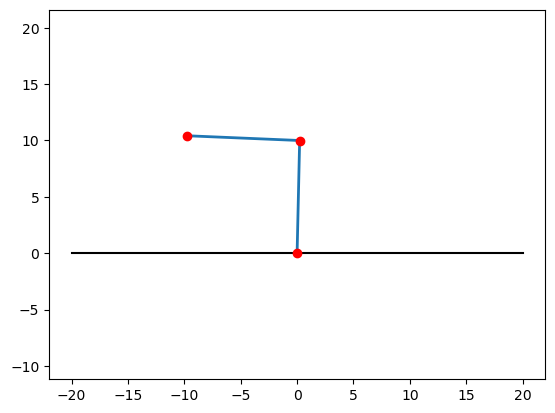


target:  [-1.61431463 17.92705362]
solution:  [-1.6457480841029941, 17.853641533129107]
error:  0.07985860187053252


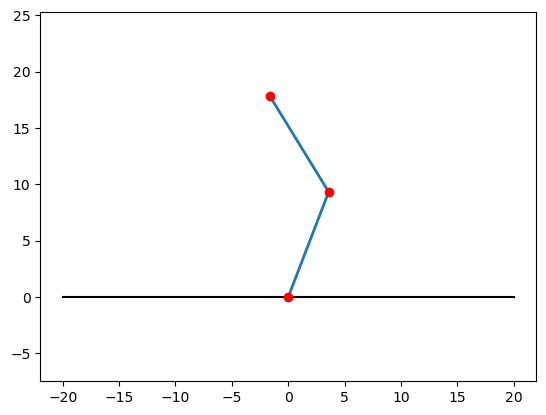


target:  [-1.89910087 14.70348637]
solution:  [-1.7962975050182273, 14.770946404312998]
error:  0.12296092404327362


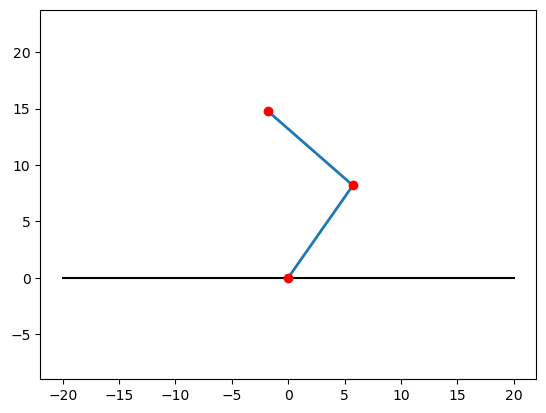


target:  [-2.57573471  1.9194636 ]
solution:  [-2.500932240366036, 2.0327592744410845]
error:  0.1357619917931292


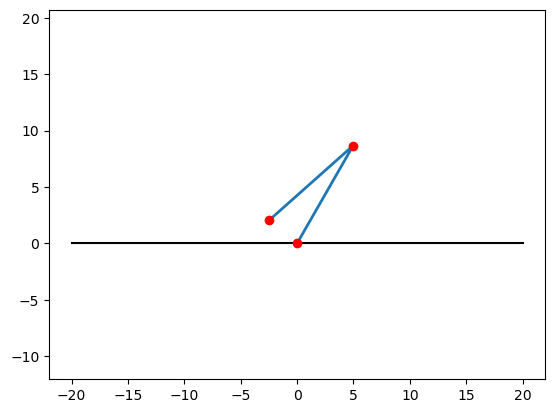


target:  [-4.98592167  7.02902142]
solution:  [-4.988728652717744, 7.249931385284465]
error:  0.22092780038367016


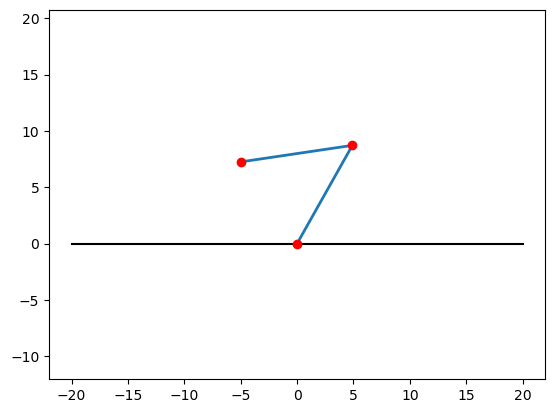


target:  [-5.09998865 13.59393619]
solution:  [-4.555059693548934, 13.631540859422802]
error:  0.5462249314512369


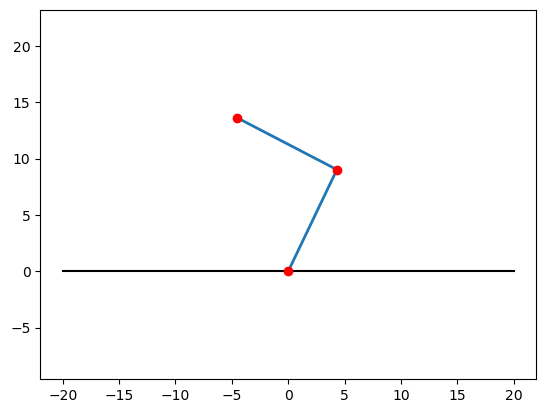


target:  [-5.19319282  3.14238113]
solution:  [-5.144472454898535, 3.2431483799058354]
error:  0.11192726173294054


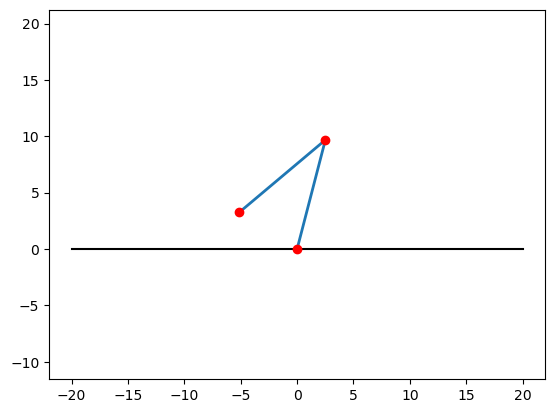


target:  [-5.11529315  2.18038347]
solution:  [-5.092509316904678, 2.3727971516095483]
error:  0.19375790802840293


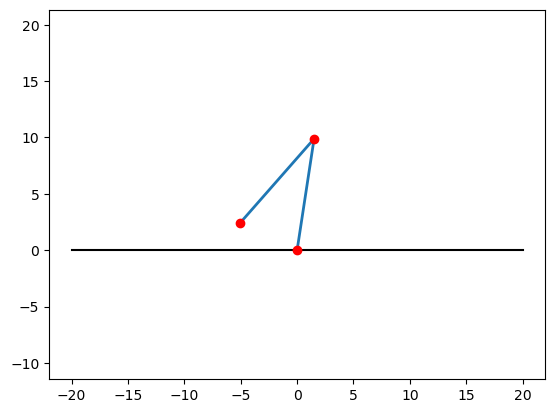


target:  [-1.78705701 15.79560539]
solution:  [-1.764652611109402, 15.948542618582012]
error:  0.15456957319443432


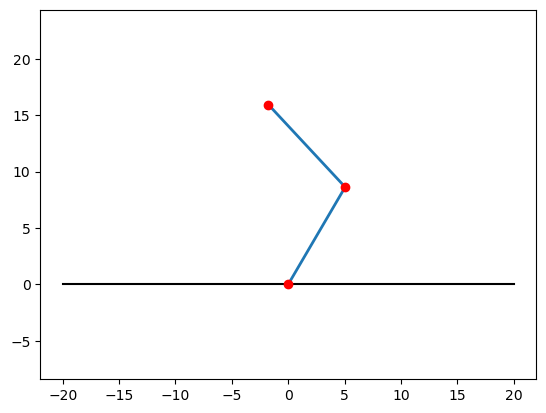


target:  [-1.62793973  2.03648769]
solution:  [-1.7887704380292258, 1.829120305583121]
error:  0.26242665571683127


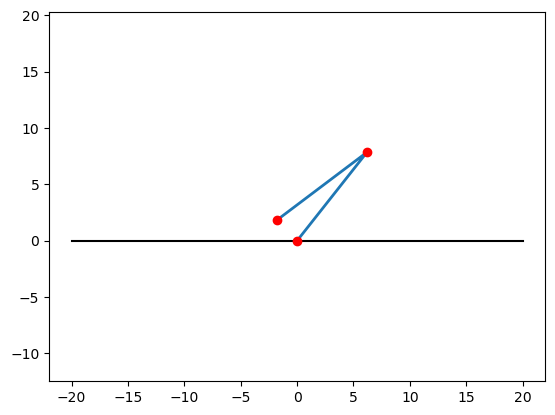


target:  [-9.85882976 10.1017381 ]
solution:  [-10.091351857409036, 9.628311463141925]
error:  0.5274460245930033


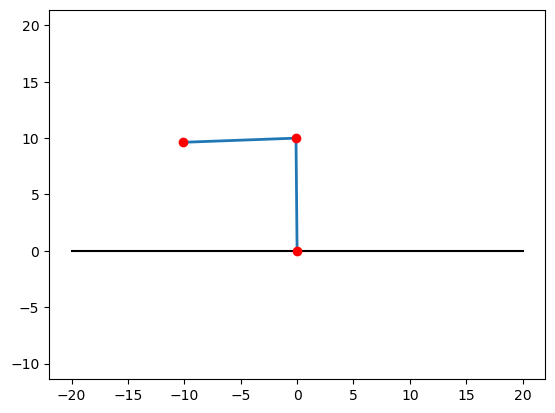


target:  [-6.37792679  5.73706074]
solution:  [-6.237855743746579, 5.994954025648264]
error:  0.29347715725728973


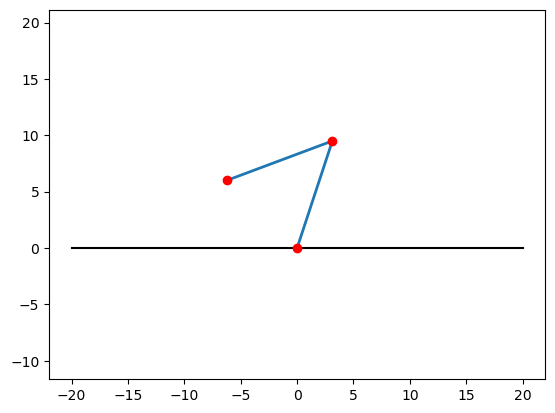


target:  [-0.09431832  0.07334106]
solution:  [-0.09122395619787227, 0.049241584956039475]
error:  0.02429732019352894


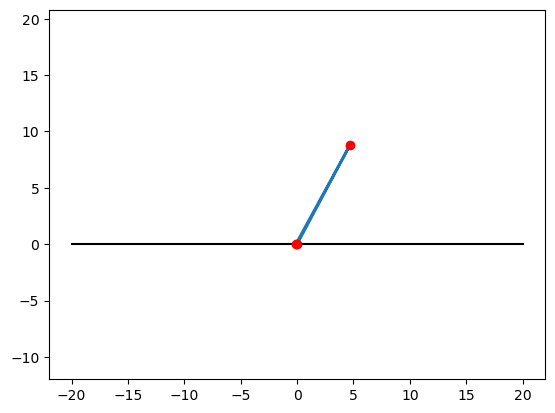


target:  [-3.69430106  2.15953198]
solution:  [-3.5286898268313998, 2.391288130581387]
error:  0.28484731876188846


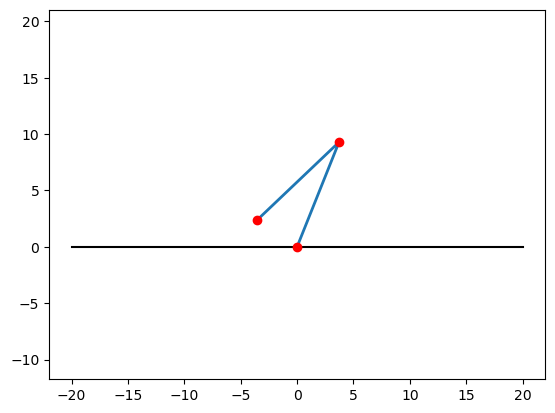


target:  [-3.08687371  0.91070309]
solution:  [-3.224690290416932, 0.9421176584837809]
error:  0.1413516366915389


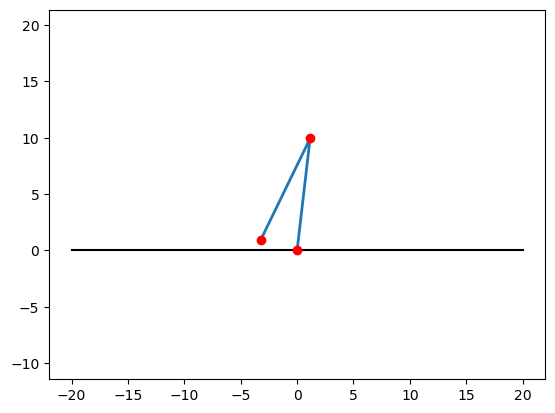


target:  [-9.38833786 10.13158498]
solution:  [-9.59318321697526, 9.830584160278795]
error:  0.36409217334338734


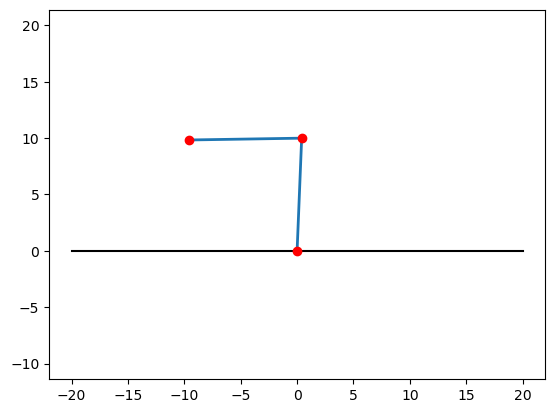


target:  [-3.93059841 14.52564359]
solution:  [-3.708359951881312, 14.706799737227467]
error:  0.28671846922745786


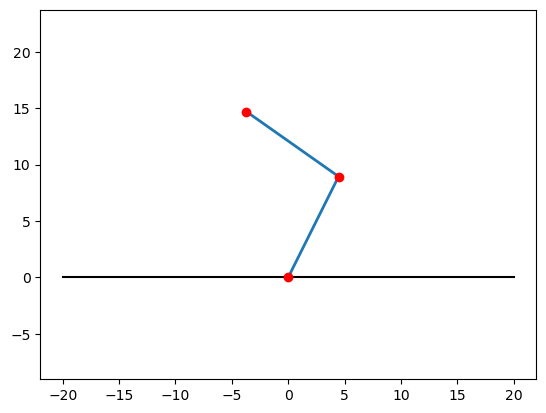


target:  [-7.7886585  11.25958513]
solution:  [-7.778810079026891, 11.317810920641367]
error:  0.0590528072674441


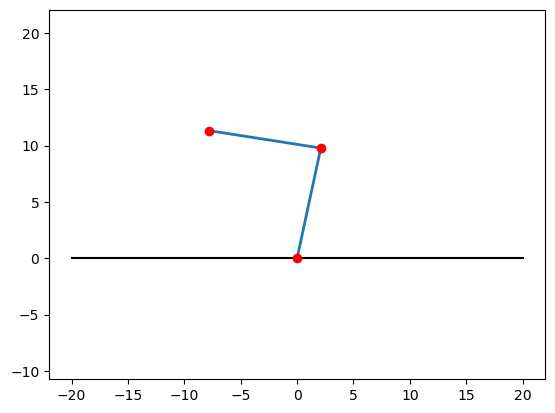


target:  [-8.15598699 11.36084487]
solution:  [-8.171690928133021, 11.350050255106519]
error:  0.01905616033032872


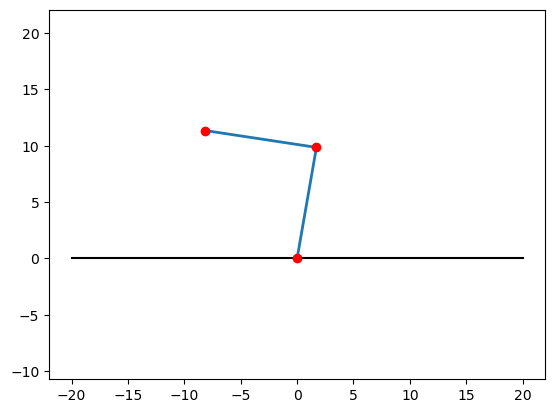


target:  [-7.56049592  3.88798736]
solution:  [-7.552435013822656, 3.48755526965292]
error:  0.40051322085112545


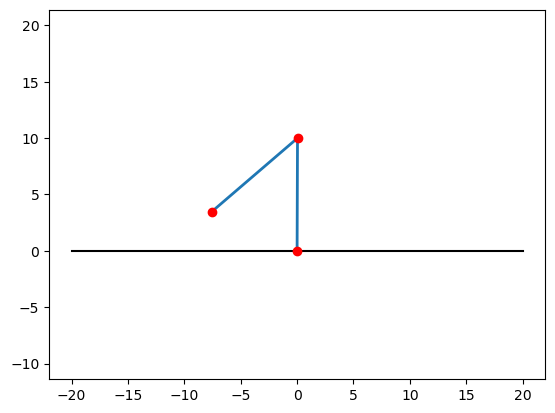


target:  [-1.04412851  0.25929247]
solution:  [-1.0391961684238562, 0.2828856010105554]
error:  0.024103191478452336


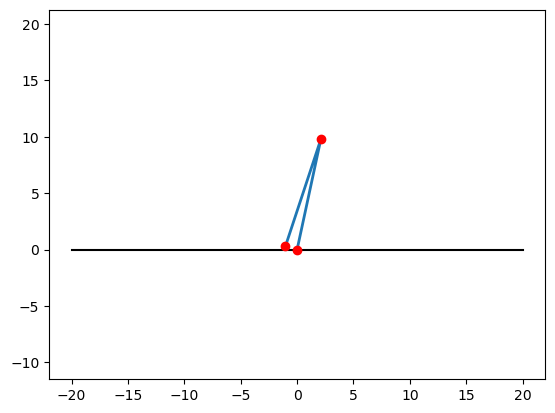


target:  [-2.88444802  1.35517908]
solution:  [-2.964438046839641, 1.5467612212475057]
error:  0.20761050242794463


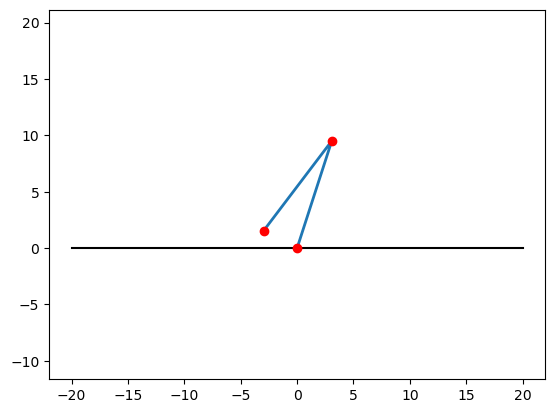


target:  [-3.15652894  0.79693693]
solution:  [-3.2881195894248316, 0.7754550786929961]
error:  0.13333255234868988


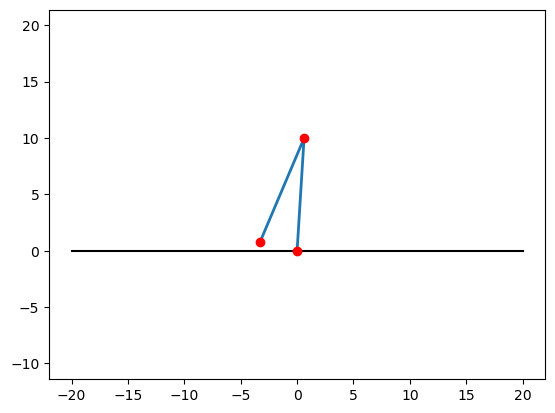


target:  [-2.74077237  5.11060533]
solution:  [-2.8583376022335027, 4.855916242342552]
error:  0.28051402114944285


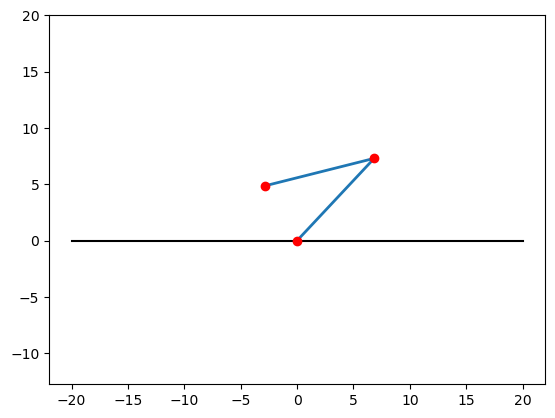


target:  [-7.91415644  6.69666701]
solution:  [-7.720770269020516, 6.84855471865624]
error:  0.24590259359783026


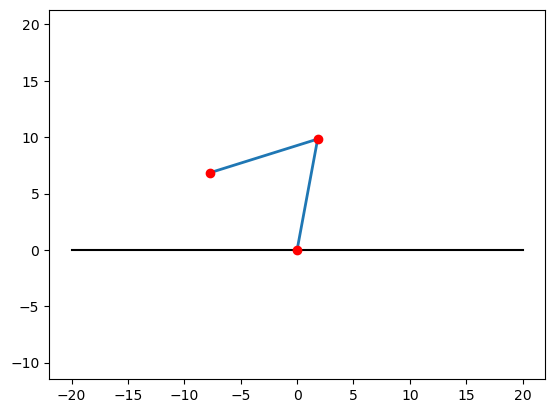


target:  [-5.96297237  9.28077243]
solution:  [-6.030917918568216, 9.514811305913707]
error:  0.24370226458362834


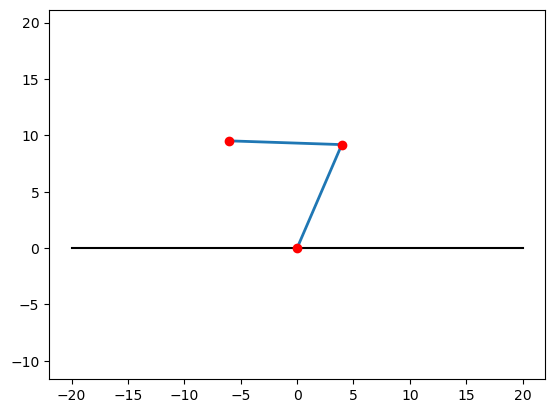


target:  [ 1.31430392 16.53952924]
solution:  [1.3313330414575075, 16.75657123945766]
error:  0.21770902301593223


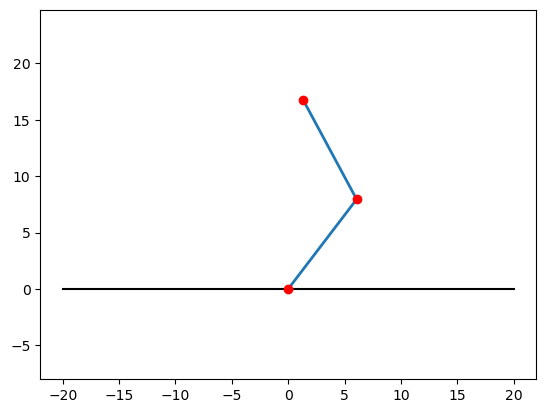


target:  [-3.44586836  3.64380691]
solution:  [-3.511137291735629, 3.679230065222227]
error:  0.07426192017341539


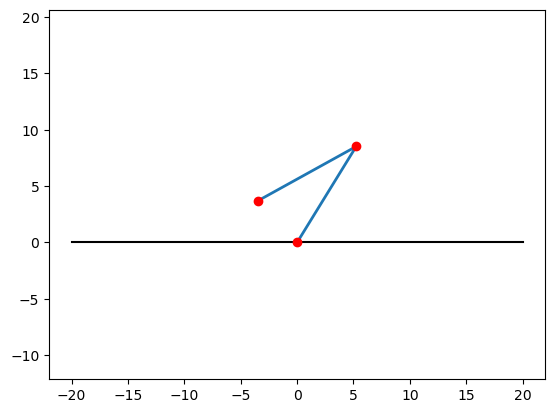


target:  [-4.54857031 13.55888836]
solution:  [-4.038257362850351, 13.602365044893329]
error:  0.5121616242470621


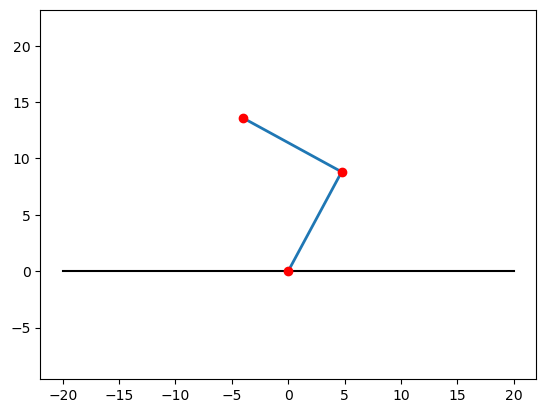


target:  [-0.82837619 14.21218263]
solution:  [-0.7948136595043485, 14.00188269980887]
error:  0.21296127439808277


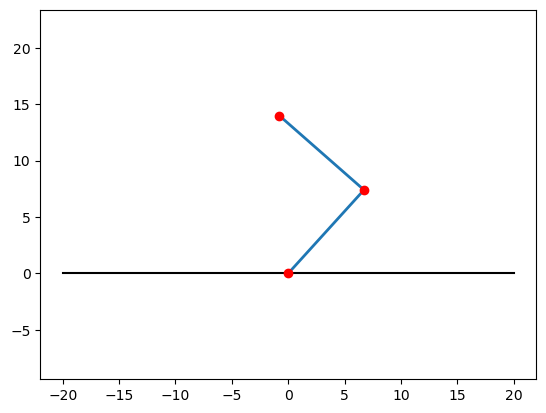


target:  [-7.30054699  5.22895474]
solution:  [-7.39474354101531, 5.11145484937456]
error:  0.15059619317770598


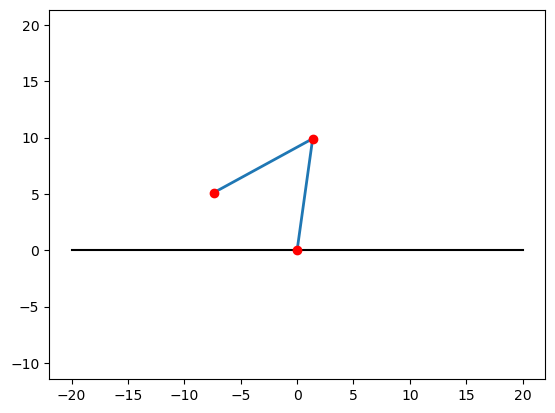


target:  [-3.24361519  1.53736453]
solution:  [-3.2419117250666436, 1.7896716230444971]
error:  0.252312846210976


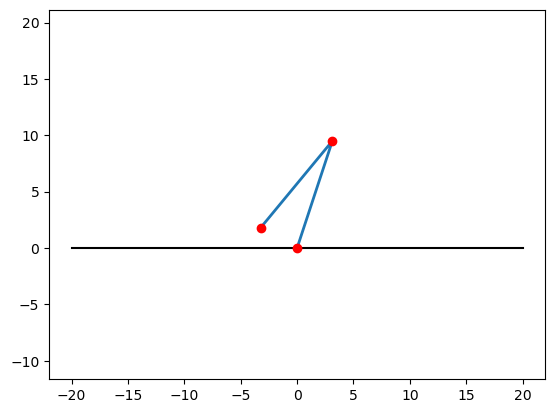


target:  [-5.24760339 17.42041317]
solution:  [-5.66593876880826, 17.21733651610283]
error:  0.4650210910271563


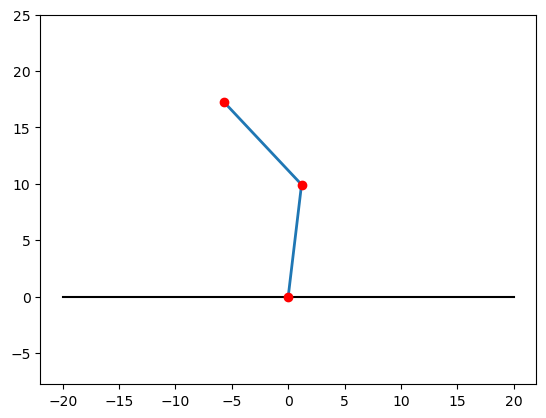


target:  [ 2.93631734 18.11319889]
solution:  [3.295129848932816, 17.953181890788578]
error:  0.39287639389366846


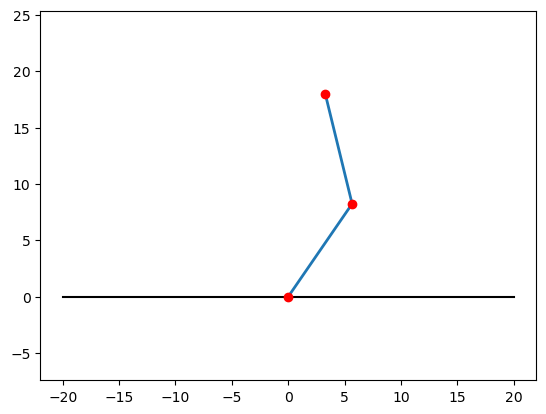


target:  [-3.75546913  0.95210755]
solution:  [-3.8368651887211636, 0.8329028886283645]
error:  0.1443435820253011


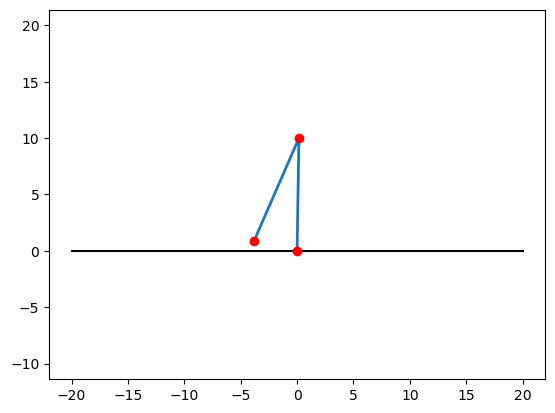


target:  [-2.76817038  1.34614172]
solution:  [-2.8586919657199066, 1.533862309676893]
error:  0.20840628199451783


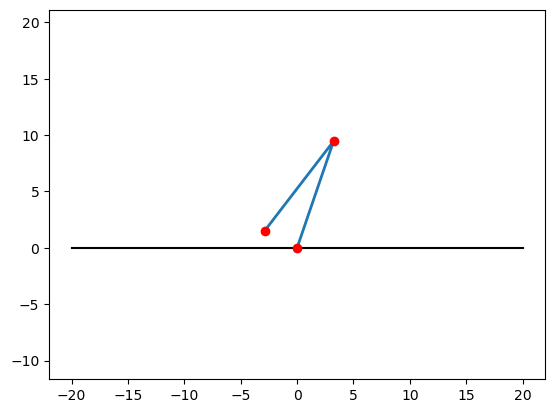


target:  [-3.93290345  6.49166813]
solution:  [-4.020982442813459, 6.528749093533164]
error:  0.09556624387083043


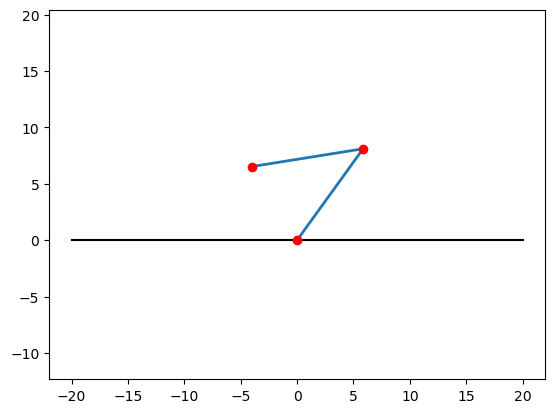


target:  [ 3.05667784 16.31065632]
solution:  [3.0384925240437024, 16.460080907581712]
error:  0.15052712152446882


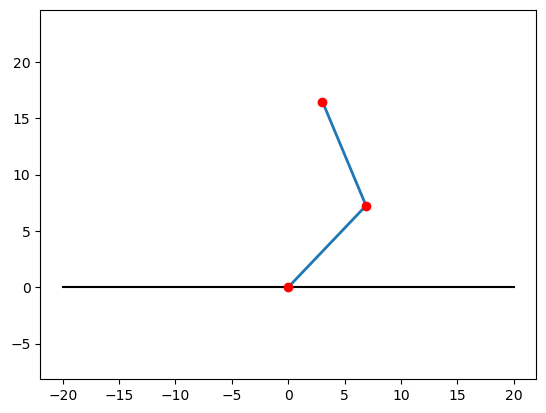


target:  [-2.85203148  2.4739854 ]
solution:  [-2.86551540472255, 2.5309207253030204]
error:  0.058510236562227355


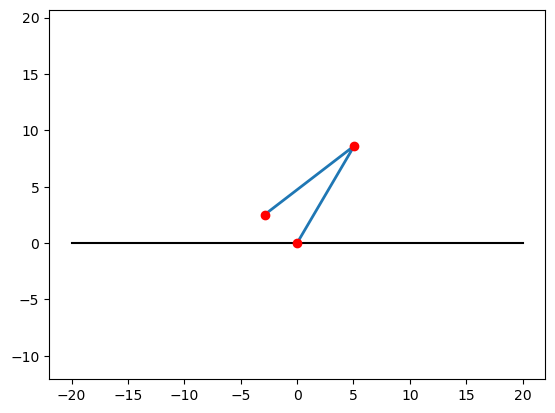


target:  [-3.18011356  3.45914576]
solution:  [-3.2670456792055313, 3.454837414820484]
error:  0.0870388192710115


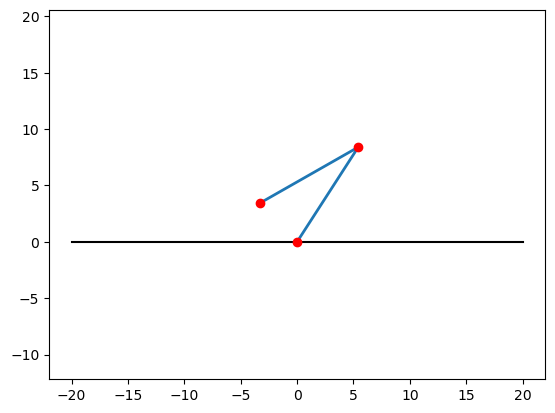


target:  [ 1.72602855 17.55558199]
solution:  [1.9008585316026219, 17.639985221859803]
error:  0.19413765185435655


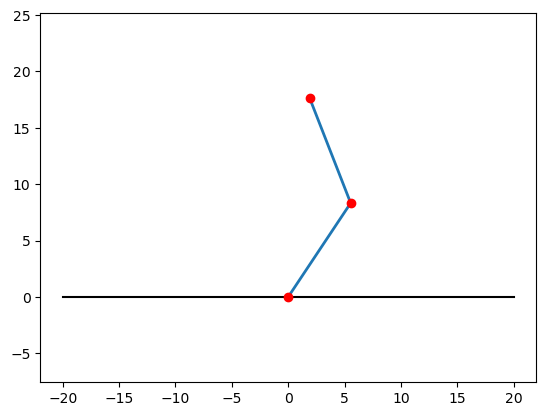


target:  [-2.25235021  0.79022909]
solution:  [-2.4692147046827317, 0.8896849991694022]
error:  0.23858265849149948


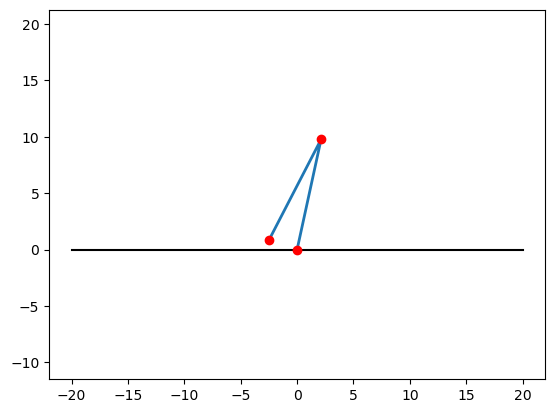


target:  [-2.81988168  3.86323481]
solution:  [-2.946835570631654, 3.7289437886087713]
error:  0.18480088816792273


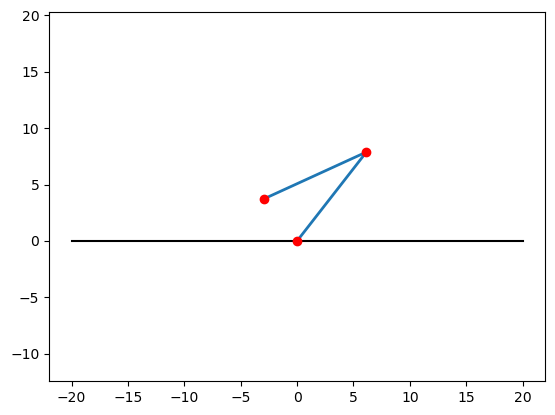


target:  [-2.90314236  3.37528451]
solution:  [-3.0197368527650834, 3.3136429135819583]
error:  0.13188617525345472


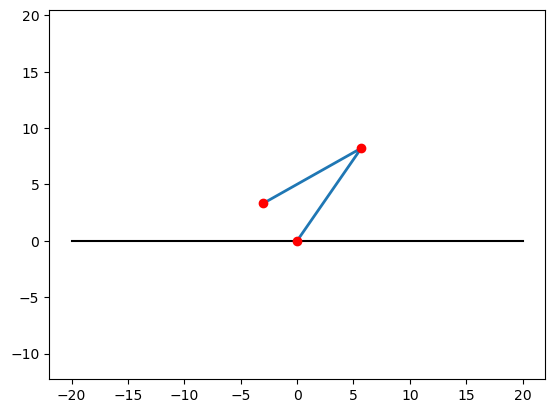


target:  [-3.67384599  5.85549856]
solution:  [-3.7030025445348818, 5.855174272168549]
error:  0.029158361917000247


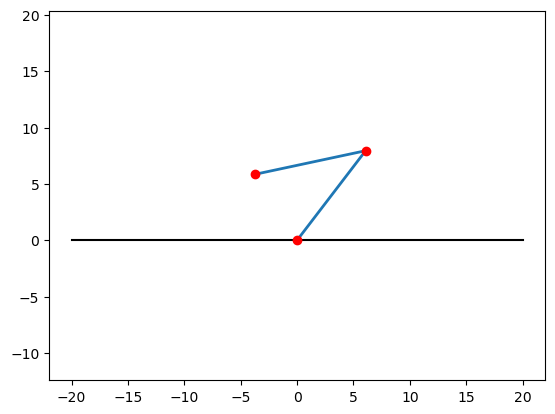


target:  [ 0.30644996 15.30386274]
solution:  [0.22956672862080474, 15.428441627206258]
error:  0.14639307166372853


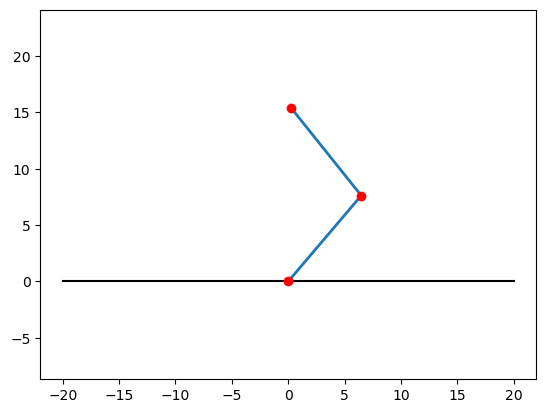


target:  [-1.70463429  0.57869906]
solution:  [-1.9021705426136126, 0.6678749759331275]
error:  0.21673235495180265


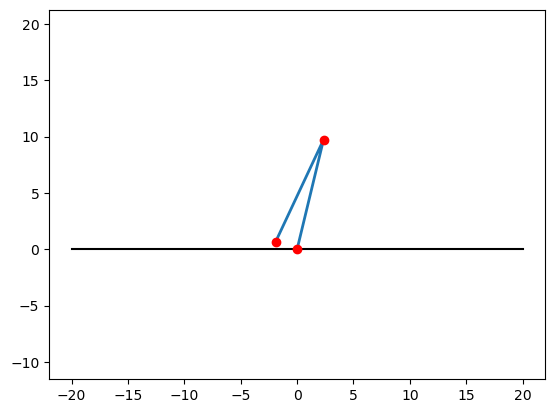


target:  [ 4.30882043 16.94217117]
solution:  [4.461230688265962, 16.85533270945919]
error:  0.17541324138916536


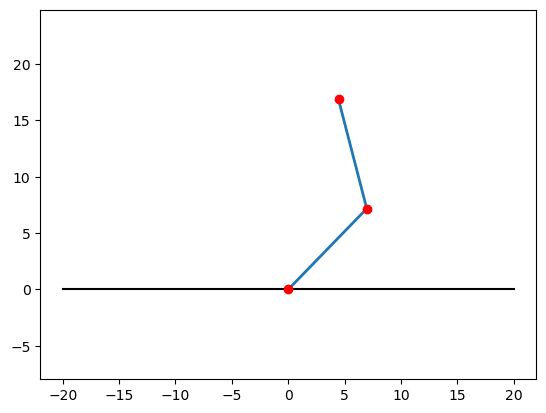


target:  [-8.85008779  9.2649288 ]
solution:  [-8.986921511586303, 9.159243006384992]
error:  0.17289578897482216


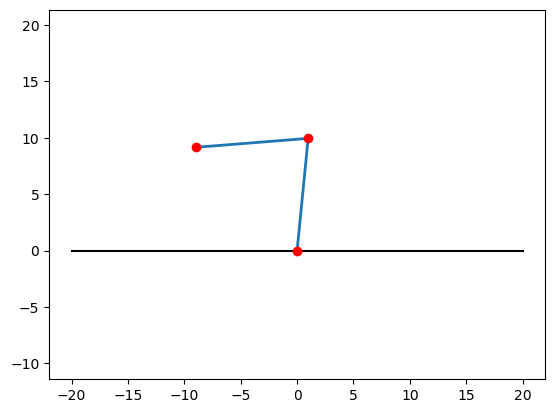


target:  [-5.08901705 13.54640412]
solution:  [-4.529187619899905, 13.577015523498204]
error:  0.5606657214454022


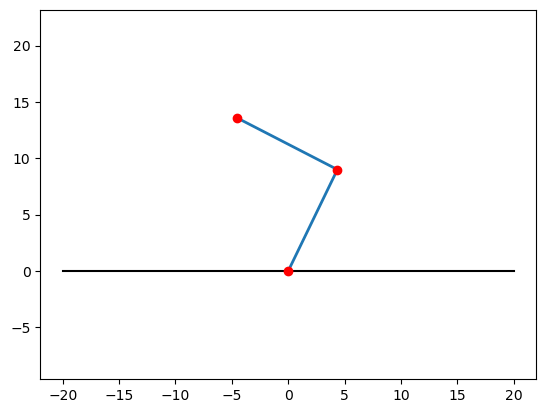


target:  [-4.2742974   1.83426597]
solution:  [-4.164024312001455, 2.1339388064950437]
error:  0.31931796008057955


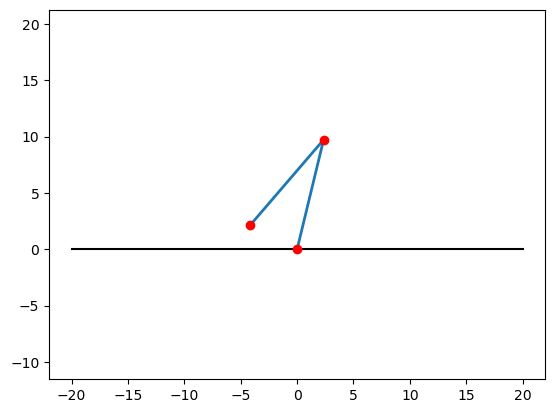


target:  [-2.36079005 12.17493533]
solution:  [-2.2060123447636695, 11.879417178910842]
error:  0.3335972343367802


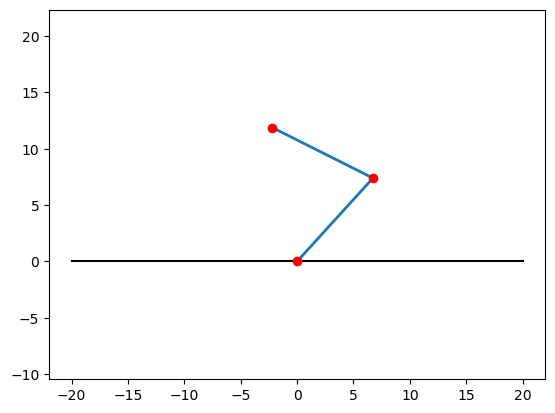


target:  [-5.32733723 17.10317043]
solution:  [-5.69845882762368, 16.969476340212935]
error:  0.3944684364686912


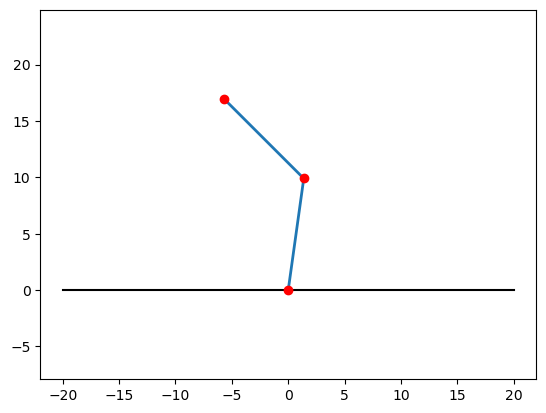


target:  [-1.852636    0.42744021]
solution:  [-1.9342132531154985, 0.4839605840127721]
error:  0.09924414532473176


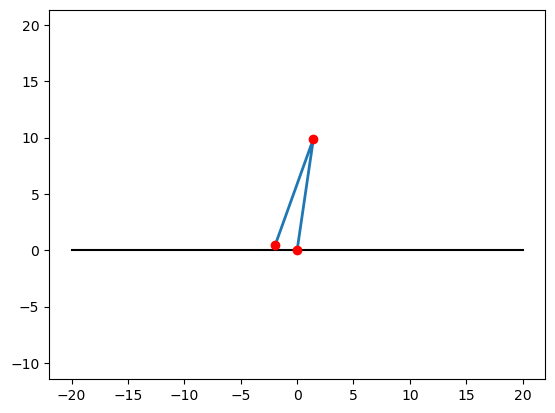


target:  [-2.44666586 16.35075018]
solution:  [-2.4824198389039145, 16.546684384325793]
error:  0.1991696751157959


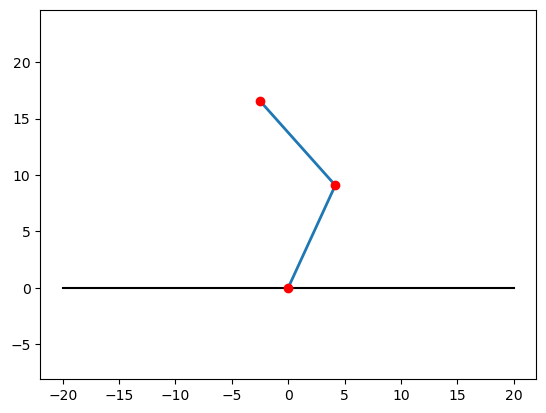


target:  [-7.4220408   3.76245374]
solution:  [-7.424387240445536, 3.3907034469902095]
error:  0.37175769950941284


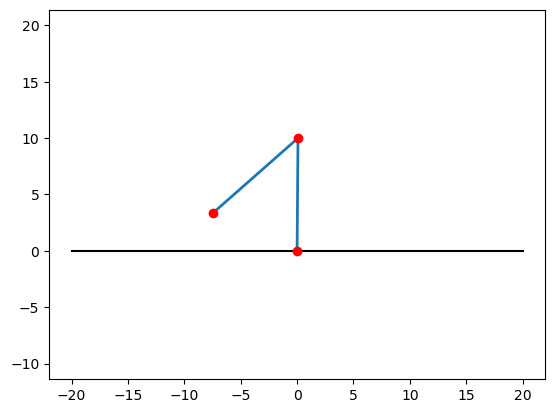


target:  [-4.56052125 17.67932607]
solution:  [-4.9371445478220926, 17.52525209663075]
error:  0.4069200172745053


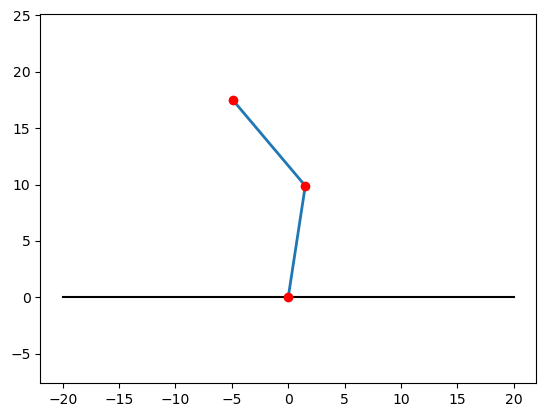


target:  [-9.63341677 10.65671868]
solution:  [-9.854329416627817, 10.25198435006875]
error:  0.46109898194050086


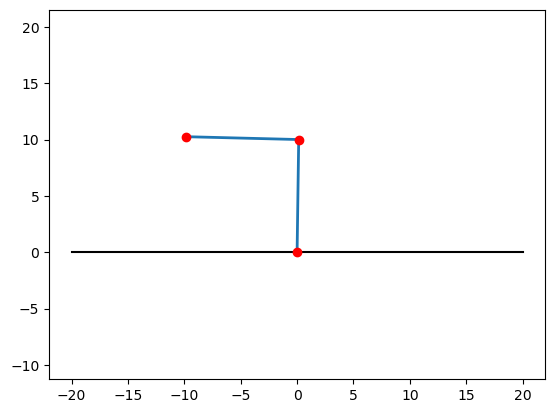


target:  [-4.369457    9.14732729]
solution:  [-4.501142420374855, 9.191721270664493]
error:  0.1389671799536936


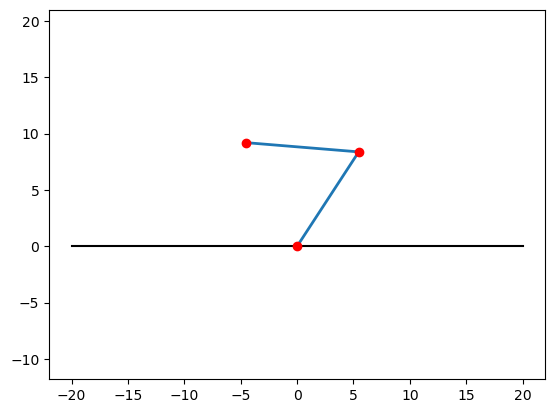


target:  [-1.82373817 18.3844679 ]
solution:  [-1.8849133903714694, 18.198460059878173]
error:  0.1958094110372778


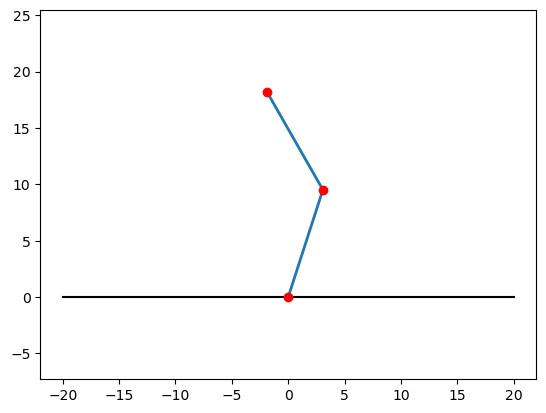


target:  [ 0.83108686 18.14019801]
solution:  [1.0133505025595513, 18.10747687599043]
error:  0.18517750326932764


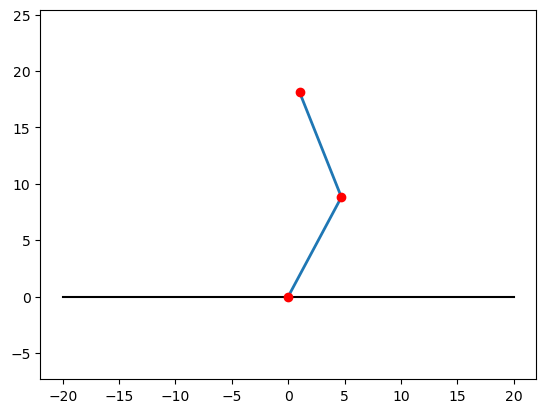


target:  [-3.73936712  1.97041834]
solution:  [-3.631662917318401, 2.2377858427464323]
error:  0.28824568575105


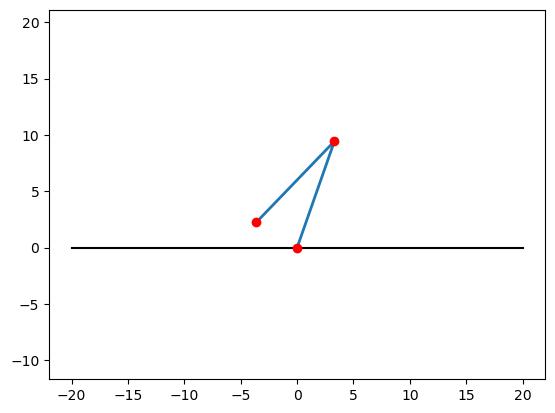


target:  [-7.49988728  3.75021885]
solution:  [-7.518493086060289, 3.3410215002003216]
error:  0.4096201223499002


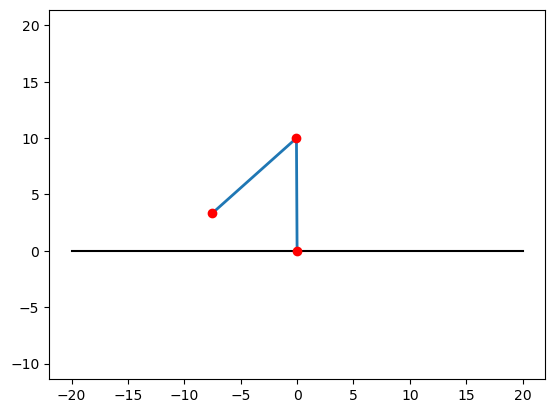


target:  [-2.13686137  1.04099512]
solution:  [-2.2965375122001017, 1.1728024977841685]
error:  0.2070498883570398


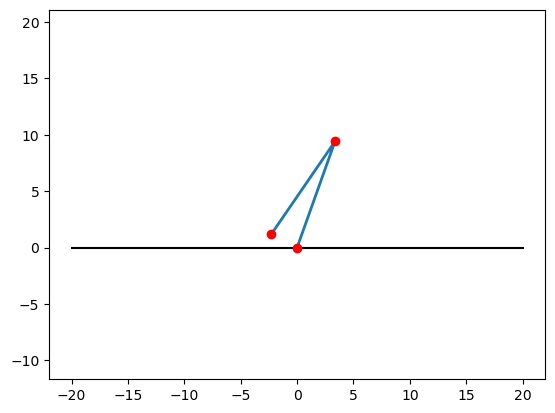


target:  [-3.66622292  7.2072608 ]
solution:  [-3.8868171906668483, 7.148776743351166]
error:  0.22821528293402565


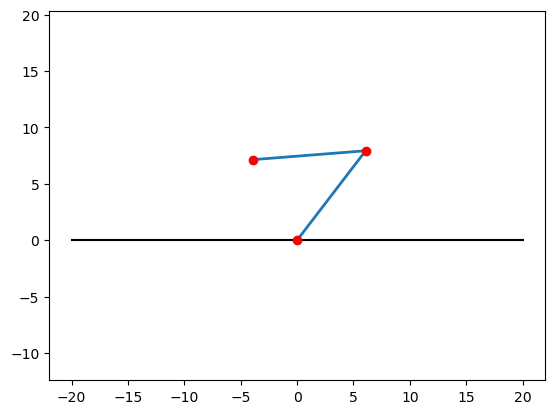


target:  [-4.32460842 12.92023705]
solution:  [-3.646374129600723, 12.82272404755511]
error:  0.6852083895027569


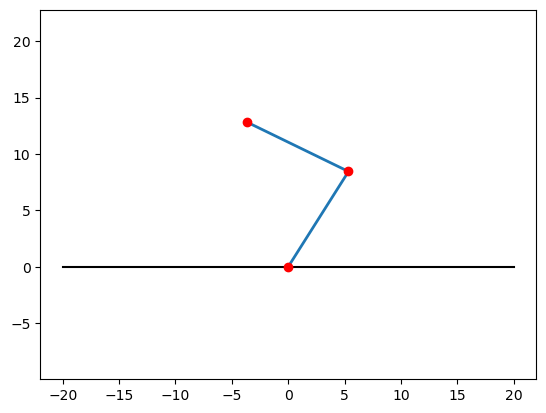


target:  [-3.1884515  17.11737103]
solution:  [-3.3480872004210616, 17.228158655844293]
error:  0.1943127754141012


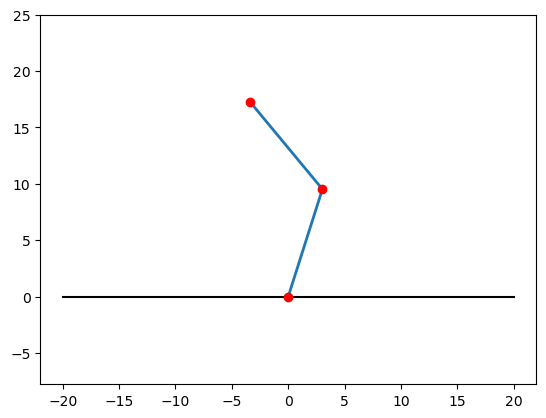


target:  [-9.08921805  7.8857859 ]
solution:  [-9.02614305418085, 7.770556630227732]
error:  0.13136300862865297


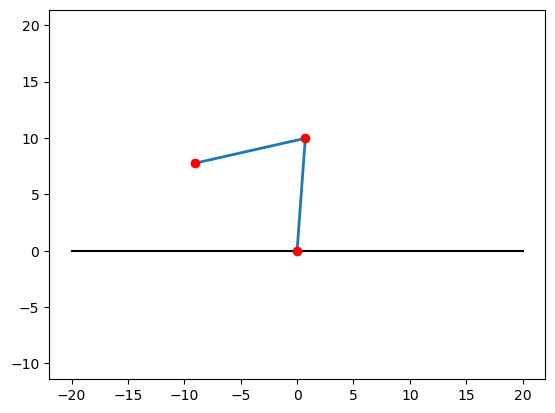


target:  [-4.45042388 10.71325249]
solution:  [-4.344912002001963, 10.705914493420249]
error:  0.1057667411215003


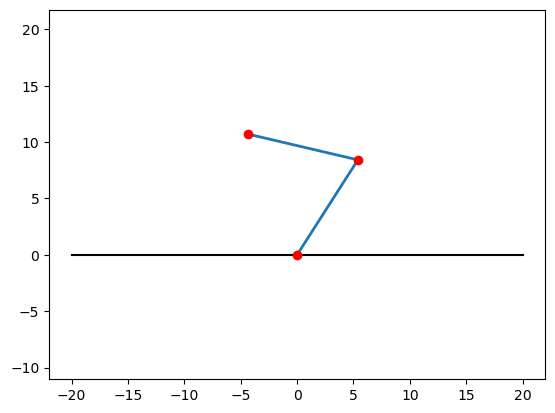


target:  [-6.69985725  8.322798  ]
solution:  [-6.733020686020045, 8.58792123402103]
error:  0.26718934226973945


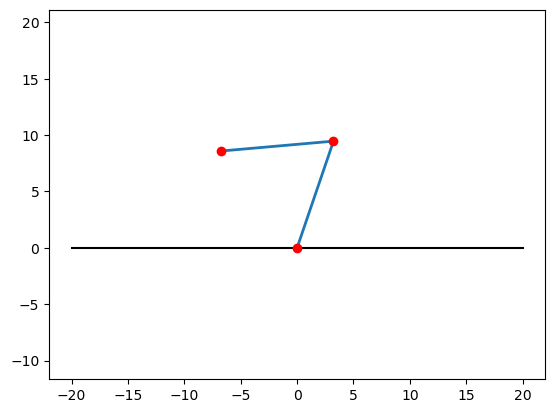


target:  [-6.50562364  6.62377351]
solution:  [-6.275058028801757, 6.970497883820988]
error:  0.4163871866405129


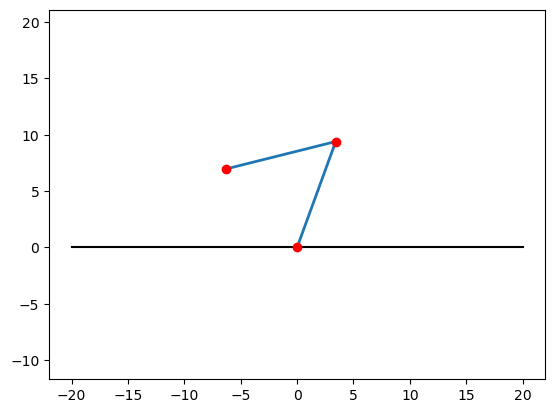


target:  [-4.74792038 10.50087997]
solution:  [-4.683858531064565, 10.560331364493674]
error:  0.08739788279865597


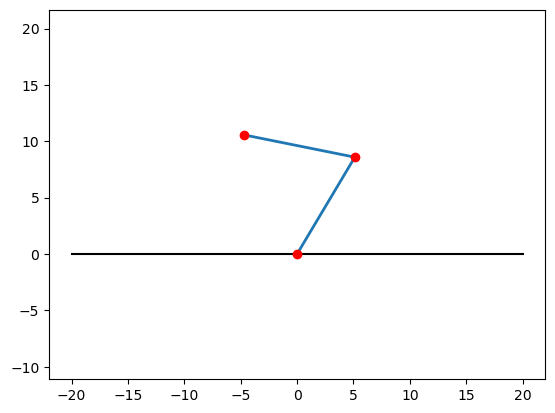


target:  [-2.67041788  0.37020576]
solution:  [-2.5624524917285947, 0.18795951739957317]
error:  0.21182591549945884


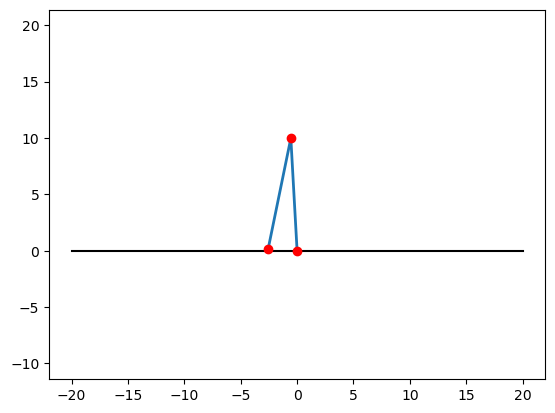


target:  [-2.59531816  3.48639274]
solution:  [-2.7594342619116423, 3.3246341761225606]
error:  0.23043422038528014


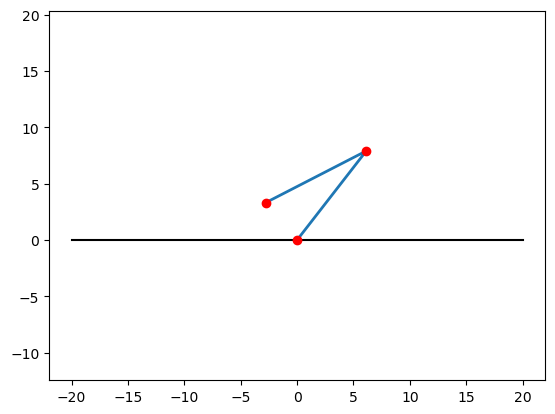


target:  [-5.49461389  6.84349967]
solution:  [-5.408391949575242, 7.1335043802055935]
error:  0.30255074248722286


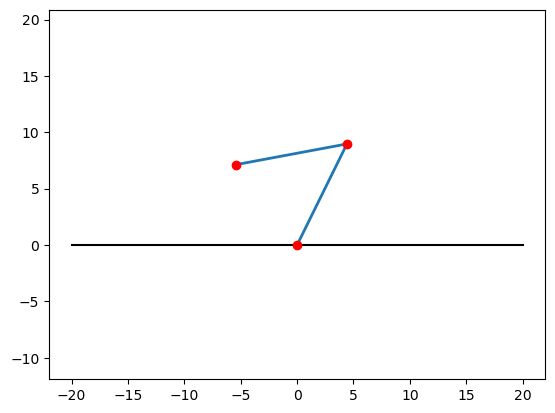


target:  [-8.46545175  6.66455424]
solution:  [-8.407870949625595, 6.5766912923423995]
error:  0.10504972920697099


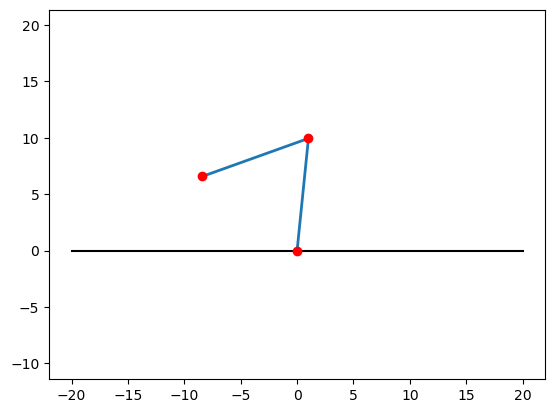


target:  [-0.39696927  0.3783699 ]
solution:  [-0.3734490287378778, 0.24636355516289576]
error:  0.13408533951653437


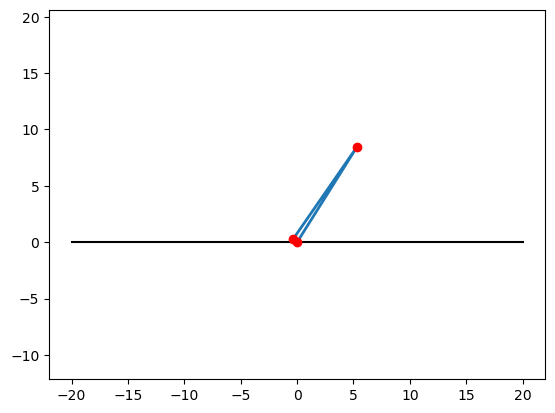


target:  [ 3.65321013 17.77502086]
solution:  [3.9948135206580666, 17.602111859852084]
error:  0.38287125249745085


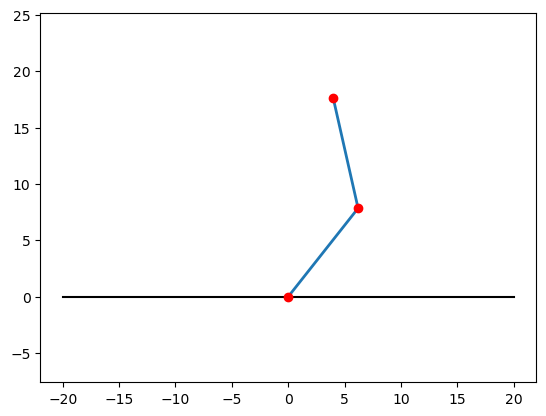


target:  [ 2.44386714 17.66024156]
solution:  [2.6815576909237406, 17.675092088788443]
error:  0.23815401932724228


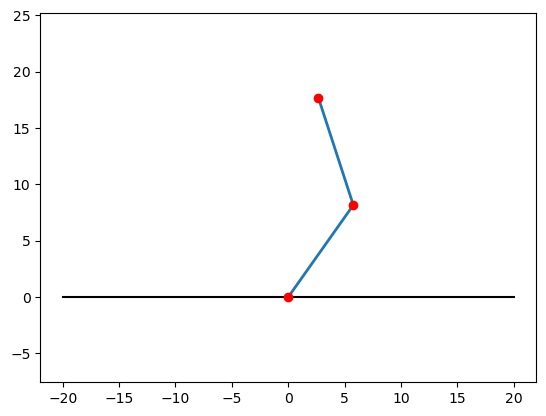


target:  [-2.29260058  3.235364  ]
solution:  [-2.4983911634813616, 3.0104940400498226]
error:  0.3048216907954102


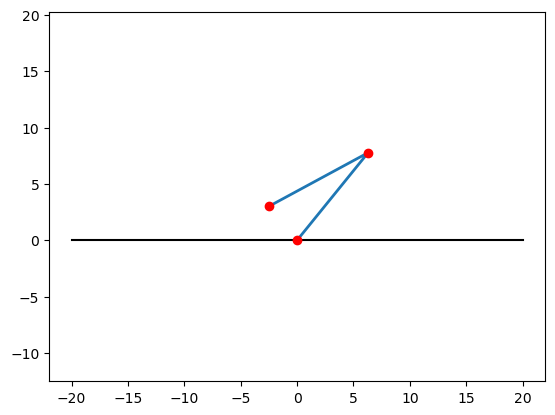


target:  [-0.96738933  0.36810305]
solution:  [-1.0293407232536511, 0.4128366739102738]
error:  0.07641382331711573


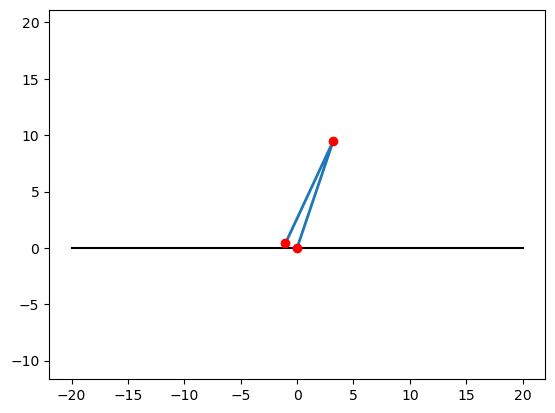


target:  [-6.42383492  4.26548573]
solution:  [-6.4951896494105945, 4.210780773757263]
error:  0.08991178794305087


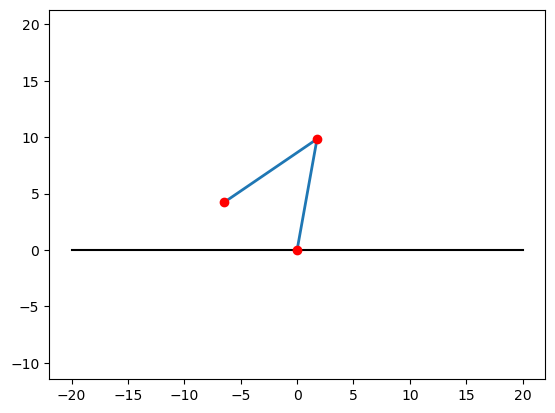


target:  [-3.50094796  1.36158446]
solution:  [-3.545664739735752, 1.5147050972624907]
error:  0.15951651698154035


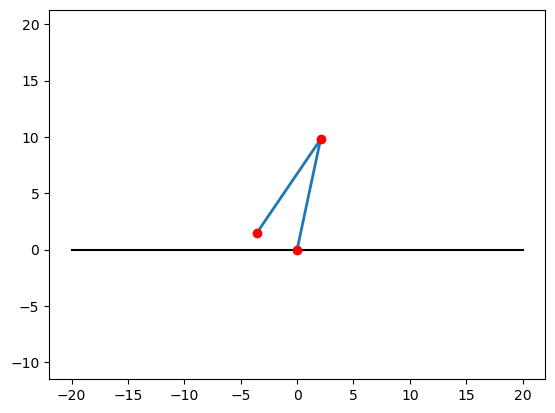


target:  [-0.16569331  0.12266618]
solution:  [-0.1480115579698369, 0.07913356346587186]
error:  0.04698651546724253


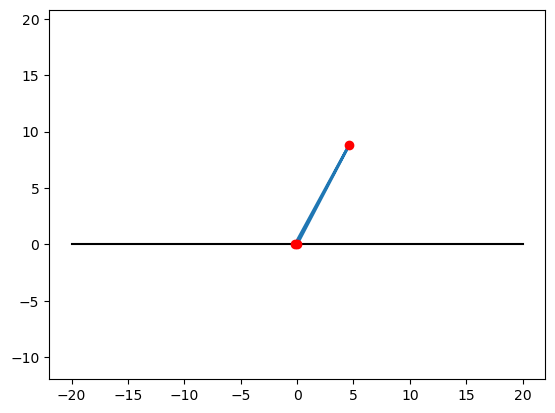


target:  [-4.60110205 11.7365158 ]
solution:  [-4.227549362194519, 11.689623150471734]
error:  0.37648443391001596


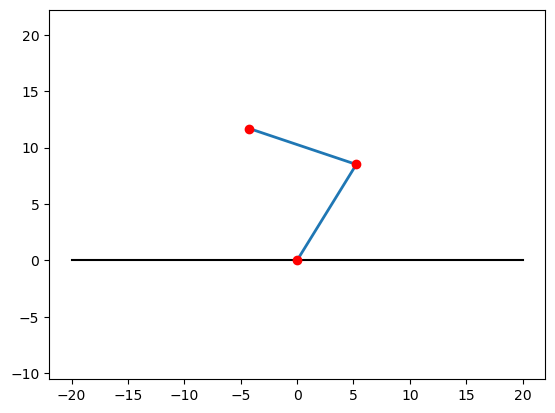


target:  [-0.68769644  0.4071247 ]
solution:  [-0.7041226656754196, 0.38000924670323144]
error:  0.031702818576608886


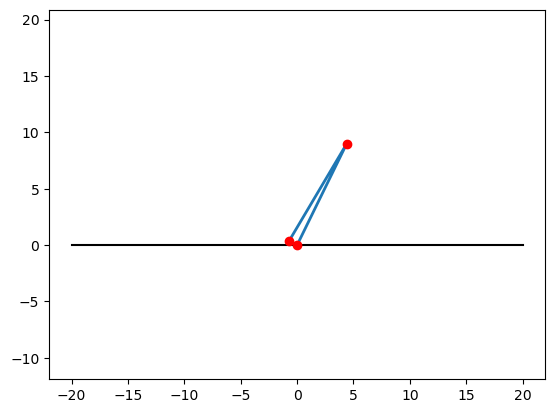


target:  [-3.71301173  9.03827388]
solution:  [-3.913132636814855, 8.93359746575029]
error:  0.22584403407670095


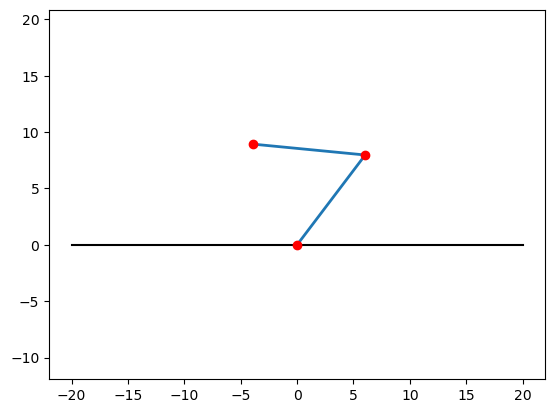


target:  [-1.40629214 18.40873208]
solution:  [-1.4105227259632285, 18.196257995212484]
error:  0.21251619843414465


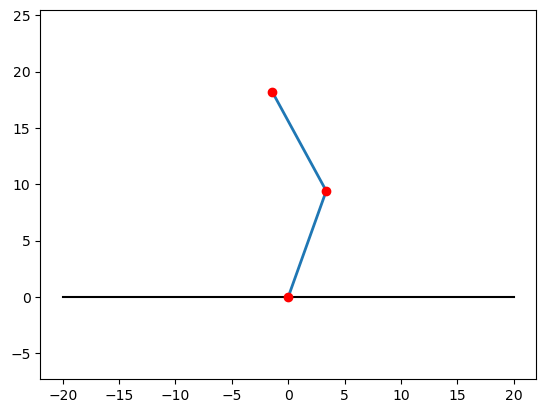


target:  [-5.47960183 17.58148369]
solution:  [-5.950867489670963, 17.27989839820394]
error:  0.559504254438385


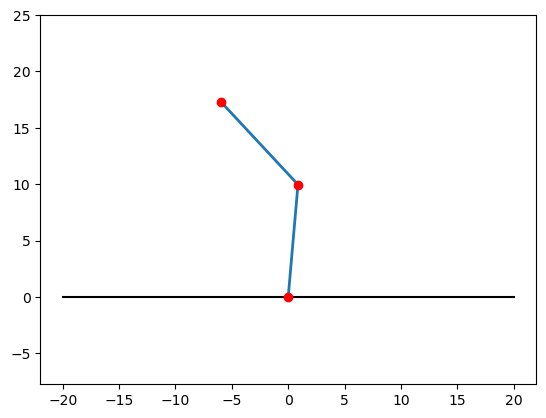


target:  [-9.0169674  12.50250897]
solution:  [-8.94211725776975, 12.22644350430162]
error:  0.2860326626194116


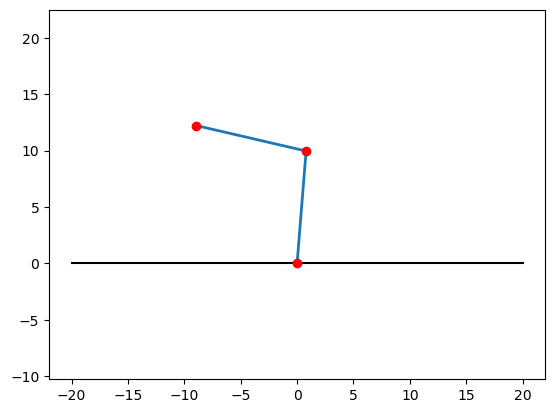


target:  [-2.66021705  1.0416466 ]
solution:  [-2.821720147467111, 1.1585504671221383]
error:  0.19937342677208678


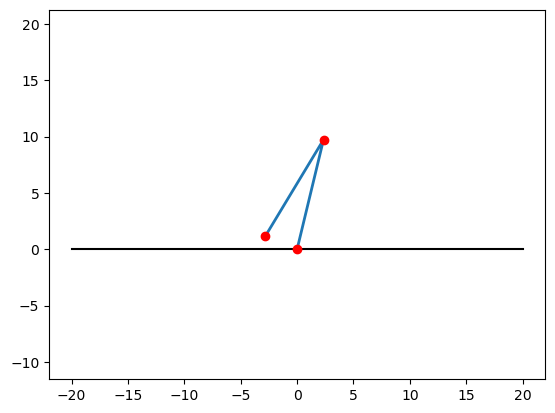


target:  [-2.94646102 17.84255457]
solution:  [-3.137185555063307, 17.80347622648616]
error:  0.1946868431370337


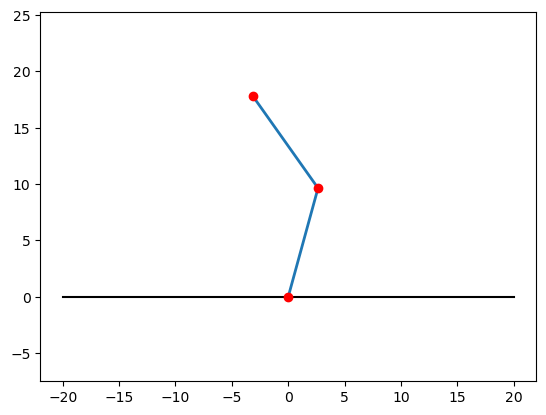


target:  [-1.96604925 12.67908376]
solution:  [-1.6816956063895319, 12.282261632859573]
error:  0.48818520851244085


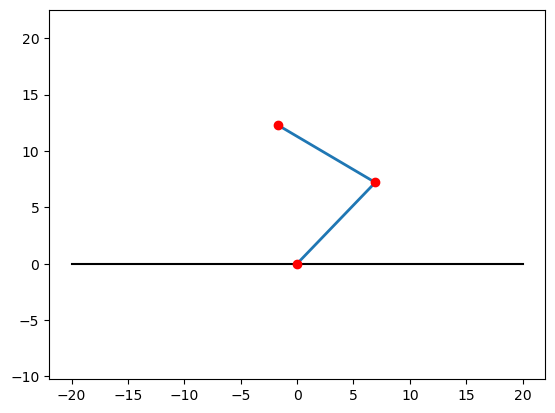


target:  [-4.68385821  2.82812909]
solution:  [-4.596793131873163, 2.98688706234206]
error:  0.1810646937124388


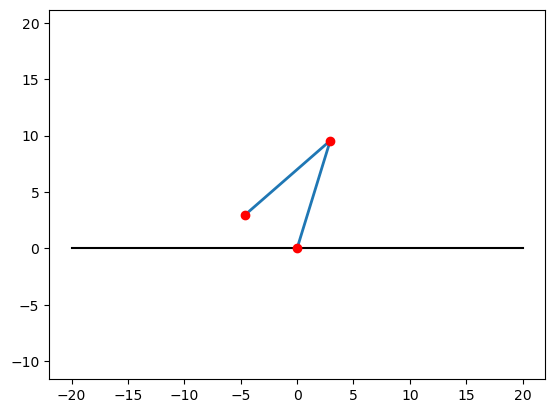


target:  [-2.44387938  0.51809864]
solution:  [-2.5521616353636674, 0.5436082290377975]
error:  0.11124651523264707


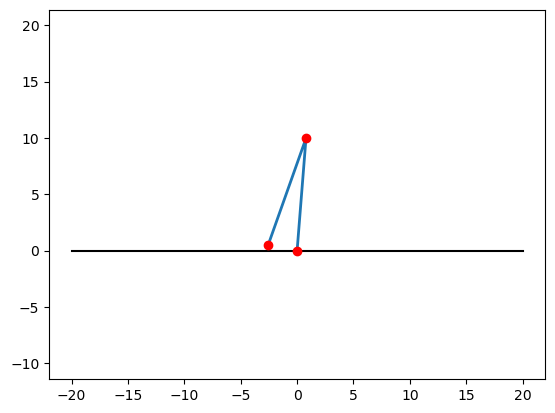


target:  [-3.23868353  2.99470398]
solution:  [-3.2838767955269104, 3.0508401320708938]
error:  0.07206732664711035


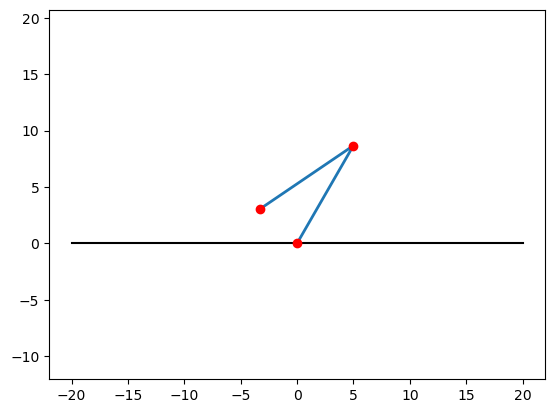


target:  [-7.77737886 13.07178873]
solution:  [-7.617287137488908, 13.040773677003347]
error:  0.1630683721108691


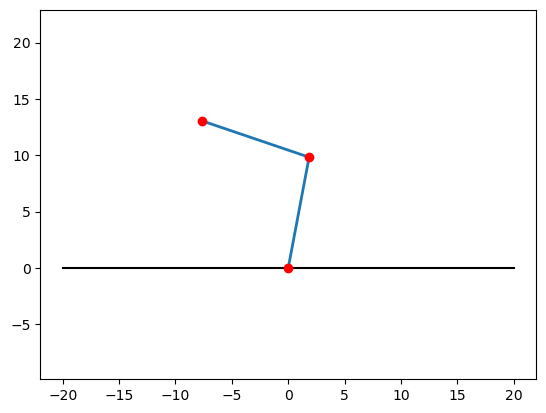


target:  [-1.85721415 12.48794924]
solution:  [-1.6729566265274007, 12.081628972290439]
error:  0.4461468298349313


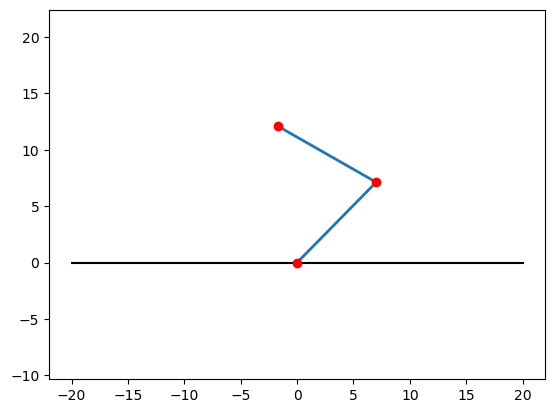


target:  [-6.86733919 14.44705817]
solution:  [-6.900776263829845, 14.460091854790976]
error:  0.03588753095301663


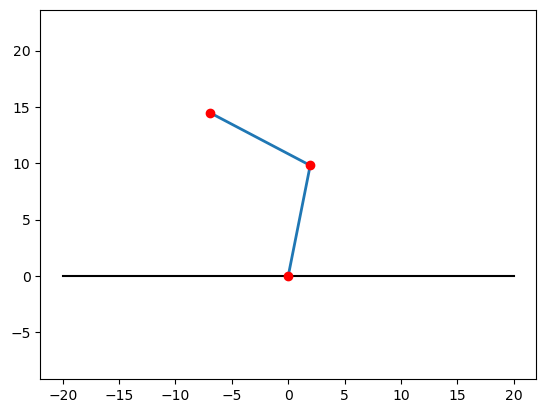


target:  [-2.40029142  0.51146546]
solution:  [-2.506509096979033, 0.540798757219342]
error:  0.11019363891817523


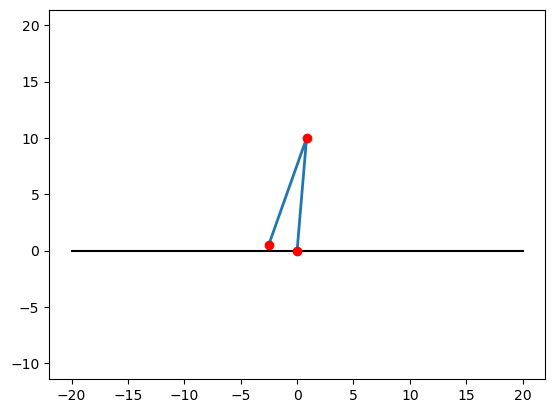


target:  [ 2.31086099 17.42230583]
solution:  [2.498157432415273, 17.497979732846787]
error:  0.2020061759732126


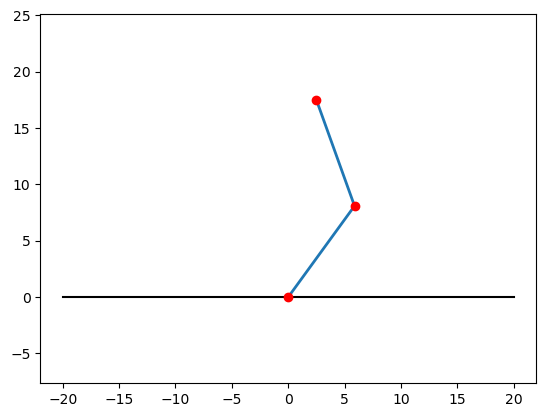


target:  [-7.20774018  3.28822745]
solution:  [-7.283008768272406, 2.903130906048723]
error:  0.39238337118174915


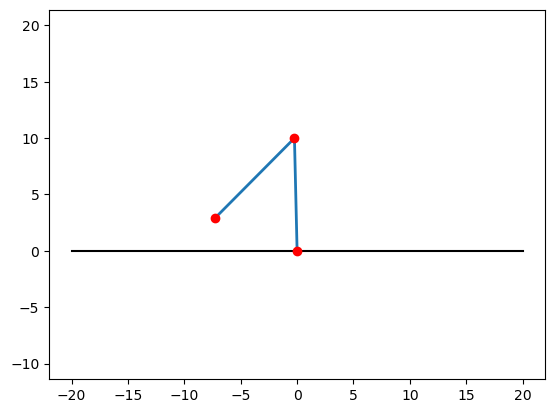


target:  [-3.04235357  5.17758498]
solution:  [-3.084932445826337, 5.023363004906495]
error:  0.15999181020164124


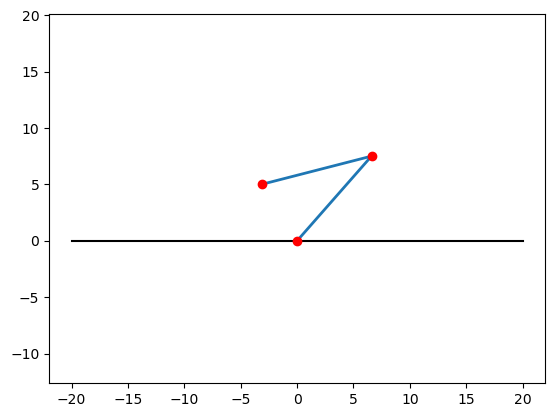


target:  [-1.98701265  0.23364866]
solution:  [-1.8015750817365142, 0.16734873709249598]
error:  0.1969334183925579


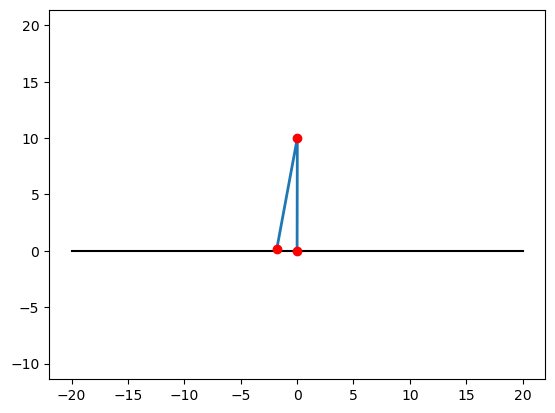


target:  [-3.37282467  8.10599766]
solution:  [-3.670612878316337, 7.937092166471734]
error:  0.3423549068673027


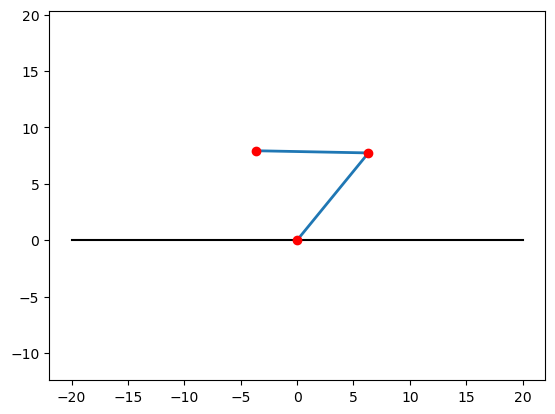


target:  [-4.50795271 10.85970103]
solution:  [-4.369040905218873, 10.855425786091121]
error:  0.13897757990448015


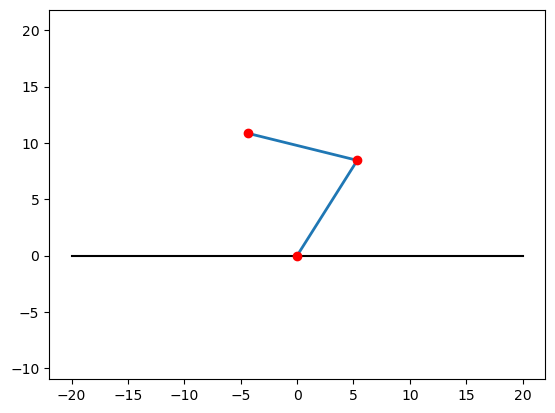


target:  [-8.2643343  15.20786013]
solution:  [-8.928165523724255, 14.756956022353766]
error:  0.802487632367249


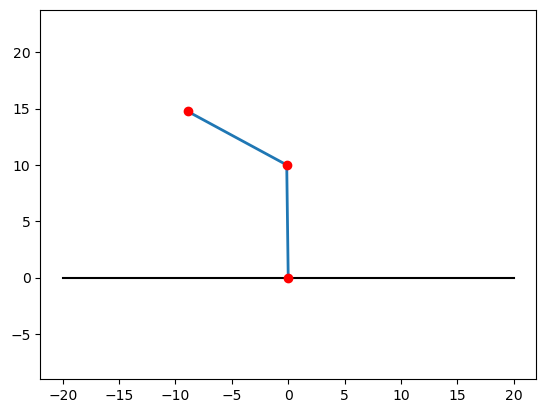


target:  [ 5.15599975 17.04801528]
solution:  [5.179312753383855, 17.18871541205844]
error:  0.14261845504702028


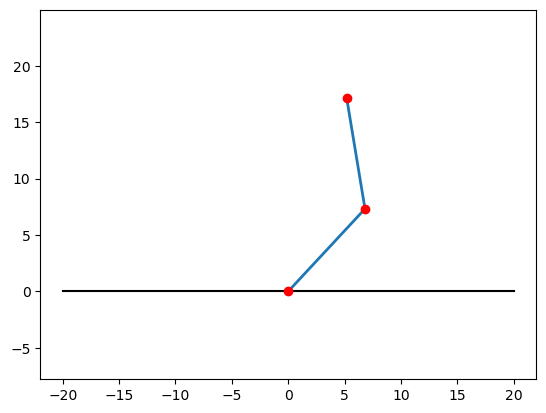


target:  [-0.91420684 16.76419125]
solution:  [-0.8920908087002033, 16.811182979979733]
error:  0.051935939106817756


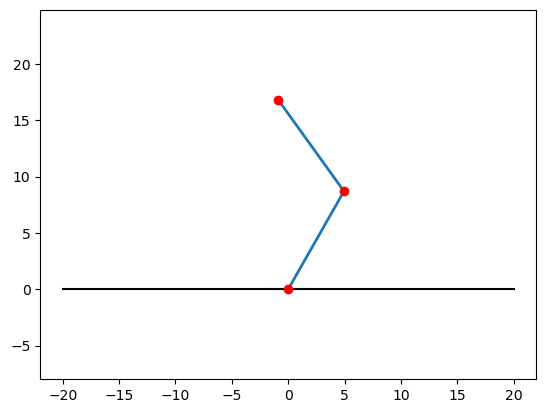


target:  [-2.69473984 15.85816117]
solution:  [-2.693816940746496, 16.08018979594699]
error:  0.22203054230589547


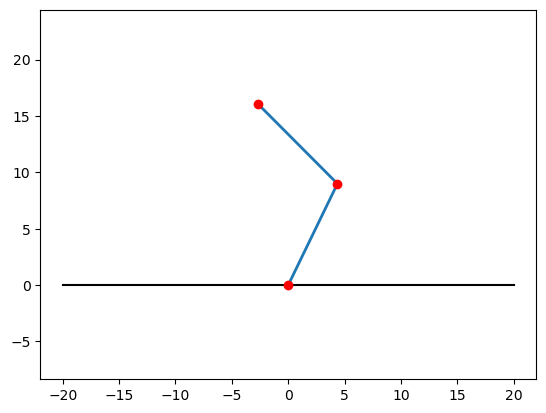


target:  [-4.29489528 17.7156452 ]
solution:  [-4.643325717764441, 17.590630714636276]
error:  0.37017886367876524


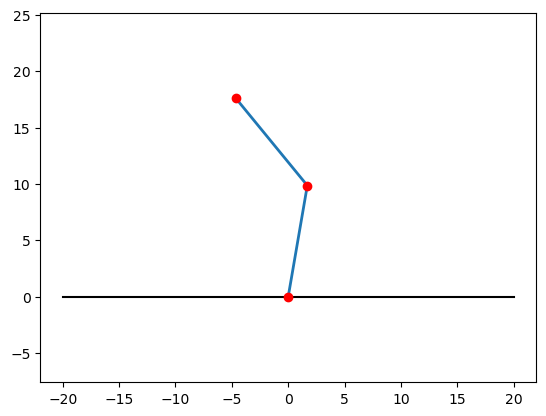


target:  [-4.87515108  8.30917364]
solution:  [-4.993270984472424, 8.469188811850236]
error:  0.19888983222494325


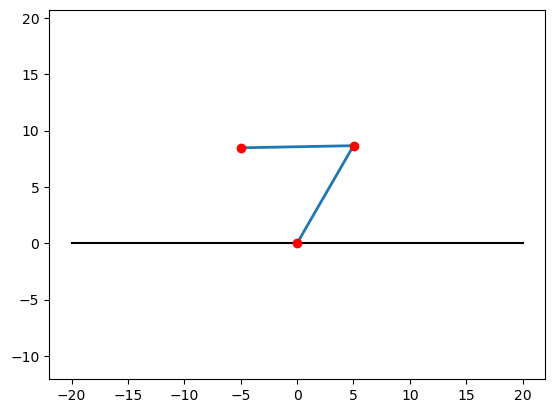


target:  [-0.46487071 14.68332912]
solution:  [-0.48704648348963087, 14.620293280454119]
error:  0.0668227606655052


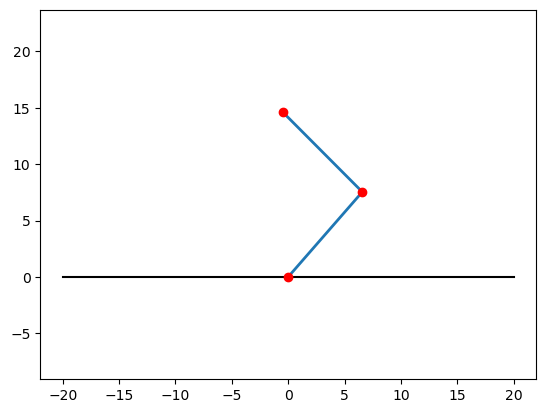


target:  [-1.86272189  2.127965  ]
solution:  [-1.9887959456503372, 1.9812141484562318]
error:  0.19346957872188084


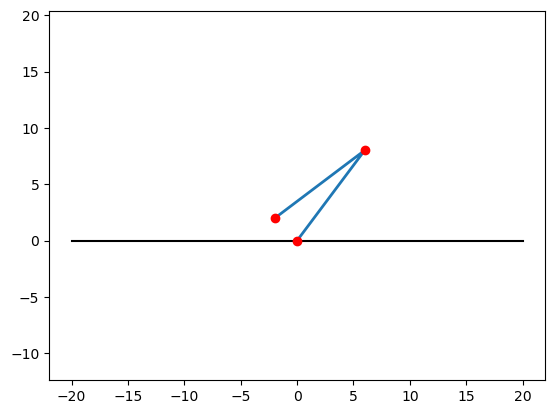


target:  [-8.44644627 10.74111325]
solution:  [-8.55971589210672, 10.691285670740127]
error:  0.12374487658486738


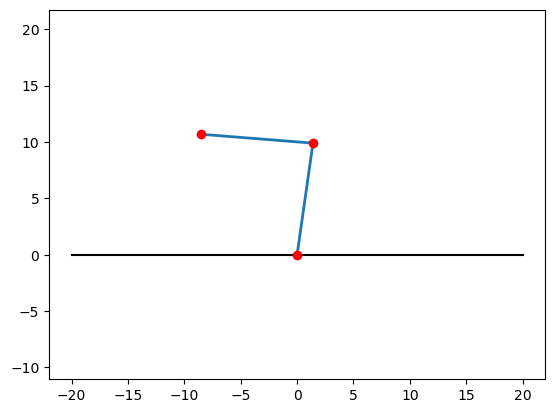


target:  [-7.69141747 12.19947481]
solution:  [-7.488080454635645, 12.223765498799242]
error:  0.20478276569520776


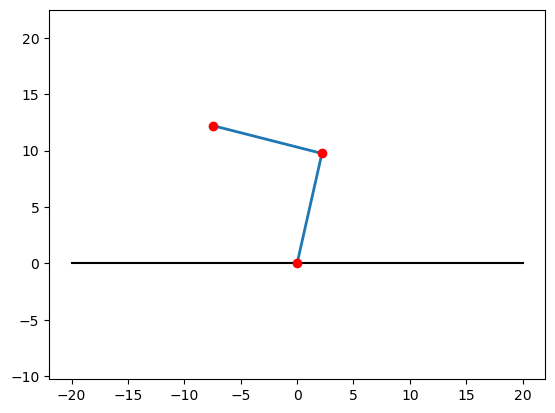


target:  [-3.83887096  3.07253448]
solution:  [-3.8379378570252944, 3.2036453775280114]
error:  0.13111422181468732


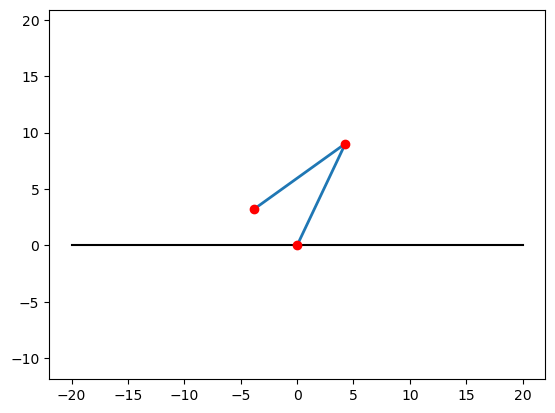


target:  [-6.57084401  5.61245318]
solution:  [-6.493319546339792, 5.8065484925952475]
error:  0.20900486111061709


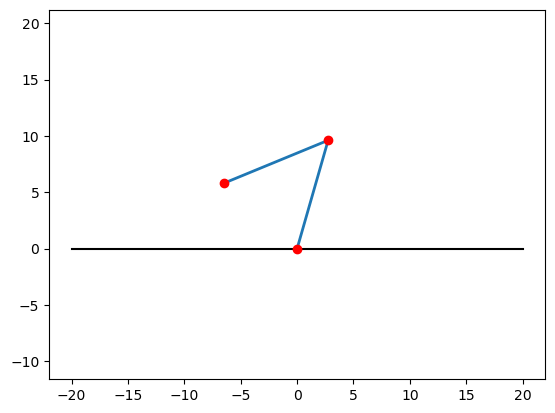


target:  [-0.39265759  0.37533691]
solution:  [-0.3688771028993436, 0.24314528601670737]
error:  0.134313578084949


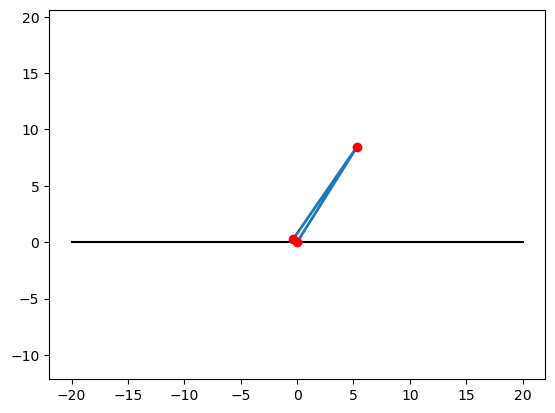


target:  [-7.89056284  7.13489227]
solution:  [-7.692369485767637, 7.336740070119308]
error:  0.2828836165387519


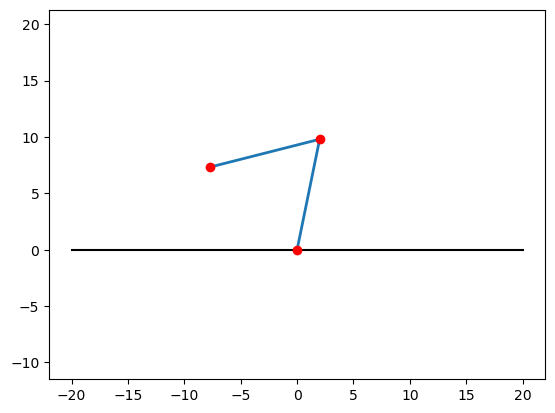


target:  [-8.54656748 14.57517323]
solution:  [-9.11770208005093, 14.160744030223974]
error:  0.7056530945989976


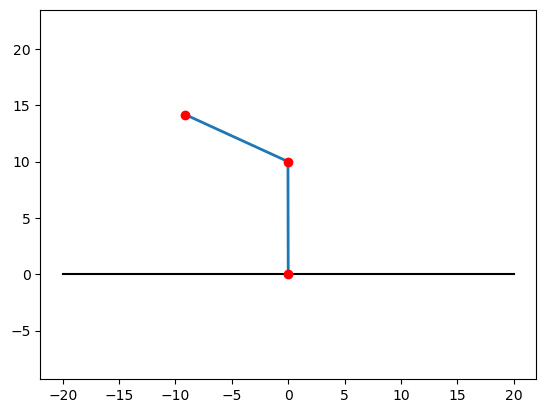


target:  [-7.18067625  8.32267751]
solution:  [-7.2065312783717905, 8.557152825188806]
error:  0.2358964894922651


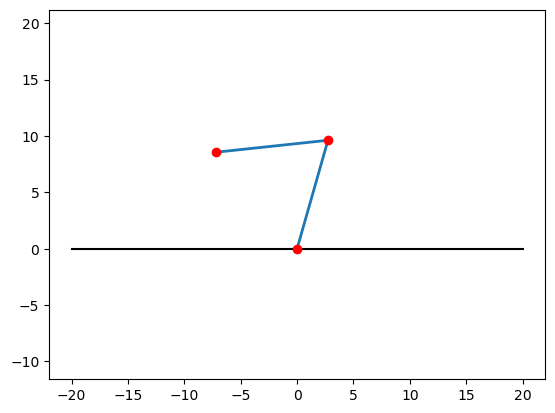


target:  [-0.94472129  0.15183736]
solution:  [-0.8541371854298934, 0.17013210937511758]
error:  0.0924130847383728


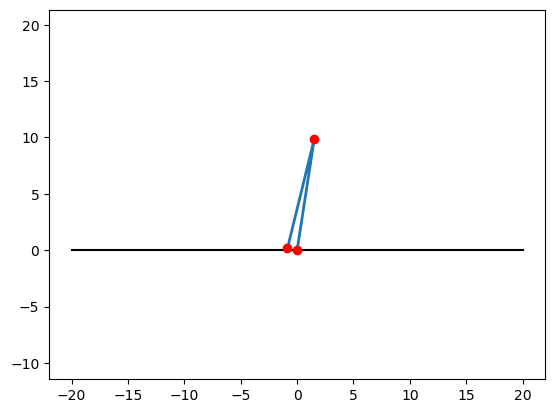


target:  [ 2.72235374 17.92456384]
solution:  [3.0283144007043203, 17.845100682080172]
error:  0.3161112425652844


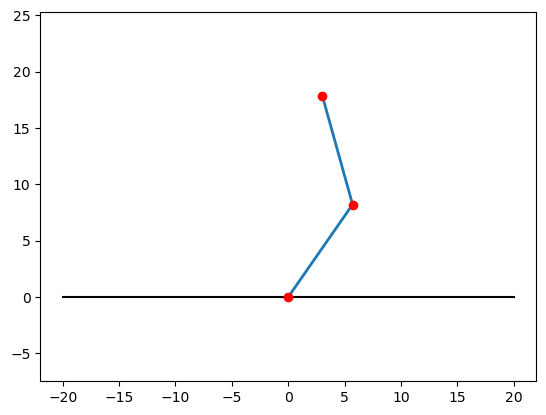


target:  [-3.74725611  8.34405219]
solution:  [-3.98435243584634, 8.271074034543934]
error:  0.24807353000876747


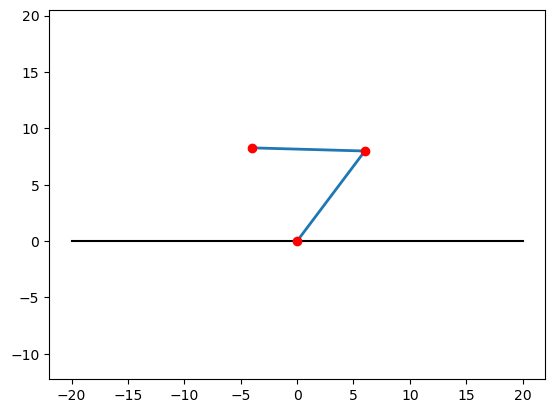


target:  [-0.42711586  0.08812604]
solution:  [-0.30908203860400185, 0.10819774351879907]
error:  0.11972825743731282


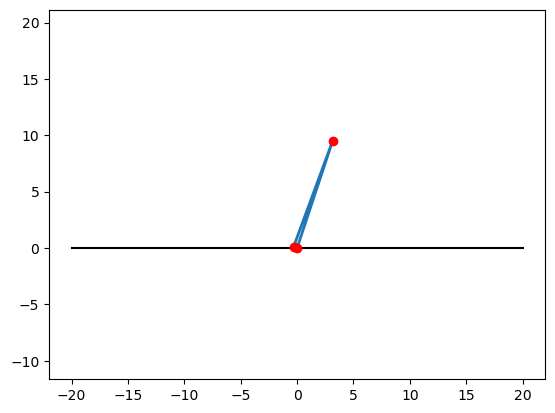


target:  [-6.80196366 12.66073139]
solution:  [-6.345924928895508, 12.726587471754819]
error:  0.46076929744327505


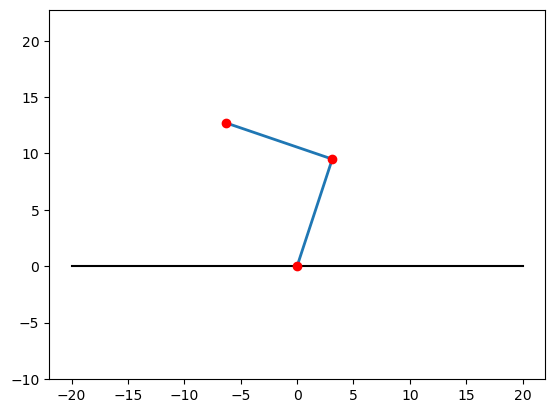


target:  [-1.57850107  0.29046002]
solution:  [-1.5333526360111331, 0.3069116378797645]
error:  0.04805244010590643


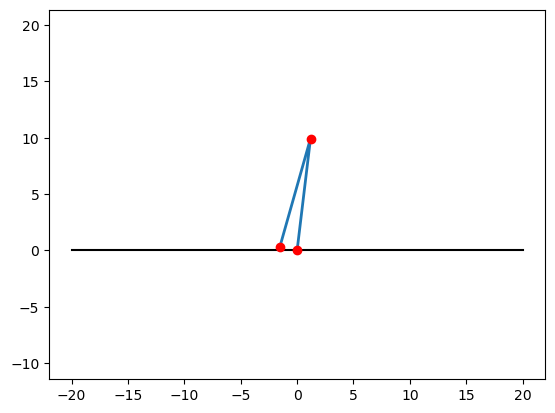


target:  [-7.71226089 12.87061989]
solution:  [-7.459130702835678, 12.856156243352093]
error:  0.2535430718656558


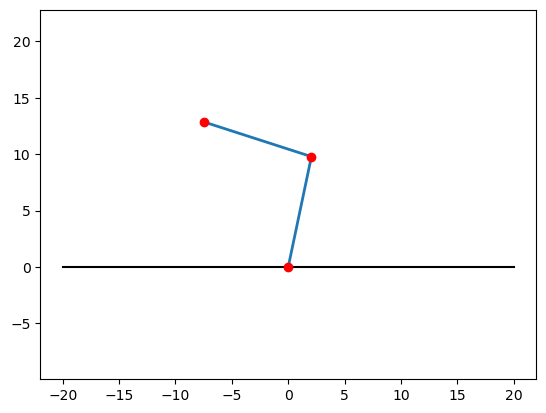


target:  [-1.99973989  1.90420807]
solution:  [-2.0359159612030115, 1.8624056977637498]
error:  0.05528242139748928


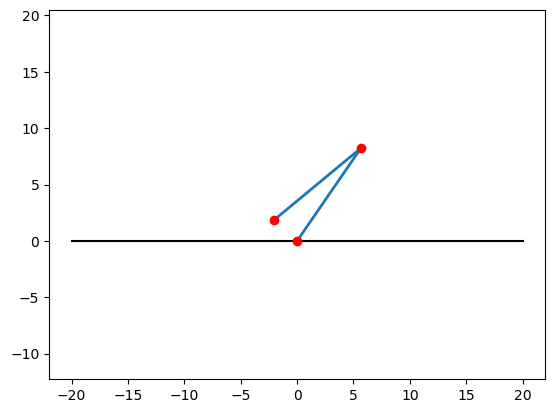


target:  [-2.26818906 14.80642247]
solution:  [-2.1563477043860066, 14.93172288145975]
error:  0.16795440486253438


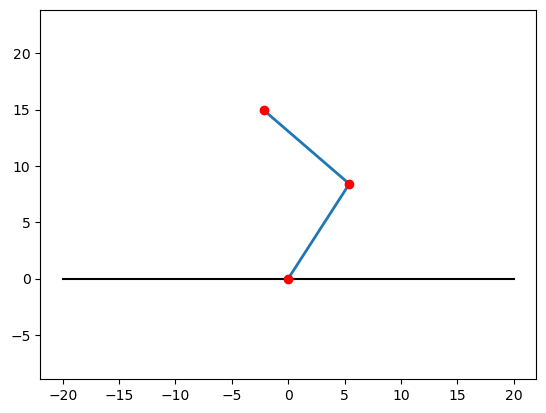


target:  [-3.69726185  1.44886827]
solution:  [-3.7086764664464424, 1.6201041135094574]
error:  0.1716158721355793


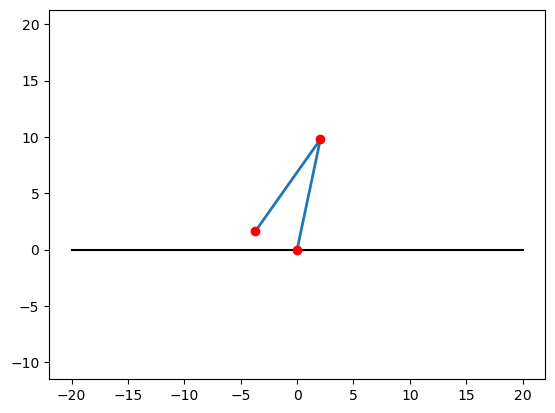

Average error:  0.23333897177326804


In [30]:
tot_err = 0
for t in a.cart_test:
    print('\ntarget: ',t)
    [inv_error, config] = a.inv_kin(t)
    print('solution: ', config)
    tot_err += inv_error
    print('error: ', inv_error)
    a.plot_arm()
    plt.pause(2)
tot_err = tot_err/n_test
print('Average error: ',tot_err)

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_netw

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning:

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reache

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_it

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_it

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning:

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning:

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_it

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning:

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_it

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reache

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


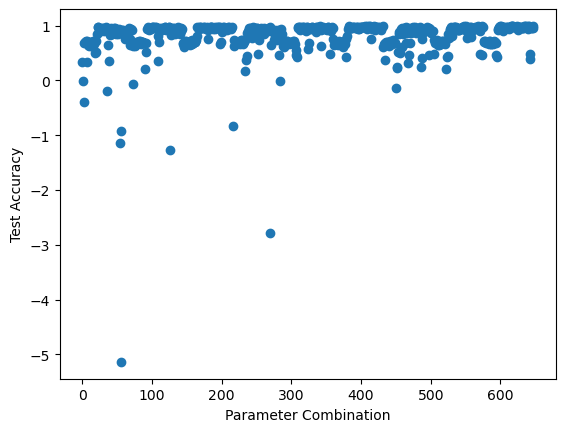

In [5]:
import pandas as pd

# Define a function to create the MLPRegressor with the desired parameters
def create_mlp(n_layers, n_neurons, transfer_func, learn_rate, algorithm, max_iter):
    return MLPRegressor(hidden_layer_sizes=(n_neurons,) * n_layers,
                        activation=transfer_func,
                        learning_rate_init=learn_rate,
                        solver=algorithm,
                        max_iter=max_iter)

a = arm()

# Define the parameters to be modified
n_layers_list = [1, 2, 3]  # Test 1, 2 and 3 layers
n_neurons_list = [5, 10, 20]  # Test 5, 10 and 20 neurons per layer
transfer_func_list = ['identity', 'logistic', 'tanh', 'relu']  # Test different activation functions
learn_rate_list = [0.001, 0.01, 0.1]  # Test different learning rates
algorithm_list = ['adam', 'lbfgs']  # Test different optimization algorithms
max_iter_list = [100, 200, 300]  # Test different maximum number of iterations


test_accuracies = []

# Loop through all combinations of parameters and create, train and test the MLPRegressor
for n_layers in n_layers_list:
    for n_neurons in n_neurons_list:
        for transfer_func in transfer_func_list:
            for learn_rate in learn_rate_list:
                for algorithm in algorithm_list:
                    for max_iter in max_iter_list:
                        # Create and train the MLPRegressor
                        ann = create_mlp(n_layers, n_neurons, transfer_func, learn_rate, algorithm, max_iter)
                        n_train = 1000
                        n_test = 100
                        j1_range = (0, np.pi/2)
                        j2_range = (0, np.pi)
                        a.create_data(ann, n_train, n_test, j1_range, j2_range)
                        a.train_inv_kin()
                        # Test the MLPRegressor and append the test accuracy to the list
                        test_accuracy = a.test_inv_kin()
                        test_accuracies.append(test_accuracy)

# Create a scatter plot of the test accuracies
plt.scatter(range(len(test_accuracies)), test_accuracies)
plt.xlabel('Parameter Combination')
plt.ylabel('Test Accuracy')
plt.show()


C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning:

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning:

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning:

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning:

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reache

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reache

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_it

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_it

C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\SOLOMON\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

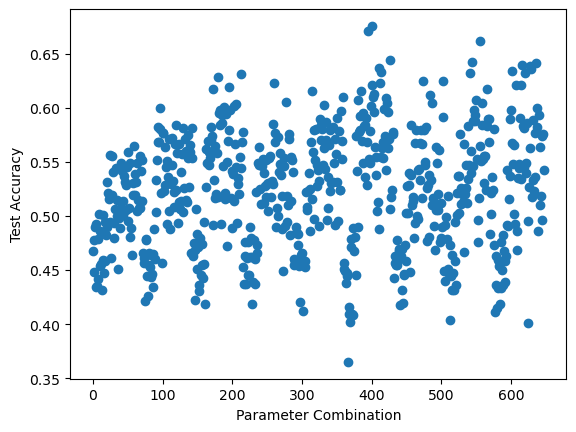

In [6]:
test_accuracies = []

# Loop through all combinations of parameters and create, train and test the MLPRegressor
for n_layers in n_layers_list:
    for n_neurons in n_neurons_list:
        for transfer_func in transfer_func_list:
            for learn_rate in learn_rate_list:
                for algorithm in algorithm_list:
                    for max_iter in max_iter_list:
                        # Create and train the MLPRegressor
                        ann = create_mlp(n_layers, n_neurons, transfer_func, learn_rate, algorithm, max_iter)
                        n_train = 5000
                        n_test = 200
                        j1_range = (0, np.pi)  # set range of j1 to be between 0 and pi radians 
                        j2_range = (-np.pi/2, np.pi/2)  # set range of j2 to be between -pi/2 and pi/2 radians 
                        a.create_data(ann, n_train, n_test, j1_range, j2_range)
                        a.train_inv_kin()
                        # Test the MLPRegressor and append the test accuracy to the list
                        test_accuracy = a.test_inv_kin()
                        test_accuracies.append(test_accuracy)

# Create a scatter plot of the test accuracies
plt.scatter(range(len(test_accuracies)), test_accuracies)
plt.xlabel('Parameter Combination')
plt.ylabel('Test Accuracy')
plt.show()
